In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(6784163, 828)
(6784163, 8)
validation
(966999, 828)
(966999, 8)
test
(856741, 828)
(856741, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/679 [..............................] - ETA: 15:51 - loss: 2.4944 - STD: 0.0863 - MAE: 0.2216

  4/679 [..............................] - ETA: 12s - loss: 2.2211 - STD: 0.0454 - MAE: 0.2196  

  7/679 [..............................] - ETA: 12s - loss: 2.1668 - STD: 0.0568 - MAE: 0.2173

 10/679 [..............................] - ETA: 12s - loss: 2.1475 - STD: 0.0604 - MAE: 0.2166

 13/679 [..............................] - ETA: 12s - loss: 2.1289 - STD: 0.0558 - MAE: 0.2165

 16/679 [..............................] - ETA: 12s - loss: 2.1156 - STD: 0.0502 - MAE: 0.2167

 19/679 [..............................] - ETA: 12s - loss: 2.1069 - STD: 0.0463 - MAE: 0.2168

 22/679 [..............................] - ETA: 12s - loss: 2.1006 - STD: 0.0440 - MAE: 0.2168

 25/679 [>.............................] - ETA: 11s - loss: 2.0951 - STD: 0.0423 - MAE: 0.2168

 29/679 [>.............................] - ETA: 11s - loss: 2.0887 - STD: 0.0410 - MAE: 0.2168

 32/679 [>.............................] - ETA: 11s - loss: 2.0852 - STD: 0.0406 - MAE: 0.2168

 35/679 [>.............................] - ETA: 11s - loss: 2.0819 - STD: 0.0404 - MAE: 0.2167

 38/679 [>.............................] - ETA: 11s - loss: 2.0790 - STD: 0.0400 - MAE: 0.2167

 42/679 [>.............................] - ETA: 11s - loss: 2.0749 - STD: 0.0393 - MAE: 0.2166

 45/679 [>.............................] - ETA: 11s - loss: 2.0717 - STD: 0.0388 - MAE: 0.2166

 48/679 [=>............................] - ETA: 11s - loss: 2.0683 - STD: 0.0384 - MAE: 0.2165

 51/679 [=>............................] - ETA: 11s - loss: 2.0642 - STD: 0.0380 - MAE: 0.2164

 54/679 [=>............................] - ETA: 11s - loss: 2.0593 - STD: 0.0380 - MAE: 0.2163

 57/679 [=>............................] - ETA: 11s - loss: 2.0536 - STD: 0.0383 - MAE: 0.2161

 60/679 [=>............................] - ETA: 10s - loss: 2.0470 - STD: 0.0390 - MAE: 0.2159

 63/679 [=>............................] - ETA: 10s - loss: 2.0397 - STD: 0.0399 - MAE: 0.2156

 66/679 [=>............................] - ETA: 10s - loss: 2.0321 - STD: 0.0410 - MAE: 0.2152

 69/679 [==>...........................] - ETA: 10s - loss: 2.0239 - STD: 0.0422 - MAE: 0.2149

 73/679 [==>...........................] - ETA: 10s - loss: 2.0122 - STD: 0.0440 - MAE: 0.2143

 76/679 [==>...........................] - ETA: 10s - loss: 2.0030 - STD: 0.0454 - MAE: 0.2139

 80/679 [==>...........................] - ETA: 10s - loss: 1.9904 - STD: 0.0473 - MAE: 0.2133

 83/679 [==>...........................] - ETA: 10s - loss: 1.9811 - STD: 0.0489 - MAE: 0.2129

 86/679 [==>...........................] - ETA: 10s - loss: 1.9720 - STD: 0.0503 - MAE: 0.2124

 89/679 [==>...........................] - ETA: 10s - loss: 1.9629 - STD: 0.0518 - MAE: 0.2120

 92/679 [===>..........................] - ETA: 10s - loss: 1.9540 - STD: 0.0532 - MAE: 0.2115

 95/679 [===>..........................] - ETA: 10s - loss: 1.9453 - STD: 0.0546 - MAE: 0.2111

 98/679 [===>..........................] - ETA: 10s - loss: 1.9369 - STD: 0.0559 - MAE: 0.2107

101/679 [===>..........................] - ETA: 10s - loss: 1.9284 - STD: 0.0573 - MAE: 0.2102

105/679 [===>..........................] - ETA: 10s - loss: 1.9173 - STD: 0.0590 - MAE: 0.2096

108/679 [===>..........................] - ETA: 10s - loss: 1.9089 - STD: 0.0603 - MAE: 0.2091

111/679 [===>..........................] - ETA: 10s - loss: 1.9006 - STD: 0.0616 - MAE: 0.2086

114/679 [====>.........................] - ETA: 10s - loss: 1.8922 - STD: 0.0629 - MAE: 0.2082

118/679 [====>.........................] - ETA: 9s - loss: 1.8810 - STD: 0.0646 - MAE: 0.2075 

121/679 [====>.........................] - ETA: 9s - loss: 1.8727 - STD: 0.0659 - MAE: 0.2070

124/679 [====>.........................] - ETA: 9s - loss: 1.8643 - STD: 0.0672 - MAE: 0.2065

127/679 [====>.........................] - ETA: 9s - loss: 1.8557 - STD: 0.0685 - MAE: 0.2059

131/679 [====>.........................] - ETA: 9s - loss: 1.8439 - STD: 0.0703 - MAE: 0.2052

134/679 [====>.........................] - ETA: 9s - loss: 1.8351 - STD: 0.0717 - MAE: 0.2046

137/679 [=====>........................] - ETA: 9s - loss: 1.8264 - STD: 0.0730 - MAE: 0.2041

140/679 [=====>........................] - ETA: 9s - loss: 1.8178 - STD: 0.0744 - MAE: 0.2035

143/679 [=====>........................] - ETA: 9s - loss: 1.8093 - STD: 0.0757 - MAE: 0.2029

147/679 [=====>........................] - ETA: 9s - loss: 1.7984 - STD: 0.0775 - MAE: 0.2021

150/679 [=====>........................] - ETA: 9s - loss: 1.7901 - STD: 0.0789 - MAE: 0.2016

153/679 [=====>........................] - ETA: 9s - loss: 1.7819 - STD: 0.0802 - MAE: 0.2010

156/679 [=====>........................] - ETA: 9s - loss: 1.7740 - STD: 0.0816 - MAE: 0.2004

159/679 [======>.......................] - ETA: 9s - loss: 1.7663 - STD: 0.0828 - MAE: 0.1998

162/679 [======>.......................] - ETA: 9s - loss: 1.7588 - STD: 0.0841 - MAE: 0.1993

165/679 [======>.......................] - ETA: 9s - loss: 1.7515 - STD: 0.0854 - MAE: 0.1987

168/679 [======>.......................] - ETA: 9s - loss: 1.7445 - STD: 0.0866 - MAE: 0.1982

171/679 [======>.......................] - ETA: 8s - loss: 1.7374 - STD: 0.0878 - MAE: 0.1977

174/679 [======>.......................] - ETA: 8s - loss: 1.7308 - STD: 0.0890 - MAE: 0.1972

177/679 [======>.......................] - ETA: 8s - loss: 1.7243 - STD: 0.0901 - MAE: 0.1967

181/679 [======>.......................] - ETA: 8s - loss: 1.7157 - STD: 0.0916 - MAE: 0.1960

184/679 [=======>......................] - ETA: 8s - loss: 1.7095 - STD: 0.0927 - MAE: 0.1955

187/679 [=======>......................] - ETA: 8s - loss: 1.7035 - STD: 0.0938 - MAE: 0.1951

190/679 [=======>......................] - ETA: 8s - loss: 1.6976 - STD: 0.0948 - MAE: 0.1946

193/679 [=======>......................] - ETA: 8s - loss: 1.6917 - STD: 0.0958 - MAE: 0.1941

196/679 [=======>......................] - ETA: 8s - loss: 1.6861 - STD: 0.0968 - MAE: 0.1937

200/679 [=======>......................] - ETA: 8s - loss: 1.6787 - STD: 0.0981 - MAE: 0.1931

203/679 [=======>......................] - ETA: 8s - loss: 1.6733 - STD: 0.0990 - MAE: 0.1927

206/679 [========>.....................] - ETA: 8s - loss: 1.6680 - STD: 0.0999 - MAE: 0.1923

209/679 [========>.....................] - ETA: 8s - loss: 1.6629 - STD: 0.1008 - MAE: 0.1919

212/679 [========>.....................] - ETA: 8s - loss: 1.6577 - STD: 0.1017 - MAE: 0.1915

215/679 [========>.....................] - ETA: 8s - loss: 1.6527 - STD: 0.1026 - MAE: 0.1911

218/679 [========>.....................] - ETA: 8s - loss: 1.6479 - STD: 0.1034 - MAE: 0.1907

221/679 [========>.....................] - ETA: 8s - loss: 1.6432 - STD: 0.1042 - MAE: 0.1903

224/679 [========>.....................] - ETA: 7s - loss: 1.6385 - STD: 0.1051 - MAE: 0.1899

227/679 [=========>....................] - ETA: 7s - loss: 1.6338 - STD: 0.1058 - MAE: 0.1896

230/679 [=========>....................] - ETA: 7s - loss: 1.6293 - STD: 0.1066 - MAE: 0.1892

233/679 [=========>....................] - ETA: 7s - loss: 1.6247 - STD: 0.1074 - MAE: 0.1888

236/679 [=========>....................] - ETA: 7s - loss: 1.6202 - STD: 0.1082 - MAE: 0.1885

239/679 [=========>....................] - ETA: 7s - loss: 1.6158 - STD: 0.1089 - MAE: 0.1881

242/679 [=========>....................] - ETA: 7s - loss: 1.6116 - STD: 0.1097 - MAE: 0.1878

245/679 [=========>....................] - ETA: 7s - loss: 1.6074 - STD: 0.1104 - MAE: 0.1875

248/679 [=========>....................] - ETA: 7s - loss: 1.6033 - STD: 0.1111 - MAE: 0.1871

251/679 [==========>...................] - ETA: 7s - loss: 1.5993 - STD: 0.1118 - MAE: 0.1868

254/679 [==========>...................] - ETA: 7s - loss: 1.5952 - STD: 0.1125 - MAE: 0.1865

257/679 [==========>...................] - ETA: 7s - loss: 1.5914 - STD: 0.1131 - MAE: 0.1862

260/679 [==========>...................] - ETA: 7s - loss: 1.5876 - STD: 0.1138 - MAE: 0.1858

263/679 [==========>...................] - ETA: 7s - loss: 1.5838 - STD: 0.1145 - MAE: 0.1855

266/679 [==========>...................] - ETA: 7s - loss: 1.5800 - STD: 0.1151 - MAE: 0.1852

269/679 [==========>...................] - ETA: 7s - loss: 1.5764 - STD: 0.1158 - MAE: 0.1849

272/679 [===========>..................] - ETA: 7s - loss: 1.5728 - STD: 0.1164 - MAE: 0.1846

275/679 [===========>..................] - ETA: 7s - loss: 1.5693 - STD: 0.1170 - MAE: 0.1843

278/679 [===========>..................] - ETA: 7s - loss: 1.5657 - STD: 0.1176 - MAE: 0.1840

281/679 [===========>..................] - ETA: 7s - loss: 1.5622 - STD: 0.1182 - MAE: 0.1837

284/679 [===========>..................] - ETA: 6s - loss: 1.5589 - STD: 0.1188 - MAE: 0.1834

287/679 [===========>..................] - ETA: 6s - loss: 1.5555 - STD: 0.1194 - MAE: 0.1832

290/679 [===========>..................] - ETA: 6s - loss: 1.5521 - STD: 0.1199 - MAE: 0.1829

293/679 [===========>..................] - ETA: 6s - loss: 1.5488 - STD: 0.1205 - MAE: 0.1826

296/679 [============>.................] - ETA: 6s - loss: 1.5455 - STD: 0.1211 - MAE: 0.1823

299/679 [============>.................] - ETA: 6s - loss: 1.5423 - STD: 0.1216 - MAE: 0.1821

302/679 [============>.................] - ETA: 6s - loss: 1.5392 - STD: 0.1221 - MAE: 0.1818

305/679 [============>.................] - ETA: 6s - loss: 1.5361 - STD: 0.1227 - MAE: 0.1815

308/679 [============>.................] - ETA: 6s - loss: 1.5330 - STD: 0.1232 - MAE: 0.1813

311/679 [============>.................] - ETA: 6s - loss: 1.5299 - STD: 0.1237 - MAE: 0.1810

314/679 [============>.................] - ETA: 6s - loss: 1.5269 - STD: 0.1242 - MAE: 0.1808

317/679 [=============>................] - ETA: 6s - loss: 1.5240 - STD: 0.1247 - MAE: 0.1805

320/679 [=============>................] - ETA: 6s - loss: 1.5211 - STD: 0.1252 - MAE: 0.1803

323/679 [=============>................] - ETA: 6s - loss: 1.5183 - STD: 0.1257 - MAE: 0.1800

326/679 [=============>................] - ETA: 6s - loss: 1.5157 - STD: 0.1262 - MAE: 0.1798

329/679 [=============>................] - ETA: 6s - loss: 1.5129 - STD: 0.1267 - MAE: 0.1796

332/679 [=============>................] - ETA: 6s - loss: 1.5101 - STD: 0.1272 - MAE: 0.1793

335/679 [=============>................] - ETA: 6s - loss: 1.5075 - STD: 0.1276 - MAE: 0.1791

338/679 [=============>................] - ETA: 6s - loss: 1.5053 - STD: 0.1281 - MAE: 0.1789

341/679 [==============>...............] - ETA: 6s - loss: 1.5027 - STD: 0.1285 - MAE: 0.1786

344/679 [==============>...............] - ETA: 6s - loss: 1.5002 - STD: 0.1290 - MAE: 0.1784

347/679 [==============>...............] - ETA: 6s - loss: 1.4976 - STD: 0.1294 - MAE: 0.1782

350/679 [==============>...............] - ETA: 6s - loss: 1.4949 - STD: 0.1299 - MAE: 0.1780

353/679 [==============>...............] - ETA: 6s - loss: 1.4924 - STD: 0.1303 - MAE: 0.1778

356/679 [==============>...............] - ETA: 6s - loss: 1.4898 - STD: 0.1307 - MAE: 0.1775

359/679 [==============>...............] - ETA: 6s - loss: 1.4873 - STD: 0.1311 - MAE: 0.1773

362/679 [==============>...............] - ETA: 6s - loss: 1.4849 - STD: 0.1315 - MAE: 0.1771

365/679 [===============>..............] - ETA: 6s - loss: 1.4825 - STD: 0.1320 - MAE: 0.1769

368/679 [===============>..............] - ETA: 6s - loss: 1.4801 - STD: 0.1324 - MAE: 0.1767

371/679 [===============>..............] - ETA: 6s - loss: 1.4777 - STD: 0.1327 - MAE: 0.1765

374/679 [===============>..............] - ETA: 5s - loss: 1.4754 - STD: 0.1331 - MAE: 0.1763

377/679 [===============>..............] - ETA: 5s - loss: 1.4731 - STD: 0.1335 - MAE: 0.1761

380/679 [===============>..............] - ETA: 5s - loss: 1.4708 - STD: 0.1339 - MAE: 0.1759

383/679 [===============>..............] - ETA: 5s - loss: 1.4685 - STD: 0.1343 - MAE: 0.1757

386/679 [================>.............] - ETA: 5s - loss: 1.4664 - STD: 0.1347 - MAE: 0.1755

389/679 [================>.............] - ETA: 5s - loss: 1.4643 - STD: 0.1350 - MAE: 0.1753

392/679 [================>.............] - ETA: 5s - loss: 1.4621 - STD: 0.1354 - MAE: 0.1751

395/679 [================>.............] - ETA: 5s - loss: 1.4600 - STD: 0.1358 - MAE: 0.1750

398/679 [================>.............] - ETA: 5s - loss: 1.4578 - STD: 0.1361 - MAE: 0.1748

401/679 [================>.............] - ETA: 5s - loss: 1.4556 - STD: 0.1365 - MAE: 0.1746

404/679 [================>.............] - ETA: 5s - loss: 1.4535 - STD: 0.1368 - MAE: 0.1744

407/679 [================>.............] - ETA: 5s - loss: 1.4514 - STD: 0.1372 - MAE: 0.1742

410/679 [=================>............] - ETA: 5s - loss: 1.4494 - STD: 0.1375 - MAE: 0.1740

413/679 [=================>............] - ETA: 5s - loss: 1.4473 - STD: 0.1379 - MAE: 0.1739

416/679 [=================>............] - ETA: 5s - loss: 1.4453 - STD: 0.1382 - MAE: 0.1737

419/679 [=================>............] - ETA: 5s - loss: 1.4432 - STD: 0.1385 - MAE: 0.1735

422/679 [=================>............] - ETA: 4s - loss: 1.4412 - STD: 0.1389 - MAE: 0.1733

425/679 [=================>............] - ETA: 4s - loss: 1.4392 - STD: 0.1392 - MAE: 0.1731

428/679 [=================>............] - ETA: 4s - loss: 1.4372 - STD: 0.1395 - MAE: 0.1730

431/679 [==================>...........] - ETA: 4s - loss: 1.4352 - STD: 0.1399 - MAE: 0.1728

434/679 [==================>...........] - ETA: 4s - loss: 1.4333 - STD: 0.1402 - MAE: 0.1726

437/679 [==================>...........] - ETA: 4s - loss: 1.4313 - STD: 0.1405 - MAE: 0.1725

440/679 [==================>...........] - ETA: 4s - loss: 1.4295 - STD: 0.1408 - MAE: 0.1723

443/679 [==================>...........] - ETA: 4s - loss: 1.4276 - STD: 0.1411 - MAE: 0.1721

446/679 [==================>...........] - ETA: 4s - loss: 1.4259 - STD: 0.1414 - MAE: 0.1720

449/679 [==================>...........] - ETA: 4s - loss: 1.4242 - STD: 0.1417 - MAE: 0.1718

452/679 [==================>...........] - ETA: 4s - loss: 1.4225 - STD: 0.1420 - MAE: 0.1717

456/679 [===================>..........] - ETA: 4s - loss: 1.4202 - STD: 0.1424 - MAE: 0.1715

459/679 [===================>..........] - ETA: 4s - loss: 1.4184 - STD: 0.1427 - MAE: 0.1713

462/679 [===================>..........] - ETA: 4s - loss: 1.4167 - STD: 0.1430 - MAE: 0.1712

465/679 [===================>..........] - ETA: 4s - loss: 1.4150 - STD: 0.1433 - MAE: 0.1710

468/679 [===================>..........] - ETA: 4s - loss: 1.4133 - STD: 0.1436 - MAE: 0.1708

471/679 [===================>..........] - ETA: 3s - loss: 1.4116 - STD: 0.1438 - MAE: 0.1707

474/679 [===================>..........] - ETA: 3s - loss: 1.4099 - STD: 0.1441 - MAE: 0.1706

477/679 [====================>.........] - ETA: 3s - loss: 1.4083 - STD: 0.1444 - MAE: 0.1704

480/679 [====================>.........] - ETA: 3s - loss: 1.4066 - STD: 0.1447 - MAE: 0.1703

483/679 [====================>.........] - ETA: 3s - loss: 1.4050 - STD: 0.1449 - MAE: 0.1701

486/679 [====================>.........] - ETA: 3s - loss: 1.4034 - STD: 0.1452 - MAE: 0.1700

489/679 [====================>.........] - ETA: 3s - loss: 1.4017 - STD: 0.1454 - MAE: 0.1698

492/679 [====================>.........] - ETA: 3s - loss: 1.4001 - STD: 0.1457 - MAE: 0.1697

495/679 [====================>.........] - ETA: 3s - loss: 1.3985 - STD: 0.1460 - MAE: 0.1695

498/679 [=====================>........] - ETA: 3s - loss: 1.3968 - STD: 0.1462 - MAE: 0.1694

501/679 [=====================>........] - ETA: 3s - loss: 1.3952 - STD: 0.1465 - MAE: 0.1693

505/679 [=====================>........] - ETA: 3s - loss: 1.3931 - STD: 0.1468 - MAE: 0.1691

509/679 [=====================>........] - ETA: 3s - loss: 1.3911 - STD: 0.1472 - MAE: 0.1689

512/679 [=====================>........] - ETA: 3s - loss: 1.3895 - STD: 0.1474 - MAE: 0.1687

515/679 [=====================>........] - ETA: 3s - loss: 1.3879 - STD: 0.1477 - MAE: 0.1686

518/679 [=====================>........] - ETA: 3s - loss: 1.3864 - STD: 0.1479 - MAE: 0.1685

521/679 [======================>.......] - ETA: 3s - loss: 1.3849 - STD: 0.1482 - MAE: 0.1683

524/679 [======================>.......] - ETA: 2s - loss: 1.3835 - STD: 0.1484 - MAE: 0.1682

527/679 [======================>.......] - ETA: 2s - loss: 1.3821 - STD: 0.1487 - MAE: 0.1681

530/679 [======================>.......] - ETA: 2s - loss: 1.3807 - STD: 0.1489 - MAE: 0.1679

533/679 [======================>.......] - ETA: 2s - loss: 1.3793 - STD: 0.1491 - MAE: 0.1678

536/679 [======================>.......] - ETA: 2s - loss: 1.3779 - STD: 0.1494 - MAE: 0.1677

539/679 [======================>.......] - ETA: 2s - loss: 1.3765 - STD: 0.1496 - MAE: 0.1675

542/679 [======================>.......] - ETA: 2s - loss: 1.3751 - STD: 0.1498 - MAE: 0.1674

545/679 [=======================>......] - ETA: 2s - loss: 1.3737 - STD: 0.1501 - MAE: 0.1673

548/679 [=======================>......] - ETA: 2s - loss: 1.3724 - STD: 0.1503 - MAE: 0.1672

551/679 [=======================>......] - ETA: 2s - loss: 1.3710 - STD: 0.1505 - MAE: 0.1670

554/679 [=======================>......] - ETA: 2s - loss: 1.3697 - STD: 0.1508 - MAE: 0.1669

557/679 [=======================>......] - ETA: 2s - loss: 1.3684 - STD: 0.1510 - MAE: 0.1668

560/679 [=======================>......] - ETA: 2s - loss: 1.3671 - STD: 0.1512 - MAE: 0.1667

563/679 [=======================>......] - ETA: 2s - loss: 1.3658 - STD: 0.1514 - MAE: 0.1666

566/679 [========================>.....] - ETA: 2s - loss: 1.3646 - STD: 0.1516 - MAE: 0.1664

569/679 [========================>.....] - ETA: 2s - loss: 1.3633 - STD: 0.1518 - MAE: 0.1663

573/679 [========================>.....] - ETA: 2s - loss: 1.3617 - STD: 0.1521 - MAE: 0.1662

576/679 [========================>.....] - ETA: 1s - loss: 1.3603 - STD: 0.1523 - MAE: 0.1661

579/679 [========================>.....] - ETA: 1s - loss: 1.3590 - STD: 0.1525 - MAE: 0.1659

582/679 [========================>.....] - ETA: 1s - loss: 1.3577 - STD: 0.1527 - MAE: 0.1658

585/679 [========================>.....] - ETA: 1s - loss: 1.3563 - STD: 0.1529 - MAE: 0.1657

588/679 [========================>.....] - ETA: 1s - loss: 1.3550 - STD: 0.1531 - MAE: 0.1656

591/679 [=========================>....] - ETA: 1s - loss: 1.3537 - STD: 0.1534 - MAE: 0.1655

594/679 [=========================>....] - ETA: 1s - loss: 1.3524 - STD: 0.1536 - MAE: 0.1654

597/679 [=========================>....] - ETA: 1s - loss: 1.3512 - STD: 0.1538 - MAE: 0.1652

600/679 [=========================>....] - ETA: 1s - loss: 1.3500 - STD: 0.1540 - MAE: 0.1651

603/679 [=========================>....] - ETA: 1s - loss: 1.3487 - STD: 0.1542 - MAE: 0.1650

606/679 [=========================>....] - ETA: 1s - loss: 1.3475 - STD: 0.1544 - MAE: 0.1649

609/679 [=========================>....] - ETA: 1s - loss: 1.3462 - STD: 0.1546 - MAE: 0.1648

612/679 [==========================>...] - ETA: 1s - loss: 1.3450 - STD: 0.1547 - MAE: 0.1647

615/679 [==========================>...] - ETA: 1s - loss: 1.3438 - STD: 0.1549 - MAE: 0.1646

618/679 [==========================>...] - ETA: 1s - loss: 1.3425 - STD: 0.1551 - MAE: 0.1644

621/679 [==========================>...] - ETA: 1s - loss: 1.3413 - STD: 0.1553 - MAE: 0.1643

624/679 [==========================>...] - ETA: 1s - loss: 1.3401 - STD: 0.1555 - MAE: 0.1642

627/679 [==========================>...] - ETA: 0s - loss: 1.3389 - STD: 0.1557 - MAE: 0.1641

630/679 [==========================>...] - ETA: 0s - loss: 1.3376 - STD: 0.1559 - MAE: 0.1640

633/679 [==========================>...] - ETA: 0s - loss: 1.3366 - STD: 0.1561 - MAE: 0.1639

636/679 [===========================>..] - ETA: 0s - loss: 1.3355 - STD: 0.1563 - MAE: 0.1638

639/679 [===========================>..] - ETA: 0s - loss: 1.3343 - STD: 0.1565 - MAE: 0.1637

642/679 [===========================>..] - ETA: 0s - loss: 1.3332 - STD: 0.1566 - MAE: 0.1636

645/679 [===========================>..] - ETA: 0s - loss: 1.3321 - STD: 0.1568 - MAE: 0.1635

648/679 [===========================>..] - ETA: 0s - loss: 1.3310 - STD: 0.1570 - MAE: 0.1634

651/679 [===========================>..] - ETA: 0s - loss: 1.3299 - STD: 0.1572 - MAE: 0.1633

654/679 [===========================>..] - ETA: 0s - loss: 1.3288 - STD: 0.1573 - MAE: 0.1632

657/679 [============================>.] - ETA: 0s - loss: 1.3277 - STD: 0.1575 - MAE: 0.1631

660/679 [============================>.] - ETA: 0s - loss: 1.3267 - STD: 0.1577 - MAE: 0.1630

663/679 [============================>.] - ETA: 0s - loss: 1.3256 - STD: 0.1579 - MAE: 0.1629

666/679 [============================>.] - ETA: 0s - loss: 1.3245 - STD: 0.1580 - MAE: 0.1628

670/679 [============================>.] - ETA: 0s - loss: 1.3231 - STD: 0.1583 - MAE: 0.1626

673/679 [============================>.] - ETA: 0s - loss: 1.3220 - STD: 0.1584 - MAE: 0.1625

676/679 [============================>.] - ETA: 0s - loss: 1.3209 - STD: 0.1586 - MAE: 0.1624

679/679 [==============================] - 16s 22ms/step - loss: 1.3198 - STD: 0.1588 - MAE: 0.1623 - val_loss: 1.0564 - val_STD: 0.1975 - val_MAE: 0.1373


Epoch 2/10000


  1/679 [..............................] - ETA: 36s - loss: 1.0655 - STD: 0.1971 - MAE: 0.1391

  4/679 [..............................] - ETA: 12s - loss: 1.0744 - STD: 0.1968 - MAE: 0.1400

  7/679 [..............................] - ETA: 12s - loss: 1.0787 - STD: 0.1969 - MAE: 0.1400

 10/679 [..............................] - ETA: 12s - loss: 1.0757 - STD: 0.1971 - MAE: 0.1397

 13/679 [..............................] - ETA: 11s - loss: 1.0774 - STD: 0.1972 - MAE: 0.1398

 16/679 [..............................] - ETA: 11s - loss: 1.0762 - STD: 0.1972 - MAE: 0.1397

 19/679 [..............................] - ETA: 11s - loss: 1.0769 - STD: 0.1973 - MAE: 0.1397

 23/679 [>.............................] - ETA: 11s - loss: 1.0800 - STD: 0.1975 - MAE: 0.1398

 26/679 [>.............................] - ETA: 11s - loss: 1.0808 - STD: 0.1974 - MAE: 0.1399

 29/679 [>.............................] - ETA: 11s - loss: 1.0805 - STD: 0.1975 - MAE: 0.1398

 32/679 [>.............................] - ETA: 11s - loss: 1.0799 - STD: 0.1976 - MAE: 0.1398

 35/679 [>.............................] - ETA: 11s - loss: 1.0798 - STD: 0.1976 - MAE: 0.1398

 38/679 [>.............................] - ETA: 11s - loss: 1.0788 - STD: 0.1976 - MAE: 0.1397

 41/679 [>.............................] - ETA: 11s - loss: 1.0778 - STD: 0.1976 - MAE: 0.1397

 44/679 [>.............................] - ETA: 11s - loss: 1.0767 - STD: 0.1977 - MAE: 0.1396

 47/679 [=>............................] - ETA: 11s - loss: 1.0752 - STD: 0.1978 - MAE: 0.1394

 50/679 [=>............................] - ETA: 11s - loss: 1.0744 - STD: 0.1979 - MAE: 0.1394

 53/679 [=>............................] - ETA: 11s - loss: 1.0738 - STD: 0.1980 - MAE: 0.1393

 56/679 [=>............................] - ETA: 11s - loss: 1.0733 - STD: 0.1981 - MAE: 0.1392

 59/679 [=>............................] - ETA: 10s - loss: 1.0739 - STD: 0.1981 - MAE: 0.1392

 62/679 [=>............................] - ETA: 10s - loss: 1.0751 - STD: 0.1982 - MAE: 0.1393

 65/679 [=>............................] - ETA: 10s - loss: 1.0745 - STD: 0.1983 - MAE: 0.1392

 68/679 [==>...........................] - ETA: 10s - loss: 1.0745 - STD: 0.1983 - MAE: 0.1392

 71/679 [==>...........................] - ETA: 10s - loss: 1.0744 - STD: 0.1984 - MAE: 0.1392

 74/679 [==>...........................] - ETA: 10s - loss: 1.0740 - STD: 0.1984 - MAE: 0.1392

 77/679 [==>...........................] - ETA: 10s - loss: 1.0741 - STD: 0.1984 - MAE: 0.1392

 80/679 [==>...........................] - ETA: 10s - loss: 1.0736 - STD: 0.1985 - MAE: 0.1391

 83/679 [==>...........................] - ETA: 10s - loss: 1.0731 - STD: 0.1985 - MAE: 0.1391

 86/679 [==>...........................] - ETA: 10s - loss: 1.0726 - STD: 0.1985 - MAE: 0.1390

 89/679 [==>...........................] - ETA: 10s - loss: 1.0720 - STD: 0.1985 - MAE: 0.1390

 92/679 [===>..........................] - ETA: 10s - loss: 1.0716 - STD: 0.1986 - MAE: 0.1390

 95/679 [===>..........................] - ETA: 10s - loss: 1.0710 - STD: 0.1986 - MAE: 0.1389

 98/679 [===>..........................] - ETA: 10s - loss: 1.0706 - STD: 0.1987 - MAE: 0.1389

101/679 [===>..........................] - ETA: 10s - loss: 1.0703 - STD: 0.1987 - MAE: 0.1388

104/679 [===>..........................] - ETA: 10s - loss: 1.0700 - STD: 0.1988 - MAE: 0.1388

107/679 [===>..........................] - ETA: 10s - loss: 1.0700 - STD: 0.1989 - MAE: 0.1388

110/679 [===>..........................] - ETA: 10s - loss: 1.0702 - STD: 0.1989 - MAE: 0.1387

113/679 [===>..........................] - ETA: 10s - loss: 1.0703 - STD: 0.1990 - MAE: 0.1387

116/679 [====>.........................] - ETA: 10s - loss: 1.0699 - STD: 0.1990 - MAE: 0.1387

119/679 [====>.........................] - ETA: 9s - loss: 1.0693 - STD: 0.1991 - MAE: 0.1386 

123/679 [====>.........................] - ETA: 9s - loss: 1.0688 - STD: 0.1991 - MAE: 0.1386

126/679 [====>.........................] - ETA: 9s - loss: 1.0686 - STD: 0.1991 - MAE: 0.1386

129/679 [====>.........................] - ETA: 9s - loss: 1.0684 - STD: 0.1991 - MAE: 0.1386

132/679 [====>.........................] - ETA: 9s - loss: 1.0682 - STD: 0.1992 - MAE: 0.1385

135/679 [====>.........................] - ETA: 9s - loss: 1.0681 - STD: 0.1992 - MAE: 0.1385

138/679 [=====>........................] - ETA: 9s - loss: 1.0680 - STD: 0.1993 - MAE: 0.1385

141/679 [=====>........................] - ETA: 9s - loss: 1.0680 - STD: 0.1993 - MAE: 0.1385

144/679 [=====>........................] - ETA: 9s - loss: 1.0682 - STD: 0.1994 - MAE: 0.1384

147/679 [=====>........................] - ETA: 9s - loss: 1.0682 - STD: 0.1994 - MAE: 0.1384

150/679 [=====>........................] - ETA: 9s - loss: 1.0680 - STD: 0.1994 - MAE: 0.1384

153/679 [=====>........................] - ETA: 9s - loss: 1.0676 - STD: 0.1994 - MAE: 0.1384

156/679 [=====>........................] - ETA: 9s - loss: 1.0673 - STD: 0.1995 - MAE: 0.1384

159/679 [======>.......................] - ETA: 9s - loss: 1.0669 - STD: 0.1995 - MAE: 0.1383

162/679 [======>.......................] - ETA: 9s - loss: 1.0666 - STD: 0.1995 - MAE: 0.1383

165/679 [======>.......................] - ETA: 9s - loss: 1.0661 - STD: 0.1996 - MAE: 0.1383

168/679 [======>.......................] - ETA: 9s - loss: 1.0656 - STD: 0.1996 - MAE: 0.1382

171/679 [======>.......................] - ETA: 9s - loss: 1.0651 - STD: 0.1996 - MAE: 0.1382

174/679 [======>.......................] - ETA: 9s - loss: 1.0645 - STD: 0.1997 - MAE: 0.1381

177/679 [======>.......................] - ETA: 8s - loss: 1.0641 - STD: 0.1997 - MAE: 0.1381

180/679 [======>.......................] - ETA: 8s - loss: 1.0638 - STD: 0.1997 - MAE: 0.1381

183/679 [=======>......................] - ETA: 8s - loss: 1.0634 - STD: 0.1998 - MAE: 0.1380

186/679 [=======>......................] - ETA: 8s - loss: 1.0629 - STD: 0.1998 - MAE: 0.1380

189/679 [=======>......................] - ETA: 8s - loss: 1.0624 - STD: 0.1999 - MAE: 0.1379

192/679 [=======>......................] - ETA: 8s - loss: 1.0620 - STD: 0.1999 - MAE: 0.1379

195/679 [=======>......................] - ETA: 8s - loss: 1.0619 - STD: 0.2000 - MAE: 0.1379

198/679 [=======>......................] - ETA: 8s - loss: 1.0614 - STD: 0.2000 - MAE: 0.1378

201/679 [=======>......................] - ETA: 8s - loss: 1.0613 - STD: 0.2001 - MAE: 0.1378

204/679 [========>.....................] - ETA: 8s - loss: 1.0609 - STD: 0.2001 - MAE: 0.1377

208/679 [========>.....................] - ETA: 8s - loss: 1.0603 - STD: 0.2002 - MAE: 0.1377

211/679 [========>.....................] - ETA: 8s - loss: 1.0602 - STD: 0.2002 - MAE: 0.1376

214/679 [========>.....................] - ETA: 8s - loss: 1.0598 - STD: 0.2003 - MAE: 0.1376

217/679 [========>.....................] - ETA: 8s - loss: 1.0595 - STD: 0.2003 - MAE: 0.1376

220/679 [========>.....................] - ETA: 8s - loss: 1.0592 - STD: 0.2004 - MAE: 0.1375

223/679 [========>.....................] - ETA: 8s - loss: 1.0588 - STD: 0.2004 - MAE: 0.1375

226/679 [========>.....................] - ETA: 8s - loss: 1.0582 - STD: 0.2004 - MAE: 0.1375

229/679 [=========>....................] - ETA: 8s - loss: 1.0578 - STD: 0.2005 - MAE: 0.1374

233/679 [=========>....................] - ETA: 7s - loss: 1.0577 - STD: 0.2006 - MAE: 0.1374

236/679 [=========>....................] - ETA: 7s - loss: 1.0579 - STD: 0.2006 - MAE: 0.1374

239/679 [=========>....................] - ETA: 7s - loss: 1.0582 - STD: 0.2007 - MAE: 0.1374

242/679 [=========>....................] - ETA: 7s - loss: 1.0581 - STD: 0.2007 - MAE: 0.1373

245/679 [=========>....................] - ETA: 7s - loss: 1.0580 - STD: 0.2007 - MAE: 0.1373

248/679 [=========>....................] - ETA: 7s - loss: 1.0580 - STD: 0.2008 - MAE: 0.1373

251/679 [==========>...................] - ETA: 7s - loss: 1.0577 - STD: 0.2008 - MAE: 0.1373

254/679 [==========>...................] - ETA: 7s - loss: 1.0573 - STD: 0.2008 - MAE: 0.1373

257/679 [==========>...................] - ETA: 7s - loss: 1.0571 - STD: 0.2008 - MAE: 0.1372

260/679 [==========>...................] - ETA: 7s - loss: 1.0569 - STD: 0.2009 - MAE: 0.1372

264/679 [==========>...................] - ETA: 7s - loss: 1.0565 - STD: 0.2009 - MAE: 0.1372

268/679 [==========>...................] - ETA: 7s - loss: 1.0561 - STD: 0.2009 - MAE: 0.1371

271/679 [==========>...................] - ETA: 7s - loss: 1.0558 - STD: 0.2010 - MAE: 0.1371

274/679 [===========>..................] - ETA: 7s - loss: 1.0555 - STD: 0.2010 - MAE: 0.1371

277/679 [===========>..................] - ETA: 7s - loss: 1.0552 - STD: 0.2010 - MAE: 0.1370

280/679 [===========>..................] - ETA: 7s - loss: 1.0549 - STD: 0.2011 - MAE: 0.1370

283/679 [===========>..................] - ETA: 7s - loss: 1.0544 - STD: 0.2011 - MAE: 0.1370

286/679 [===========>..................] - ETA: 7s - loss: 1.0540 - STD: 0.2012 - MAE: 0.1369

289/679 [===========>..................] - ETA: 6s - loss: 1.0535 - STD: 0.2012 - MAE: 0.1369

292/679 [===========>..................] - ETA: 6s - loss: 1.0532 - STD: 0.2012 - MAE: 0.1368

295/679 [============>.................] - ETA: 6s - loss: 1.0529 - STD: 0.2013 - MAE: 0.1368

298/679 [============>.................] - ETA: 6s - loss: 1.0525 - STD: 0.2013 - MAE: 0.1368

301/679 [============>.................] - ETA: 6s - loss: 1.0522 - STD: 0.2014 - MAE: 0.1367

305/679 [============>.................] - ETA: 6s - loss: 1.0518 - STD: 0.2014 - MAE: 0.1367

308/679 [============>.................] - ETA: 6s - loss: 1.0515 - STD: 0.2015 - MAE: 0.1367

311/679 [============>.................] - ETA: 6s - loss: 1.0513 - STD: 0.2015 - MAE: 0.1366

314/679 [============>.................] - ETA: 6s - loss: 1.0512 - STD: 0.2015 - MAE: 0.1366

318/679 [=============>................] - ETA: 6s - loss: 1.0507 - STD: 0.2016 - MAE: 0.1366

322/679 [=============>................] - ETA: 6s - loss: 1.0504 - STD: 0.2017 - MAE: 0.1365

325/679 [=============>................] - ETA: 6s - loss: 1.0501 - STD: 0.2017 - MAE: 0.1365

328/679 [=============>................] - ETA: 6s - loss: 1.0499 - STD: 0.2017 - MAE: 0.1365

331/679 [=============>................] - ETA: 6s - loss: 1.0496 - STD: 0.2018 - MAE: 0.1364

334/679 [=============>................] - ETA: 6s - loss: 1.0494 - STD: 0.2018 - MAE: 0.1364

337/679 [=============>................] - ETA: 6s - loss: 1.0494 - STD: 0.2018 - MAE: 0.1364

341/679 [==============>...............] - ETA: 6s - loss: 1.0493 - STD: 0.2019 - MAE: 0.1364

344/679 [==============>...............] - ETA: 5s - loss: 1.0492 - STD: 0.2019 - MAE: 0.1363

347/679 [==============>...............] - ETA: 5s - loss: 1.0490 - STD: 0.2020 - MAE: 0.1363

350/679 [==============>...............] - ETA: 5s - loss: 1.0487 - STD: 0.2020 - MAE: 0.1363

353/679 [==============>...............] - ETA: 5s - loss: 1.0484 - STD: 0.2020 - MAE: 0.1363

356/679 [==============>...............] - ETA: 5s - loss: 1.0482 - STD: 0.2021 - MAE: 0.1362

359/679 [==============>...............] - ETA: 5s - loss: 1.0479 - STD: 0.2021 - MAE: 0.1362

362/679 [==============>...............] - ETA: 5s - loss: 1.0476 - STD: 0.2021 - MAE: 0.1362

365/679 [===============>..............] - ETA: 5s - loss: 1.0473 - STD: 0.2022 - MAE: 0.1361

368/679 [===============>..............] - ETA: 5s - loss: 1.0471 - STD: 0.2022 - MAE: 0.1361

371/679 [===============>..............] - ETA: 5s - loss: 1.0469 - STD: 0.2022 - MAE: 0.1361

374/679 [===============>..............] - ETA: 5s - loss: 1.0467 - STD: 0.2023 - MAE: 0.1361

377/679 [===============>..............] - ETA: 5s - loss: 1.0465 - STD: 0.2023 - MAE: 0.1360

380/679 [===============>..............] - ETA: 5s - loss: 1.0463 - STD: 0.2023 - MAE: 0.1360

383/679 [===============>..............] - ETA: 5s - loss: 1.0463 - STD: 0.2024 - MAE: 0.1360

386/679 [================>.............] - ETA: 5s - loss: 1.0463 - STD: 0.2024 - MAE: 0.1360

389/679 [================>.............] - ETA: 5s - loss: 1.0460 - STD: 0.2024 - MAE: 0.1360

392/679 [================>.............] - ETA: 5s - loss: 1.0459 - STD: 0.2025 - MAE: 0.1359

396/679 [================>.............] - ETA: 5s - loss: 1.0457 - STD: 0.2025 - MAE: 0.1359

399/679 [================>.............] - ETA: 4s - loss: 1.0455 - STD: 0.2025 - MAE: 0.1359

402/679 [================>.............] - ETA: 4s - loss: 1.0453 - STD: 0.2026 - MAE: 0.1359

406/679 [================>.............] - ETA: 4s - loss: 1.0450 - STD: 0.2026 - MAE: 0.1358

409/679 [=================>............] - ETA: 4s - loss: 1.0448 - STD: 0.2026 - MAE: 0.1358

412/679 [=================>............] - ETA: 4s - loss: 1.0446 - STD: 0.2027 - MAE: 0.1358

415/679 [=================>............] - ETA: 4s - loss: 1.0444 - STD: 0.2027 - MAE: 0.1358

418/679 [=================>............] - ETA: 4s - loss: 1.0442 - STD: 0.2027 - MAE: 0.1358

421/679 [=================>............] - ETA: 4s - loss: 1.0438 - STD: 0.2027 - MAE: 0.1357

424/679 [=================>............] - ETA: 4s - loss: 1.0436 - STD: 0.2028 - MAE: 0.1357

427/679 [=================>............] - ETA: 4s - loss: 1.0433 - STD: 0.2028 - MAE: 0.1357

431/679 [==================>...........] - ETA: 4s - loss: 1.0430 - STD: 0.2028 - MAE: 0.1356

434/679 [==================>...........] - ETA: 4s - loss: 1.0427 - STD: 0.2029 - MAE: 0.1356

437/679 [==================>...........] - ETA: 4s - loss: 1.0425 - STD: 0.2029 - MAE: 0.1356

440/679 [==================>...........] - ETA: 4s - loss: 1.0423 - STD: 0.2029 - MAE: 0.1356

443/679 [==================>...........] - ETA: 4s - loss: 1.0421 - STD: 0.2029 - MAE: 0.1355

446/679 [==================>...........] - ETA: 4s - loss: 1.0418 - STD: 0.2030 - MAE: 0.1355

449/679 [==================>...........] - ETA: 4s - loss: 1.0415 - STD: 0.2030 - MAE: 0.1355

452/679 [==================>...........] - ETA: 4s - loss: 1.0413 - STD: 0.2030 - MAE: 0.1355

455/679 [===================>..........] - ETA: 3s - loss: 1.0411 - STD: 0.2031 - MAE: 0.1354

458/679 [===================>..........] - ETA: 3s - loss: 1.0410 - STD: 0.2031 - MAE: 0.1354

461/679 [===================>..........] - ETA: 3s - loss: 1.0407 - STD: 0.2031 - MAE: 0.1354

464/679 [===================>..........] - ETA: 3s - loss: 1.0405 - STD: 0.2032 - MAE: 0.1354

467/679 [===================>..........] - ETA: 3s - loss: 1.0403 - STD: 0.2032 - MAE: 0.1353

470/679 [===================>..........] - ETA: 3s - loss: 1.0400 - STD: 0.2032 - MAE: 0.1353

473/679 [===================>..........] - ETA: 3s - loss: 1.0398 - STD: 0.2033 - MAE: 0.1353

476/679 [====================>.........] - ETA: 3s - loss: 1.0395 - STD: 0.2033 - MAE: 0.1352

479/679 [====================>.........] - ETA: 3s - loss: 1.0393 - STD: 0.2033 - MAE: 0.1352

482/679 [====================>.........] - ETA: 3s - loss: 1.0391 - STD: 0.2034 - MAE: 0.1352

485/679 [====================>.........] - ETA: 3s - loss: 1.0388 - STD: 0.2034 - MAE: 0.1352

488/679 [====================>.........] - ETA: 3s - loss: 1.0387 - STD: 0.2034 - MAE: 0.1351

491/679 [====================>.........] - ETA: 3s - loss: 1.0385 - STD: 0.2035 - MAE: 0.1351

494/679 [====================>.........] - ETA: 3s - loss: 1.0383 - STD: 0.2035 - MAE: 0.1351

497/679 [====================>.........] - ETA: 3s - loss: 1.0382 - STD: 0.2035 - MAE: 0.1351

500/679 [=====================>........] - ETA: 3s - loss: 1.0379 - STD: 0.2035 - MAE: 0.1351

503/679 [=====================>........] - ETA: 3s - loss: 1.0377 - STD: 0.2036 - MAE: 0.1350

506/679 [=====================>........] - ETA: 3s - loss: 1.0376 - STD: 0.2036 - MAE: 0.1350

509/679 [=====================>........] - ETA: 3s - loss: 1.0376 - STD: 0.2036 - MAE: 0.1350

512/679 [=====================>........] - ETA: 2s - loss: 1.0375 - STD: 0.2037 - MAE: 0.1350

515/679 [=====================>........] - ETA: 2s - loss: 1.0373 - STD: 0.2037 - MAE: 0.1349

518/679 [=====================>........] - ETA: 2s - loss: 1.0371 - STD: 0.2037 - MAE: 0.1349

521/679 [======================>.......] - ETA: 2s - loss: 1.0369 - STD: 0.2038 - MAE: 0.1349

524/679 [======================>.......] - ETA: 2s - loss: 1.0367 - STD: 0.2038 - MAE: 0.1349

527/679 [======================>.......] - ETA: 2s - loss: 1.0366 - STD: 0.2038 - MAE: 0.1349

530/679 [======================>.......] - ETA: 2s - loss: 1.0364 - STD: 0.2038 - MAE: 0.1348

533/679 [======================>.......] - ETA: 2s - loss: 1.0361 - STD: 0.2038 - MAE: 0.1348

537/679 [======================>.......] - ETA: 2s - loss: 1.0359 - STD: 0.2039 - MAE: 0.1348

540/679 [======================>.......] - ETA: 2s - loss: 1.0358 - STD: 0.2039 - MAE: 0.1348

543/679 [======================>.......] - ETA: 2s - loss: 1.0356 - STD: 0.2039 - MAE: 0.1347

546/679 [=======================>......] - ETA: 2s - loss: 1.0354 - STD: 0.2040 - MAE: 0.1347

550/679 [=======================>......] - ETA: 2s - loss: 1.0352 - STD: 0.2040 - MAE: 0.1347

554/679 [=======================>......] - ETA: 2s - loss: 1.0349 - STD: 0.2040 - MAE: 0.1347

557/679 [=======================>......] - ETA: 2s - loss: 1.0347 - STD: 0.2041 - MAE: 0.1346

560/679 [=======================>......] - ETA: 2s - loss: 1.0345 - STD: 0.2041 - MAE: 0.1346

563/679 [=======================>......] - ETA: 2s - loss: 1.0342 - STD: 0.2041 - MAE: 0.1346

566/679 [========================>.....] - ETA: 2s - loss: 1.0340 - STD: 0.2042 - MAE: 0.1346

569/679 [========================>.....] - ETA: 1s - loss: 1.0338 - STD: 0.2042 - MAE: 0.1345

572/679 [========================>.....] - ETA: 1s - loss: 1.0335 - STD: 0.2042 - MAE: 0.1345

575/679 [========================>.....] - ETA: 1s - loss: 1.0333 - STD: 0.2042 - MAE: 0.1345

578/679 [========================>.....] - ETA: 1s - loss: 1.0331 - STD: 0.2043 - MAE: 0.1345

581/679 [========================>.....] - ETA: 1s - loss: 1.0330 - STD: 0.2043 - MAE: 0.1345

584/679 [========================>.....] - ETA: 1s - loss: 1.0328 - STD: 0.2043 - MAE: 0.1344

587/679 [========================>.....] - ETA: 1s - loss: 1.0326 - STD: 0.2044 - MAE: 0.1344

590/679 [=========================>....] - ETA: 1s - loss: 1.0324 - STD: 0.2044 - MAE: 0.1344

593/679 [=========================>....] - ETA: 1s - loss: 1.0322 - STD: 0.2044 - MAE: 0.1344

596/679 [=========================>....] - ETA: 1s - loss: 1.0320 - STD: 0.2044 - MAE: 0.1343

599/679 [=========================>....] - ETA: 1s - loss: 1.0318 - STD: 0.2045 - MAE: 0.1343

602/679 [=========================>....] - ETA: 1s - loss: 1.0317 - STD: 0.2045 - MAE: 0.1343

605/679 [=========================>....] - ETA: 1s - loss: 1.0315 - STD: 0.2045 - MAE: 0.1343

608/679 [=========================>....] - ETA: 1s - loss: 1.0313 - STD: 0.2045 - MAE: 0.1343

611/679 [=========================>....] - ETA: 1s - loss: 1.0310 - STD: 0.2046 - MAE: 0.1342

614/679 [==========================>...] - ETA: 1s - loss: 1.0308 - STD: 0.2046 - MAE: 0.1342

617/679 [==========================>...] - ETA: 1s - loss: 1.0306 - STD: 0.2046 - MAE: 0.1342

620/679 [==========================>...] - ETA: 1s - loss: 1.0304 - STD: 0.2047 - MAE: 0.1342

623/679 [==========================>...] - ETA: 0s - loss: 1.0302 - STD: 0.2047 - MAE: 0.1341

626/679 [==========================>...] - ETA: 0s - loss: 1.0300 - STD: 0.2047 - MAE: 0.1341

629/679 [==========================>...] - ETA: 0s - loss: 1.0298 - STD: 0.2047 - MAE: 0.1341

632/679 [==========================>...] - ETA: 0s - loss: 1.0296 - STD: 0.2048 - MAE: 0.1341

635/679 [===========================>..] - ETA: 0s - loss: 1.0293 - STD: 0.2048 - MAE: 0.1340

638/679 [===========================>..] - ETA: 0s - loss: 1.0291 - STD: 0.2048 - MAE: 0.1340

641/679 [===========================>..] - ETA: 0s - loss: 1.0289 - STD: 0.2048 - MAE: 0.1340

644/679 [===========================>..] - ETA: 0s - loss: 1.0287 - STD: 0.2049 - MAE: 0.1340

647/679 [===========================>..] - ETA: 0s - loss: 1.0285 - STD: 0.2049 - MAE: 0.1340

650/679 [===========================>..] - ETA: 0s - loss: 1.0282 - STD: 0.2049 - MAE: 0.1339

653/679 [===========================>..] - ETA: 0s - loss: 1.0280 - STD: 0.2050 - MAE: 0.1339

656/679 [===========================>..] - ETA: 0s - loss: 1.0278 - STD: 0.2050 - MAE: 0.1339

659/679 [============================>.] - ETA: 0s - loss: 1.0276 - STD: 0.2050 - MAE: 0.1339

662/679 [============================>.] - ETA: 0s - loss: 1.0276 - STD: 0.2050 - MAE: 0.1338

665/679 [============================>.] - ETA: 0s - loss: 1.0274 - STD: 0.2051 - MAE: 0.1338

668/679 [============================>.] - ETA: 0s - loss: 1.0273 - STD: 0.2051 - MAE: 0.1338

671/679 [============================>.] - ETA: 0s - loss: 1.0271 - STD: 0.2051 - MAE: 0.1338

674/679 [============================>.] - ETA: 0s - loss: 1.0269 - STD: 0.2051 - MAE: 0.1338

677/679 [============================>.] - ETA: 0s - loss: 1.0267 - STD: 0.2052 - MAE: 0.1337

679/679 [==============================] - 14s 20ms/step - loss: 1.0266 - STD: 0.2052 - MAE: 0.1337 - val_loss: 0.9869 - val_STD: 0.2112 - val_MAE: 0.1285


Epoch 3/10000


  1/679 [..............................] - ETA: 29s - loss: 0.9958 - STD: 0.2106 - MAE: 0.1298

  4/679 [..............................] - ETA: 12s - loss: 0.9894 - STD: 0.2105 - MAE: 0.1294

  7/679 [..............................] - ETA: 12s - loss: 0.9853 - STD: 0.2106 - MAE: 0.1292

 10/679 [..............................] - ETA: 12s - loss: 0.9844 - STD: 0.2104 - MAE: 0.1292

 13/679 [..............................] - ETA: 11s - loss: 0.9823 - STD: 0.2105 - MAE: 0.1290

 16/679 [..............................] - ETA: 11s - loss: 0.9821 - STD: 0.2107 - MAE: 0.1289

 19/679 [..............................] - ETA: 11s - loss: 0.9818 - STD: 0.2111 - MAE: 0.1287

 22/679 [..............................] - ETA: 11s - loss: 0.9842 - STD: 0.2110 - MAE: 0.1289

 25/679 [>.............................] - ETA: 11s - loss: 0.9850 - STD: 0.2110 - MAE: 0.1289

 28/679 [>.............................] - ETA: 11s - loss: 0.9873 - STD: 0.2111 - MAE: 0.1290

 31/679 [>.............................] - ETA: 11s - loss: 0.9887 - STD: 0.2112 - MAE: 0.1290

 34/679 [>.............................] - ETA: 11s - loss: 0.9901 - STD: 0.2113 - MAE: 0.1291

 37/679 [>.............................] - ETA: 11s - loss: 0.9909 - STD: 0.2113 - MAE: 0.1291

 40/679 [>.............................] - ETA: 11s - loss: 0.9910 - STD: 0.2113 - MAE: 0.1291

 43/679 [>.............................] - ETA: 11s - loss: 0.9898 - STD: 0.2112 - MAE: 0.1291

 46/679 [=>............................] - ETA: 11s - loss: 0.9892 - STD: 0.2111 - MAE: 0.1291

 49/679 [=>............................] - ETA: 11s - loss: 0.9885 - STD: 0.2111 - MAE: 0.1291

 52/679 [=>............................] - ETA: 11s - loss: 0.9878 - STD: 0.2111 - MAE: 0.1291

 55/679 [=>............................] - ETA: 11s - loss: 0.9898 - STD: 0.2111 - MAE: 0.1292

 59/679 [=>............................] - ETA: 10s - loss: 0.9896 - STD: 0.2111 - MAE: 0.1291

 63/679 [=>............................] - ETA: 10s - loss: 0.9887 - STD: 0.2111 - MAE: 0.1291

 66/679 [=>............................] - ETA: 10s - loss: 0.9880 - STD: 0.2111 - MAE: 0.1291

 69/679 [==>...........................] - ETA: 10s - loss: 0.9879 - STD: 0.2111 - MAE: 0.1291

 72/679 [==>...........................] - ETA: 10s - loss: 0.9875 - STD: 0.2112 - MAE: 0.1290

 75/679 [==>...........................] - ETA: 10s - loss: 0.9871 - STD: 0.2112 - MAE: 0.1290

 78/679 [==>...........................] - ETA: 10s - loss: 0.9866 - STD: 0.2112 - MAE: 0.1290

 81/679 [==>...........................] - ETA: 10s - loss: 0.9860 - STD: 0.2112 - MAE: 0.1289

 84/679 [==>...........................] - ETA: 10s - loss: 0.9860 - STD: 0.2113 - MAE: 0.1289

 87/679 [==>...........................] - ETA: 10s - loss: 0.9856 - STD: 0.2113 - MAE: 0.1289

 90/679 [==>...........................] - ETA: 10s - loss: 0.9855 - STD: 0.2113 - MAE: 0.1289

 93/679 [===>..........................] - ETA: 10s - loss: 0.9857 - STD: 0.2113 - MAE: 0.1289

 96/679 [===>..........................] - ETA: 10s - loss: 0.9858 - STD: 0.2113 - MAE: 0.1289

 99/679 [===>..........................] - ETA: 10s - loss: 0.9856 - STD: 0.2113 - MAE: 0.1289

102/679 [===>..........................] - ETA: 10s - loss: 0.9864 - STD: 0.2114 - MAE: 0.1289

105/679 [===>..........................] - ETA: 10s - loss: 0.9866 - STD: 0.2114 - MAE: 0.1289

108/679 [===>..........................] - ETA: 10s - loss: 0.9867 - STD: 0.2114 - MAE: 0.1289

111/679 [===>..........................] - ETA: 9s - loss: 0.9869 - STD: 0.2115 - MAE: 0.1289 

114/679 [====>.........................] - ETA: 9s - loss: 0.9865 - STD: 0.2115 - MAE: 0.1289

117/679 [====>.........................] - ETA: 9s - loss: 0.9862 - STD: 0.2115 - MAE: 0.1288

120/679 [====>.........................] - ETA: 9s - loss: 0.9860 - STD: 0.2114 - MAE: 0.1288

123/679 [====>.........................] - ETA: 9s - loss: 0.9859 - STD: 0.2115 - MAE: 0.1288

126/679 [====>.........................] - ETA: 9s - loss: 0.9854 - STD: 0.2115 - MAE: 0.1288

130/679 [====>.........................] - ETA: 9s - loss: 0.9852 - STD: 0.2115 - MAE: 0.1288

133/679 [====>.........................] - ETA: 9s - loss: 0.9848 - STD: 0.2115 - MAE: 0.1288

136/679 [=====>........................] - ETA: 9s - loss: 0.9843 - STD: 0.2115 - MAE: 0.1287

139/679 [=====>........................] - ETA: 9s - loss: 0.9839 - STD: 0.2115 - MAE: 0.1287

142/679 [=====>........................] - ETA: 9s - loss: 0.9839 - STD: 0.2115 - MAE: 0.1287

145/679 [=====>........................] - ETA: 9s - loss: 0.9839 - STD: 0.2115 - MAE: 0.1287

148/679 [=====>........................] - ETA: 9s - loss: 0.9838 - STD: 0.2116 - MAE: 0.1287

151/679 [=====>........................] - ETA: 9s - loss: 0.9837 - STD: 0.2116 - MAE: 0.1287

154/679 [=====>........................] - ETA: 9s - loss: 0.9838 - STD: 0.2116 - MAE: 0.1287

157/679 [=====>........................] - ETA: 9s - loss: 0.9839 - STD: 0.2116 - MAE: 0.1287

160/679 [======>.......................] - ETA: 9s - loss: 0.9843 - STD: 0.2116 - MAE: 0.1287

163/679 [======>.......................] - ETA: 9s - loss: 0.9843 - STD: 0.2116 - MAE: 0.1287

166/679 [======>.......................] - ETA: 9s - loss: 0.9842 - STD: 0.2117 - MAE: 0.1287

169/679 [======>.......................] - ETA: 9s - loss: 0.9840 - STD: 0.2117 - MAE: 0.1286

172/679 [======>.......................] - ETA: 8s - loss: 0.9839 - STD: 0.2117 - MAE: 0.1286

175/679 [======>.......................] - ETA: 8s - loss: 0.9836 - STD: 0.2117 - MAE: 0.1286

178/679 [======>.......................] - ETA: 8s - loss: 0.9834 - STD: 0.2117 - MAE: 0.1286

182/679 [=======>......................] - ETA: 8s - loss: 0.9831 - STD: 0.2117 - MAE: 0.1286

186/679 [=======>......................] - ETA: 8s - loss: 0.9829 - STD: 0.2117 - MAE: 0.1286

189/679 [=======>......................] - ETA: 8s - loss: 0.9828 - STD: 0.2117 - MAE: 0.1286

192/679 [=======>......................] - ETA: 8s - loss: 0.9826 - STD: 0.2117 - MAE: 0.1285

195/679 [=======>......................] - ETA: 8s - loss: 0.9825 - STD: 0.2117 - MAE: 0.1285

198/679 [=======>......................] - ETA: 8s - loss: 0.9825 - STD: 0.2117 - MAE: 0.1285

201/679 [=======>......................] - ETA: 8s - loss: 0.9822 - STD: 0.2118 - MAE: 0.1285

204/679 [========>.....................] - ETA: 8s - loss: 0.9820 - STD: 0.2118 - MAE: 0.1285

207/679 [========>.....................] - ETA: 8s - loss: 0.9818 - STD: 0.2118 - MAE: 0.1285

210/679 [========>.....................] - ETA: 8s - loss: 0.9819 - STD: 0.2118 - MAE: 0.1284

213/679 [========>.....................] - ETA: 8s - loss: 0.9816 - STD: 0.2118 - MAE: 0.1284

216/679 [========>.....................] - ETA: 8s - loss: 0.9816 - STD: 0.2119 - MAE: 0.1284

219/679 [========>.....................] - ETA: 8s - loss: 0.9813 - STD: 0.2119 - MAE: 0.1284

222/679 [========>.....................] - ETA: 8s - loss: 0.9810 - STD: 0.2119 - MAE: 0.1284

225/679 [========>.....................] - ETA: 8s - loss: 0.9808 - STD: 0.2119 - MAE: 0.1284

228/679 [=========>....................] - ETA: 7s - loss: 0.9806 - STD: 0.2119 - MAE: 0.1283

231/679 [=========>....................] - ETA: 7s - loss: 0.9804 - STD: 0.2119 - MAE: 0.1283

234/679 [=========>....................] - ETA: 7s - loss: 0.9803 - STD: 0.2119 - MAE: 0.1283

237/679 [=========>....................] - ETA: 7s - loss: 0.9802 - STD: 0.2119 - MAE: 0.1283

240/679 [=========>....................] - ETA: 7s - loss: 0.9800 - STD: 0.2120 - MAE: 0.1283

243/679 [=========>....................] - ETA: 7s - loss: 0.9800 - STD: 0.2120 - MAE: 0.1283

246/679 [=========>....................] - ETA: 7s - loss: 0.9798 - STD: 0.2120 - MAE: 0.1283

249/679 [==========>...................] - ETA: 7s - loss: 0.9796 - STD: 0.2120 - MAE: 0.1283

252/679 [==========>...................] - ETA: 7s - loss: 0.9795 - STD: 0.2120 - MAE: 0.1282

255/679 [==========>...................] - ETA: 7s - loss: 0.9793 - STD: 0.2120 - MAE: 0.1282

258/679 [==========>...................] - ETA: 7s - loss: 0.9790 - STD: 0.2121 - MAE: 0.1282

262/679 [==========>...................] - ETA: 7s - loss: 0.9785 - STD: 0.2121 - MAE: 0.1282

265/679 [==========>...................] - ETA: 7s - loss: 0.9784 - STD: 0.2121 - MAE: 0.1281

268/679 [==========>...................] - ETA: 7s - loss: 0.9782 - STD: 0.2121 - MAE: 0.1281

271/679 [==========>...................] - ETA: 7s - loss: 0.9781 - STD: 0.2121 - MAE: 0.1281

274/679 [===========>..................] - ETA: 7s - loss: 0.9780 - STD: 0.2122 - MAE: 0.1281

277/679 [===========>..................] - ETA: 7s - loss: 0.9778 - STD: 0.2122 - MAE: 0.1281

281/679 [===========>..................] - ETA: 7s - loss: 0.9779 - STD: 0.2122 - MAE: 0.1281

284/679 [===========>..................] - ETA: 6s - loss: 0.9778 - STD: 0.2122 - MAE: 0.1281

287/679 [===========>..................] - ETA: 6s - loss: 0.9778 - STD: 0.2123 - MAE: 0.1280

290/679 [===========>..................] - ETA: 6s - loss: 0.9779 - STD: 0.2123 - MAE: 0.1280

293/679 [===========>..................] - ETA: 6s - loss: 0.9778 - STD: 0.2123 - MAE: 0.1280

296/679 [============>.................] - ETA: 6s - loss: 0.9776 - STD: 0.2123 - MAE: 0.1280

299/679 [============>.................] - ETA: 6s - loss: 0.9775 - STD: 0.2123 - MAE: 0.1280

302/679 [============>.................] - ETA: 6s - loss: 0.9775 - STD: 0.2123 - MAE: 0.1280

305/679 [============>.................] - ETA: 6s - loss: 0.9773 - STD: 0.2123 - MAE: 0.1280

308/679 [============>.................] - ETA: 6s - loss: 0.9773 - STD: 0.2123 - MAE: 0.1280

311/679 [============>.................] - ETA: 6s - loss: 0.9772 - STD: 0.2124 - MAE: 0.1280

315/679 [============>.................] - ETA: 6s - loss: 0.9769 - STD: 0.2124 - MAE: 0.1279

318/679 [=============>................] - ETA: 6s - loss: 0.9768 - STD: 0.2124 - MAE: 0.1279

321/679 [=============>................] - ETA: 6s - loss: 0.9767 - STD: 0.2124 - MAE: 0.1279

324/679 [=============>................] - ETA: 6s - loss: 0.9767 - STD: 0.2124 - MAE: 0.1279

327/679 [=============>................] - ETA: 6s - loss: 0.9765 - STD: 0.2124 - MAE: 0.1279

330/679 [=============>................] - ETA: 6s - loss: 0.9763 - STD: 0.2125 - MAE: 0.1279

333/679 [=============>................] - ETA: 6s - loss: 0.9762 - STD: 0.2125 - MAE: 0.1279

336/679 [=============>................] - ETA: 6s - loss: 0.9761 - STD: 0.2125 - MAE: 0.1278

339/679 [=============>................] - ETA: 6s - loss: 0.9759 - STD: 0.2125 - MAE: 0.1278

342/679 [==============>...............] - ETA: 5s - loss: 0.9756 - STD: 0.2125 - MAE: 0.1278

345/679 [==============>...............] - ETA: 5s - loss: 0.9756 - STD: 0.2125 - MAE: 0.1278

348/679 [==============>...............] - ETA: 5s - loss: 0.9754 - STD: 0.2126 - MAE: 0.1278

351/679 [==============>...............] - ETA: 5s - loss: 0.9753 - STD: 0.2126 - MAE: 0.1278

354/679 [==============>...............] - ETA: 5s - loss: 0.9752 - STD: 0.2126 - MAE: 0.1277

357/679 [==============>...............] - ETA: 5s - loss: 0.9752 - STD: 0.2126 - MAE: 0.1277

360/679 [==============>...............] - ETA: 5s - loss: 0.9751 - STD: 0.2126 - MAE: 0.1277

363/679 [===============>..............] - ETA: 5s - loss: 0.9749 - STD: 0.2126 - MAE: 0.1277

366/679 [===============>..............] - ETA: 5s - loss: 0.9748 - STD: 0.2127 - MAE: 0.1277

369/679 [===============>..............] - ETA: 5s - loss: 0.9748 - STD: 0.2127 - MAE: 0.1277

372/679 [===============>..............] - ETA: 5s - loss: 0.9746 - STD: 0.2127 - MAE: 0.1277

375/679 [===============>..............] - ETA: 5s - loss: 0.9745 - STD: 0.2127 - MAE: 0.1277

378/679 [===============>..............] - ETA: 5s - loss: 0.9743 - STD: 0.2127 - MAE: 0.1276

381/679 [===============>..............] - ETA: 5s - loss: 0.9742 - STD: 0.2127 - MAE: 0.1276

384/679 [===============>..............] - ETA: 5s - loss: 0.9740 - STD: 0.2127 - MAE: 0.1276

387/679 [================>.............] - ETA: 5s - loss: 0.9738 - STD: 0.2128 - MAE: 0.1276

390/679 [================>.............] - ETA: 5s - loss: 0.9737 - STD: 0.2128 - MAE: 0.1276

393/679 [================>.............] - ETA: 5s - loss: 0.9736 - STD: 0.2128 - MAE: 0.1276

396/679 [================>.............] - ETA: 4s - loss: 0.9737 - STD: 0.2128 - MAE: 0.1276

399/679 [================>.............] - ETA: 4s - loss: 0.9736 - STD: 0.2128 - MAE: 0.1276

402/679 [================>.............] - ETA: 4s - loss: 0.9734 - STD: 0.2128 - MAE: 0.1275

405/679 [================>.............] - ETA: 4s - loss: 0.9733 - STD: 0.2129 - MAE: 0.1275

408/679 [=================>............] - ETA: 4s - loss: 0.9732 - STD: 0.2129 - MAE: 0.1275

411/679 [=================>............] - ETA: 4s - loss: 0.9731 - STD: 0.2129 - MAE: 0.1275

414/679 [=================>............] - ETA: 4s - loss: 0.9730 - STD: 0.2129 - MAE: 0.1275

417/679 [=================>............] - ETA: 4s - loss: 0.9729 - STD: 0.2129 - MAE: 0.1275

420/679 [=================>............] - ETA: 4s - loss: 0.9730 - STD: 0.2129 - MAE: 0.1275

423/679 [=================>............] - ETA: 4s - loss: 0.9729 - STD: 0.2129 - MAE: 0.1275

426/679 [=================>............] - ETA: 4s - loss: 0.9729 - STD: 0.2130 - MAE: 0.1275

429/679 [=================>............] - ETA: 4s - loss: 0.9729 - STD: 0.2130 - MAE: 0.1275

432/679 [==================>...........] - ETA: 4s - loss: 0.9728 - STD: 0.2130 - MAE: 0.1274

435/679 [==================>...........] - ETA: 4s - loss: 0.9727 - STD: 0.2130 - MAE: 0.1274

438/679 [==================>...........] - ETA: 4s - loss: 0.9727 - STD: 0.2130 - MAE: 0.1274

441/679 [==================>...........] - ETA: 4s - loss: 0.9725 - STD: 0.2130 - MAE: 0.1274

444/679 [==================>...........] - ETA: 4s - loss: 0.9724 - STD: 0.2130 - MAE: 0.1274

448/679 [==================>...........] - ETA: 4s - loss: 0.9724 - STD: 0.2131 - MAE: 0.1274

451/679 [==================>...........] - ETA: 4s - loss: 0.9724 - STD: 0.2131 - MAE: 0.1274

454/679 [===================>..........] - ETA: 3s - loss: 0.9723 - STD: 0.2131 - MAE: 0.1274

457/679 [===================>..........] - ETA: 3s - loss: 0.9723 - STD: 0.2131 - MAE: 0.1274

460/679 [===================>..........] - ETA: 3s - loss: 0.9721 - STD: 0.2131 - MAE: 0.1274

463/679 [===================>..........] - ETA: 3s - loss: 0.9719 - STD: 0.2131 - MAE: 0.1274

466/679 [===================>..........] - ETA: 3s - loss: 0.9718 - STD: 0.2131 - MAE: 0.1273

469/679 [===================>..........] - ETA: 3s - loss: 0.9716 - STD: 0.2131 - MAE: 0.1273

472/679 [===================>..........] - ETA: 3s - loss: 0.9715 - STD: 0.2131 - MAE: 0.1273

475/679 [===================>..........] - ETA: 3s - loss: 0.9714 - STD: 0.2131 - MAE: 0.1273

478/679 [====================>.........] - ETA: 3s - loss: 0.9714 - STD: 0.2132 - MAE: 0.1273

481/679 [====================>.........] - ETA: 3s - loss: 0.9713 - STD: 0.2132 - MAE: 0.1273

484/679 [====================>.........] - ETA: 3s - loss: 0.9712 - STD: 0.2132 - MAE: 0.1273

487/679 [====================>.........] - ETA: 3s - loss: 0.9711 - STD: 0.2132 - MAE: 0.1273

490/679 [====================>.........] - ETA: 3s - loss: 0.9710 - STD: 0.2132 - MAE: 0.1272

493/679 [====================>.........] - ETA: 3s - loss: 0.9710 - STD: 0.2132 - MAE: 0.1272

496/679 [====================>.........] - ETA: 3s - loss: 0.9709 - STD: 0.2132 - MAE: 0.1272

499/679 [=====================>........] - ETA: 3s - loss: 0.9708 - STD: 0.2132 - MAE: 0.1272

502/679 [=====================>........] - ETA: 3s - loss: 0.9707 - STD: 0.2133 - MAE: 0.1272

505/679 [=====================>........] - ETA: 3s - loss: 0.9706 - STD: 0.2133 - MAE: 0.1272

508/679 [=====================>........] - ETA: 3s - loss: 0.9704 - STD: 0.2133 - MAE: 0.1272

511/679 [=====================>........] - ETA: 2s - loss: 0.9703 - STD: 0.2133 - MAE: 0.1272

514/679 [=====================>........] - ETA: 2s - loss: 0.9702 - STD: 0.2133 - MAE: 0.1272

517/679 [=====================>........] - ETA: 2s - loss: 0.9701 - STD: 0.2133 - MAE: 0.1272

520/679 [=====================>........] - ETA: 2s - loss: 0.9700 - STD: 0.2133 - MAE: 0.1271

524/679 [======================>.......] - ETA: 2s - loss: 0.9698 - STD: 0.2133 - MAE: 0.1271

527/679 [======================>.......] - ETA: 2s - loss: 0.9698 - STD: 0.2133 - MAE: 0.1271

530/679 [======================>.......] - ETA: 2s - loss: 0.9696 - STD: 0.2134 - MAE: 0.1271

533/679 [======================>.......] - ETA: 2s - loss: 0.9694 - STD: 0.2134 - MAE: 0.1271

536/679 [======================>.......] - ETA: 2s - loss: 0.9693 - STD: 0.2134 - MAE: 0.1271

539/679 [======================>.......] - ETA: 2s - loss: 0.9692 - STD: 0.2134 - MAE: 0.1271

542/679 [======================>.......] - ETA: 2s - loss: 0.9691 - STD: 0.2134 - MAE: 0.1270

545/679 [=======================>......] - ETA: 2s - loss: 0.9690 - STD: 0.2134 - MAE: 0.1270

548/679 [=======================>......] - ETA: 2s - loss: 0.9689 - STD: 0.2135 - MAE: 0.1270

551/679 [=======================>......] - ETA: 2s - loss: 0.9688 - STD: 0.2135 - MAE: 0.1270

554/679 [=======================>......] - ETA: 2s - loss: 0.9686 - STD: 0.2135 - MAE: 0.1270

557/679 [=======================>......] - ETA: 2s - loss: 0.9685 - STD: 0.2135 - MAE: 0.1270

560/679 [=======================>......] - ETA: 2s - loss: 0.9684 - STD: 0.2135 - MAE: 0.1270

563/679 [=======================>......] - ETA: 2s - loss: 0.9684 - STD: 0.2135 - MAE: 0.1270

566/679 [========================>.....] - ETA: 1s - loss: 0.9684 - STD: 0.2135 - MAE: 0.1270

569/679 [========================>.....] - ETA: 1s - loss: 0.9683 - STD: 0.2135 - MAE: 0.1269

572/679 [========================>.....] - ETA: 1s - loss: 0.9682 - STD: 0.2136 - MAE: 0.1269

575/679 [========================>.....] - ETA: 1s - loss: 0.9680 - STD: 0.2136 - MAE: 0.1269

578/679 [========================>.....] - ETA: 1s - loss: 0.9678 - STD: 0.2136 - MAE: 0.1269

581/679 [========================>.....] - ETA: 1s - loss: 0.9677 - STD: 0.2136 - MAE: 0.1269

585/679 [========================>.....] - ETA: 1s - loss: 0.9675 - STD: 0.2136 - MAE: 0.1269

588/679 [========================>.....] - ETA: 1s - loss: 0.9674 - STD: 0.2136 - MAE: 0.1269

591/679 [=========================>....] - ETA: 1s - loss: 0.9672 - STD: 0.2137 - MAE: 0.1268

594/679 [=========================>....] - ETA: 1s - loss: 0.9671 - STD: 0.2137 - MAE: 0.1268

597/679 [=========================>....] - ETA: 1s - loss: 0.9670 - STD: 0.2137 - MAE: 0.1268

600/679 [=========================>....] - ETA: 1s - loss: 0.9669 - STD: 0.2137 - MAE: 0.1268

603/679 [=========================>....] - ETA: 1s - loss: 0.9670 - STD: 0.2137 - MAE: 0.1268

606/679 [=========================>....] - ETA: 1s - loss: 0.9671 - STD: 0.2137 - MAE: 0.1268

609/679 [=========================>....] - ETA: 1s - loss: 0.9670 - STD: 0.2138 - MAE: 0.1268

612/679 [==========================>...] - ETA: 1s - loss: 0.9670 - STD: 0.2138 - MAE: 0.1268

615/679 [==========================>...] - ETA: 1s - loss: 0.9669 - STD: 0.2138 - MAE: 0.1268

618/679 [==========================>...] - ETA: 1s - loss: 0.9669 - STD: 0.2138 - MAE: 0.1268

621/679 [==========================>...] - ETA: 1s - loss: 0.9668 - STD: 0.2138 - MAE: 0.1268

624/679 [==========================>...] - ETA: 0s - loss: 0.9668 - STD: 0.2138 - MAE: 0.1267

627/679 [==========================>...] - ETA: 0s - loss: 0.9667 - STD: 0.2138 - MAE: 0.1267

630/679 [==========================>...] - ETA: 0s - loss: 0.9666 - STD: 0.2138 - MAE: 0.1267

633/679 [==========================>...] - ETA: 0s - loss: 0.9666 - STD: 0.2138 - MAE: 0.1267

637/679 [===========================>..] - ETA: 0s - loss: 0.9664 - STD: 0.2138 - MAE: 0.1267

640/679 [===========================>..] - ETA: 0s - loss: 0.9662 - STD: 0.2139 - MAE: 0.1267

643/679 [===========================>..] - ETA: 0s - loss: 0.9661 - STD: 0.2139 - MAE: 0.1267

646/679 [===========================>..] - ETA: 0s - loss: 0.9660 - STD: 0.2139 - MAE: 0.1267

649/679 [===========================>..] - ETA: 0s - loss: 0.9658 - STD: 0.2139 - MAE: 0.1267

652/679 [===========================>..] - ETA: 0s - loss: 0.9657 - STD: 0.2139 - MAE: 0.1266

655/679 [===========================>..] - ETA: 0s - loss: 0.9655 - STD: 0.2139 - MAE: 0.1266

658/679 [============================>.] - ETA: 0s - loss: 0.9654 - STD: 0.2139 - MAE: 0.1266

661/679 [============================>.] - ETA: 0s - loss: 0.9653 - STD: 0.2139 - MAE: 0.1266

664/679 [============================>.] - ETA: 0s - loss: 0.9652 - STD: 0.2139 - MAE: 0.1266

667/679 [============================>.] - ETA: 0s - loss: 0.9651 - STD: 0.2140 - MAE: 0.1266

670/679 [============================>.] - ETA: 0s - loss: 0.9650 - STD: 0.2140 - MAE: 0.1266

673/679 [============================>.] - ETA: 0s - loss: 0.9648 - STD: 0.2140 - MAE: 0.1266

676/679 [============================>.] - ETA: 0s - loss: 0.9647 - STD: 0.2140 - MAE: 0.1265

679/679 [==============================] - 13s 20ms/step - loss: 0.9645 - STD: 0.2140 - MAE: 0.1265 - val_loss: 0.9697 - val_STD: 0.2156 - val_MAE: 0.1257


Epoch 4/10000


  1/679 [..............................] - ETA: 32s - loss: 0.9310 - STD: 0.2168 - MAE: 0.1234

  4/679 [..............................] - ETA: 12s - loss: 0.9334 - STD: 0.2168 - MAE: 0.1235

  7/679 [..............................] - ETA: 12s - loss: 0.9389 - STD: 0.2169 - MAE: 0.1238

 11/679 [..............................] - ETA: 11s - loss: 0.9387 - STD: 0.2171 - MAE: 0.1237

 14/679 [..............................] - ETA: 11s - loss: 0.9378 - STD: 0.2171 - MAE: 0.1237

 17/679 [..............................] - ETA: 11s - loss: 0.9372 - STD: 0.2170 - MAE: 0.1236

 20/679 [..............................] - ETA: 11s - loss: 0.9369 - STD: 0.2171 - MAE: 0.1236

 23/679 [>.............................] - ETA: 11s - loss: 0.9352 - STD: 0.2171 - MAE: 0.1234

 26/679 [>.............................] - ETA: 11s - loss: 0.9359 - STD: 0.2172 - MAE: 0.1234

 29/679 [>.............................] - ETA: 11s - loss: 0.9391 - STD: 0.2173 - MAE: 0.1236

 32/679 [>.............................] - ETA: 11s - loss: 0.9389 - STD: 0.2174 - MAE: 0.1235

 35/679 [>.............................] - ETA: 11s - loss: 0.9382 - STD: 0.2174 - MAE: 0.1235

 38/679 [>.............................] - ETA: 11s - loss: 0.9384 - STD: 0.2174 - MAE: 0.1236

 41/679 [>.............................] - ETA: 11s - loss: 0.9384 - STD: 0.2173 - MAE: 0.1236

 44/679 [>.............................] - ETA: 11s - loss: 0.9387 - STD: 0.2173 - MAE: 0.1236

 47/679 [=>............................] - ETA: 11s - loss: 0.9381 - STD: 0.2174 - MAE: 0.1236

 50/679 [=>............................] - ETA: 11s - loss: 0.9377 - STD: 0.2173 - MAE: 0.1235

 54/679 [=>............................] - ETA: 10s - loss: 0.9374 - STD: 0.2173 - MAE: 0.1235

 58/679 [=>............................] - ETA: 10s - loss: 0.9379 - STD: 0.2173 - MAE: 0.1236

 61/679 [=>............................] - ETA: 10s - loss: 0.9383 - STD: 0.2173 - MAE: 0.1236

 64/679 [=>............................] - ETA: 10s - loss: 0.9399 - STD: 0.2173 - MAE: 0.1237

 67/679 [=>............................] - ETA: 10s - loss: 0.9408 - STD: 0.2174 - MAE: 0.1237

 70/679 [==>...........................] - ETA: 10s - loss: 0.9413 - STD: 0.2174 - MAE: 0.1237

 73/679 [==>...........................] - ETA: 10s - loss: 0.9417 - STD: 0.2174 - MAE: 0.1238

 76/679 [==>...........................] - ETA: 10s - loss: 0.9418 - STD: 0.2173 - MAE: 0.1238

 79/679 [==>...........................] - ETA: 10s - loss: 0.9418 - STD: 0.2173 - MAE: 0.1238

 82/679 [==>...........................] - ETA: 10s - loss: 0.9413 - STD: 0.2173 - MAE: 0.1238

 86/679 [==>...........................] - ETA: 10s - loss: 0.9417 - STD: 0.2172 - MAE: 0.1238

 90/679 [==>...........................] - ETA: 10s - loss: 0.9417 - STD: 0.2173 - MAE: 0.1238

 94/679 [===>..........................] - ETA: 10s - loss: 0.9420 - STD: 0.2173 - MAE: 0.1238

 98/679 [===>..........................] - ETA: 10s - loss: 0.9418 - STD: 0.2173 - MAE: 0.1238

101/679 [===>..........................] - ETA: 10s - loss: 0.9419 - STD: 0.2173 - MAE: 0.1238

104/679 [===>..........................] - ETA: 9s - loss: 0.9421 - STD: 0.2173 - MAE: 0.1238 

107/679 [===>..........................] - ETA: 9s - loss: 0.9423 - STD: 0.2173 - MAE: 0.1239

110/679 [===>..........................] - ETA: 9s - loss: 0.9419 - STD: 0.2173 - MAE: 0.1238

113/679 [===>..........................] - ETA: 9s - loss: 0.9420 - STD: 0.2173 - MAE: 0.1238

116/679 [====>.........................] - ETA: 9s - loss: 0.9417 - STD: 0.2173 - MAE: 0.1238

119/679 [====>.........................] - ETA: 9s - loss: 0.9419 - STD: 0.2173 - MAE: 0.1238

122/679 [====>.........................] - ETA: 9s - loss: 0.9417 - STD: 0.2173 - MAE: 0.1238

125/679 [====>.........................] - ETA: 9s - loss: 0.9413 - STD: 0.2172 - MAE: 0.1238

129/679 [====>.........................] - ETA: 9s - loss: 0.9414 - STD: 0.2172 - MAE: 0.1238

133/679 [====>.........................] - ETA: 9s - loss: 0.9415 - STD: 0.2172 - MAE: 0.1238

136/679 [=====>........................] - ETA: 9s - loss: 0.9414 - STD: 0.2172 - MAE: 0.1238

139/679 [=====>........................] - ETA: 9s - loss: 0.9409 - STD: 0.2173 - MAE: 0.1238

142/679 [=====>........................] - ETA: 9s - loss: 0.9405 - STD: 0.2173 - MAE: 0.1237

146/679 [=====>........................] - ETA: 9s - loss: 0.9401 - STD: 0.2173 - MAE: 0.1237

149/679 [=====>........................] - ETA: 9s - loss: 0.9401 - STD: 0.2173 - MAE: 0.1237

153/679 [=====>........................] - ETA: 9s - loss: 0.9399 - STD: 0.2173 - MAE: 0.1237

156/679 [=====>........................] - ETA: 9s - loss: 0.9395 - STD: 0.2173 - MAE: 0.1236

159/679 [======>.......................] - ETA: 9s - loss: 0.9393 - STD: 0.2173 - MAE: 0.1236

162/679 [======>.......................] - ETA: 9s - loss: 0.9390 - STD: 0.2173 - MAE: 0.1236

165/679 [======>.......................] - ETA: 8s - loss: 0.9387 - STD: 0.2173 - MAE: 0.1236

168/679 [======>.......................] - ETA: 8s - loss: 0.9385 - STD: 0.2174 - MAE: 0.1236

172/679 [======>.......................] - ETA: 8s - loss: 0.9383 - STD: 0.2174 - MAE: 0.1235

175/679 [======>.......................] - ETA: 8s - loss: 0.9381 - STD: 0.2174 - MAE: 0.1235

179/679 [======>.......................] - ETA: 8s - loss: 0.9379 - STD: 0.2174 - MAE: 0.1235

182/679 [=======>......................] - ETA: 8s - loss: 0.9376 - STD: 0.2175 - MAE: 0.1235

185/679 [=======>......................] - ETA: 8s - loss: 0.9374 - STD: 0.2175 - MAE: 0.1234

188/679 [=======>......................] - ETA: 8s - loss: 0.9372 - STD: 0.2175 - MAE: 0.1234

191/679 [=======>......................] - ETA: 8s - loss: 0.9368 - STD: 0.2175 - MAE: 0.1234

194/679 [=======>......................] - ETA: 8s - loss: 0.9367 - STD: 0.2175 - MAE: 0.1234

197/679 [=======>......................] - ETA: 8s - loss: 0.9365 - STD: 0.2175 - MAE: 0.1234

200/679 [=======>......................] - ETA: 8s - loss: 0.9363 - STD: 0.2175 - MAE: 0.1233

203/679 [=======>......................] - ETA: 8s - loss: 0.9367 - STD: 0.2176 - MAE: 0.1233

206/679 [========>.....................] - ETA: 8s - loss: 0.9367 - STD: 0.2176 - MAE: 0.1233

209/679 [========>.....................] - ETA: 8s - loss: 0.9366 - STD: 0.2176 - MAE: 0.1233

212/679 [========>.....................] - ETA: 8s - loss: 0.9365 - STD: 0.2176 - MAE: 0.1233

215/679 [========>.....................] - ETA: 8s - loss: 0.9364 - STD: 0.2176 - MAE: 0.1233

218/679 [========>.....................] - ETA: 8s - loss: 0.9363 - STD: 0.2176 - MAE: 0.1233

221/679 [========>.....................] - ETA: 7s - loss: 0.9362 - STD: 0.2177 - MAE: 0.1233

224/679 [========>.....................] - ETA: 7s - loss: 0.9359 - STD: 0.2177 - MAE: 0.1233

227/679 [=========>....................] - ETA: 7s - loss: 0.9357 - STD: 0.2177 - MAE: 0.1232

230/679 [=========>....................] - ETA: 7s - loss: 0.9355 - STD: 0.2177 - MAE: 0.1232

233/679 [=========>....................] - ETA: 7s - loss: 0.9353 - STD: 0.2177 - MAE: 0.1232

236/679 [=========>....................] - ETA: 7s - loss: 0.9350 - STD: 0.2177 - MAE: 0.1232

239/679 [=========>....................] - ETA: 7s - loss: 0.9348 - STD: 0.2177 - MAE: 0.1232

242/679 [=========>....................] - ETA: 7s - loss: 0.9347 - STD: 0.2177 - MAE: 0.1232

245/679 [=========>....................] - ETA: 7s - loss: 0.9344 - STD: 0.2178 - MAE: 0.1231

248/679 [=========>....................] - ETA: 7s - loss: 0.9343 - STD: 0.2178 - MAE: 0.1231

252/679 [==========>...................] - ETA: 7s - loss: 0.9342 - STD: 0.2178 - MAE: 0.1231

255/679 [==========>...................] - ETA: 7s - loss: 0.9343 - STD: 0.2178 - MAE: 0.1231

258/679 [==========>...................] - ETA: 7s - loss: 0.9343 - STD: 0.2178 - MAE: 0.1231

261/679 [==========>...................] - ETA: 7s - loss: 0.9344 - STD: 0.2179 - MAE: 0.1231

264/679 [==========>...................] - ETA: 7s - loss: 0.9345 - STD: 0.2179 - MAE: 0.1231

267/679 [==========>...................] - ETA: 7s - loss: 0.9345 - STD: 0.2179 - MAE: 0.1231

270/679 [==========>...................] - ETA: 7s - loss: 0.9345 - STD: 0.2179 - MAE: 0.1231

273/679 [===========>..................] - ETA: 7s - loss: 0.9344 - STD: 0.2179 - MAE: 0.1231

276/679 [===========>..................] - ETA: 7s - loss: 0.9345 - STD: 0.2179 - MAE: 0.1231

279/679 [===========>..................] - ETA: 7s - loss: 0.9345 - STD: 0.2179 - MAE: 0.1231

282/679 [===========>..................] - ETA: 6s - loss: 0.9343 - STD: 0.2179 - MAE: 0.1230

285/679 [===========>..................] - ETA: 6s - loss: 0.9342 - STD: 0.2179 - MAE: 0.1230

288/679 [===========>..................] - ETA: 6s - loss: 0.9340 - STD: 0.2179 - MAE: 0.1230

291/679 [===========>..................] - ETA: 6s - loss: 0.9337 - STD: 0.2179 - MAE: 0.1230

294/679 [===========>..................] - ETA: 6s - loss: 0.9335 - STD: 0.2180 - MAE: 0.1230

297/679 [============>.................] - ETA: 6s - loss: 0.9333 - STD: 0.2180 - MAE: 0.1230

300/679 [============>.................] - ETA: 6s - loss: 0.9332 - STD: 0.2180 - MAE: 0.1230

303/679 [============>.................] - ETA: 6s - loss: 0.9331 - STD: 0.2180 - MAE: 0.1229

306/679 [============>.................] - ETA: 6s - loss: 0.9329 - STD: 0.2180 - MAE: 0.1229

309/679 [============>.................] - ETA: 6s - loss: 0.9327 - STD: 0.2180 - MAE: 0.1229

312/679 [============>.................] - ETA: 6s - loss: 0.9326 - STD: 0.2181 - MAE: 0.1229

315/679 [============>.................] - ETA: 6s - loss: 0.9327 - STD: 0.2181 - MAE: 0.1229

318/679 [=============>................] - ETA: 6s - loss: 0.9328 - STD: 0.2181 - MAE: 0.1229

321/679 [=============>................] - ETA: 6s - loss: 0.9328 - STD: 0.2181 - MAE: 0.1229

324/679 [=============>................] - ETA: 6s - loss: 0.9329 - STD: 0.2181 - MAE: 0.1229

327/679 [=============>................] - ETA: 6s - loss: 0.9328 - STD: 0.2181 - MAE: 0.1229

330/679 [=============>................] - ETA: 6s - loss: 0.9327 - STD: 0.2181 - MAE: 0.1229

333/679 [=============>................] - ETA: 6s - loss: 0.9328 - STD: 0.2181 - MAE: 0.1229

336/679 [=============>................] - ETA: 6s - loss: 0.9326 - STD: 0.2182 - MAE: 0.1228

339/679 [=============>................] - ETA: 5s - loss: 0.9326 - STD: 0.2182 - MAE: 0.1228

342/679 [==============>...............] - ETA: 5s - loss: 0.9325 - STD: 0.2182 - MAE: 0.1228

345/679 [==============>...............] - ETA: 5s - loss: 0.9324 - STD: 0.2182 - MAE: 0.1228

348/679 [==============>...............] - ETA: 5s - loss: 0.9322 - STD: 0.2182 - MAE: 0.1228

351/679 [==============>...............] - ETA: 5s - loss: 0.9319 - STD: 0.2182 - MAE: 0.1228

354/679 [==============>...............] - ETA: 5s - loss: 0.9317 - STD: 0.2182 - MAE: 0.1228

358/679 [==============>...............] - ETA: 5s - loss: 0.9316 - STD: 0.2182 - MAE: 0.1228

361/679 [==============>...............] - ETA: 5s - loss: 0.9315 - STD: 0.2182 - MAE: 0.1227

364/679 [===============>..............] - ETA: 5s - loss: 0.9314 - STD: 0.2182 - MAE: 0.1227

367/679 [===============>..............] - ETA: 5s - loss: 0.9313 - STD: 0.2183 - MAE: 0.1227

370/679 [===============>..............] - ETA: 5s - loss: 0.9312 - STD: 0.2183 - MAE: 0.1227

373/679 [===============>..............] - ETA: 5s - loss: 0.9311 - STD: 0.2183 - MAE: 0.1227

376/679 [===============>..............] - ETA: 5s - loss: 0.9310 - STD: 0.2183 - MAE: 0.1227

379/679 [===============>..............] - ETA: 5s - loss: 0.9308 - STD: 0.2183 - MAE: 0.1227

382/679 [===============>..............] - ETA: 5s - loss: 0.9306 - STD: 0.2183 - MAE: 0.1227

385/679 [================>.............] - ETA: 5s - loss: 0.9305 - STD: 0.2183 - MAE: 0.1226

388/679 [================>.............] - ETA: 5s - loss: 0.9304 - STD: 0.2183 - MAE: 0.1226

391/679 [================>.............] - ETA: 5s - loss: 0.9305 - STD: 0.2183 - MAE: 0.1226

394/679 [================>.............] - ETA: 5s - loss: 0.9304 - STD: 0.2184 - MAE: 0.1226

397/679 [================>.............] - ETA: 4s - loss: 0.9304 - STD: 0.2184 - MAE: 0.1226

400/679 [================>.............] - ETA: 4s - loss: 0.9303 - STD: 0.2184 - MAE: 0.1226

403/679 [================>.............] - ETA: 4s - loss: 0.9301 - STD: 0.2184 - MAE: 0.1226

406/679 [================>.............] - ETA: 4s - loss: 0.9299 - STD: 0.2184 - MAE: 0.1226

409/679 [=================>............] - ETA: 4s - loss: 0.9298 - STD: 0.2184 - MAE: 0.1226

412/679 [=================>............] - ETA: 4s - loss: 0.9297 - STD: 0.2184 - MAE: 0.1225

415/679 [=================>............] - ETA: 4s - loss: 0.9297 - STD: 0.2185 - MAE: 0.1225

418/679 [=================>............] - ETA: 4s - loss: 0.9295 - STD: 0.2185 - MAE: 0.1225

422/679 [=================>............] - ETA: 4s - loss: 0.9294 - STD: 0.2185 - MAE: 0.1225

425/679 [=================>............] - ETA: 4s - loss: 0.9294 - STD: 0.2185 - MAE: 0.1225

428/679 [=================>............] - ETA: 4s - loss: 0.9293 - STD: 0.2185 - MAE: 0.1225

431/679 [==================>...........] - ETA: 4s - loss: 0.9293 - STD: 0.2185 - MAE: 0.1225

434/679 [==================>...........] - ETA: 4s - loss: 0.9292 - STD: 0.2185 - MAE: 0.1225

437/679 [==================>...........] - ETA: 4s - loss: 0.9291 - STD: 0.2185 - MAE: 0.1225

440/679 [==================>...........] - ETA: 4s - loss: 0.9290 - STD: 0.2186 - MAE: 0.1225

443/679 [==================>...........] - ETA: 4s - loss: 0.9290 - STD: 0.2186 - MAE: 0.1225

446/679 [==================>...........] - ETA: 4s - loss: 0.9289 - STD: 0.2186 - MAE: 0.1224

449/679 [==================>...........] - ETA: 4s - loss: 0.9288 - STD: 0.2186 - MAE: 0.1224

452/679 [==================>...........] - ETA: 3s - loss: 0.9287 - STD: 0.2186 - MAE: 0.1224

455/679 [===================>..........] - ETA: 3s - loss: 0.9286 - STD: 0.2186 - MAE: 0.1224

458/679 [===================>..........] - ETA: 3s - loss: 0.9285 - STD: 0.2186 - MAE: 0.1224

461/679 [===================>..........] - ETA: 3s - loss: 0.9285 - STD: 0.2186 - MAE: 0.1224

464/679 [===================>..........] - ETA: 3s - loss: 0.9285 - STD: 0.2186 - MAE: 0.1224

467/679 [===================>..........] - ETA: 3s - loss: 0.9284 - STD: 0.2186 - MAE: 0.1224

470/679 [===================>..........] - ETA: 3s - loss: 0.9283 - STD: 0.2186 - MAE: 0.1224

473/679 [===================>..........] - ETA: 3s - loss: 0.9283 - STD: 0.2186 - MAE: 0.1224

476/679 [====================>.........] - ETA: 3s - loss: 0.9283 - STD: 0.2187 - MAE: 0.1224

479/679 [====================>.........] - ETA: 3s - loss: 0.9283 - STD: 0.2187 - MAE: 0.1224

482/679 [====================>.........] - ETA: 3s - loss: 0.9282 - STD: 0.2187 - MAE: 0.1224

485/679 [====================>.........] - ETA: 3s - loss: 0.9281 - STD: 0.2187 - MAE: 0.1223

488/679 [====================>.........] - ETA: 3s - loss: 0.9280 - STD: 0.2187 - MAE: 0.1223

491/679 [====================>.........] - ETA: 3s - loss: 0.9280 - STD: 0.2187 - MAE: 0.1223

494/679 [====================>.........] - ETA: 3s - loss: 0.9278 - STD: 0.2187 - MAE: 0.1223

497/679 [====================>.........] - ETA: 3s - loss: 0.9277 - STD: 0.2187 - MAE: 0.1223

500/679 [=====================>........] - ETA: 3s - loss: 0.9276 - STD: 0.2187 - MAE: 0.1223

503/679 [=====================>........] - ETA: 3s - loss: 0.9275 - STD: 0.2188 - MAE: 0.1223

506/679 [=====================>........] - ETA: 3s - loss: 0.9274 - STD: 0.2188 - MAE: 0.1223

509/679 [=====================>........] - ETA: 2s - loss: 0.9273 - STD: 0.2188 - MAE: 0.1223

512/679 [=====================>........] - ETA: 2s - loss: 0.9271 - STD: 0.2188 - MAE: 0.1222

515/679 [=====================>........] - ETA: 2s - loss: 0.9270 - STD: 0.2188 - MAE: 0.1222

518/679 [=====================>........] - ETA: 2s - loss: 0.9268 - STD: 0.2188 - MAE: 0.1222

521/679 [======================>.......] - ETA: 2s - loss: 0.9267 - STD: 0.2188 - MAE: 0.1222

524/679 [======================>.......] - ETA: 2s - loss: 0.9266 - STD: 0.2188 - MAE: 0.1222

527/679 [======================>.......] - ETA: 2s - loss: 0.9266 - STD: 0.2188 - MAE: 0.1222

530/679 [======================>.......] - ETA: 2s - loss: 0.9265 - STD: 0.2188 - MAE: 0.1222

533/679 [======================>.......] - ETA: 2s - loss: 0.9265 - STD: 0.2189 - MAE: 0.1222

536/679 [======================>.......] - ETA: 2s - loss: 0.9264 - STD: 0.2189 - MAE: 0.1222

539/679 [======================>.......] - ETA: 2s - loss: 0.9264 - STD: 0.2189 - MAE: 0.1222

542/679 [======================>.......] - ETA: 2s - loss: 0.9263 - STD: 0.2189 - MAE: 0.1222

545/679 [=======================>......] - ETA: 2s - loss: 0.9261 - STD: 0.2189 - MAE: 0.1221

548/679 [=======================>......] - ETA: 2s - loss: 0.9260 - STD: 0.2189 - MAE: 0.1221

551/679 [=======================>......] - ETA: 2s - loss: 0.9259 - STD: 0.2189 - MAE: 0.1221

554/679 [=======================>......] - ETA: 2s - loss: 0.9258 - STD: 0.2189 - MAE: 0.1221

557/679 [=======================>......] - ETA: 2s - loss: 0.9258 - STD: 0.2189 - MAE: 0.1221

560/679 [=======================>......] - ETA: 2s - loss: 0.9256 - STD: 0.2189 - MAE: 0.1221

563/679 [=======================>......] - ETA: 2s - loss: 0.9256 - STD: 0.2190 - MAE: 0.1221

566/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1221

570/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1221

573/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1221

576/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1221

579/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1221

582/679 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2190 - MAE: 0.1220

585/679 [========================>.....] - ETA: 1s - loss: 0.9256 - STD: 0.2190 - MAE: 0.1220

588/679 [========================>.....] - ETA: 1s - loss: 0.9255 - STD: 0.2190 - MAE: 0.1220

591/679 [=========================>....] - ETA: 1s - loss: 0.9253 - STD: 0.2190 - MAE: 0.1220

594/679 [=========================>....] - ETA: 1s - loss: 0.9252 - STD: 0.2191 - MAE: 0.1220

597/679 [=========================>....] - ETA: 1s - loss: 0.9251 - STD: 0.2191 - MAE: 0.1220

600/679 [=========================>....] - ETA: 1s - loss: 0.9249 - STD: 0.2191 - MAE: 0.1220

603/679 [=========================>....] - ETA: 1s - loss: 0.9248 - STD: 0.2191 - MAE: 0.1220

606/679 [=========================>....] - ETA: 1s - loss: 0.9247 - STD: 0.2191 - MAE: 0.1220

609/679 [=========================>....] - ETA: 1s - loss: 0.9246 - STD: 0.2191 - MAE: 0.1219

612/679 [==========================>...] - ETA: 1s - loss: 0.9245 - STD: 0.2191 - MAE: 0.1219

615/679 [==========================>...] - ETA: 1s - loss: 0.9244 - STD: 0.2191 - MAE: 0.1219

618/679 [==========================>...] - ETA: 1s - loss: 0.9243 - STD: 0.2191 - MAE: 0.1219

621/679 [==========================>...] - ETA: 1s - loss: 0.9242 - STD: 0.2191 - MAE: 0.1219

624/679 [==========================>...] - ETA: 0s - loss: 0.9242 - STD: 0.2192 - MAE: 0.1219

627/679 [==========================>...] - ETA: 0s - loss: 0.9241 - STD: 0.2192 - MAE: 0.1219

630/679 [==========================>...] - ETA: 0s - loss: 0.9239 - STD: 0.2192 - MAE: 0.1219

633/679 [==========================>...] - ETA: 0s - loss: 0.9238 - STD: 0.2192 - MAE: 0.1219

637/679 [===========================>..] - ETA: 0s - loss: 0.9237 - STD: 0.2192 - MAE: 0.1218

640/679 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2192 - MAE: 0.1218

643/679 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2192 - MAE: 0.1218

646/679 [===========================>..] - ETA: 0s - loss: 0.9235 - STD: 0.2192 - MAE: 0.1218

649/679 [===========================>..] - ETA: 0s - loss: 0.9235 - STD: 0.2193 - MAE: 0.1218

652/679 [===========================>..] - ETA: 0s - loss: 0.9234 - STD: 0.2193 - MAE: 0.1218

655/679 [===========================>..] - ETA: 0s - loss: 0.9233 - STD: 0.2193 - MAE: 0.1218

658/679 [============================>.] - ETA: 0s - loss: 0.9232 - STD: 0.2193 - MAE: 0.1218

661/679 [============================>.] - ETA: 0s - loss: 0.9230 - STD: 0.2193 - MAE: 0.1218

664/679 [============================>.] - ETA: 0s - loss: 0.9229 - STD: 0.2193 - MAE: 0.1218

667/679 [============================>.] - ETA: 0s - loss: 0.9228 - STD: 0.2193 - MAE: 0.1217

670/679 [============================>.] - ETA: 0s - loss: 0.9226 - STD: 0.2193 - MAE: 0.1217

673/679 [============================>.] - ETA: 0s - loss: 0.9225 - STD: 0.2193 - MAE: 0.1217

676/679 [============================>.] - ETA: 0s - loss: 0.9225 - STD: 0.2194 - MAE: 0.1217

679/679 [==============================] - ETA: 0s - loss: 0.9224 - STD: 0.2194 - MAE: 0.1217

679/679 [==============================] - 14s 20ms/step - loss: 0.9224 - STD: 0.2194 - MAE: 0.1217 - val_loss: 0.9858 - val_STD: 0.2209 - val_MAE: 0.1243


Epoch 5/10000


  1/679 [..............................] - ETA: 30s - loss: 0.9123 - STD: 0.2233 - MAE: 0.1193

  4/679 [..............................] - ETA: 14s - loss: 0.8948 - STD: 0.2225 - MAE: 0.1187

  7/679 [..............................] - ETA: 13s - loss: 0.9006 - STD: 0.2219 - MAE: 0.1192

 10/679 [..............................] - ETA: 12s - loss: 0.8993 - STD: 0.2222 - MAE: 0.1190

 13/679 [..............................] - ETA: 12s - loss: 0.9012 - STD: 0.2222 - MAE: 0.1191

 16/679 [..............................] - ETA: 12s - loss: 0.9037 - STD: 0.2221 - MAE: 0.1193

 19/679 [..............................] - ETA: 12s - loss: 0.9029 - STD: 0.2222 - MAE: 0.1192

 22/679 [..............................] - ETA: 11s - loss: 0.9049 - STD: 0.2220 - MAE: 0.1194

 25/679 [>.............................] - ETA: 11s - loss: 0.9060 - STD: 0.2220 - MAE: 0.1195

 28/679 [>.............................] - ETA: 11s - loss: 0.9052 - STD: 0.2219 - MAE: 0.1195

 31/679 [>.............................] - ETA: 11s - loss: 0.9045 - STD: 0.2219 - MAE: 0.1194

 34/679 [>.............................] - ETA: 11s - loss: 0.9046 - STD: 0.2219 - MAE: 0.1194

 37/679 [>.............................] - ETA: 11s - loss: 0.9037 - STD: 0.2219 - MAE: 0.1194

 40/679 [>.............................] - ETA: 11s - loss: 0.9036 - STD: 0.2219 - MAE: 0.1194

 43/679 [>.............................] - ETA: 11s - loss: 0.9026 - STD: 0.2218 - MAE: 0.1194

 46/679 [=>............................] - ETA: 11s - loss: 0.9023 - STD: 0.2219 - MAE: 0.1193

 49/679 [=>............................] - ETA: 11s - loss: 0.9017 - STD: 0.2219 - MAE: 0.1193

 52/679 [=>............................] - ETA: 11s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1192

 55/679 [=>............................] - ETA: 11s - loss: 0.9001 - STD: 0.2219 - MAE: 0.1192

 58/679 [=>............................] - ETA: 11s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1191

 61/679 [=>............................] - ETA: 10s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1191

 64/679 [=>............................] - ETA: 10s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1190

 67/679 [=>............................] - ETA: 10s - loss: 0.8988 - STD: 0.2222 - MAE: 0.1190

 70/679 [==>...........................] - ETA: 10s - loss: 0.8984 - STD: 0.2222 - MAE: 0.1190

 73/679 [==>...........................] - ETA: 10s - loss: 0.8988 - STD: 0.2222 - MAE: 0.1189

 76/679 [==>...........................] - ETA: 10s - loss: 0.8988 - STD: 0.2222 - MAE: 0.1189

 79/679 [==>...........................] - ETA: 10s - loss: 0.8992 - STD: 0.2222 - MAE: 0.1190

 82/679 [==>...........................] - ETA: 10s - loss: 0.8993 - STD: 0.2223 - MAE: 0.1190

 85/679 [==>...........................] - ETA: 10s - loss: 0.8993 - STD: 0.2223 - MAE: 0.1190

 88/679 [==>...........................] - ETA: 10s - loss: 0.8991 - STD: 0.2223 - MAE: 0.1190

 91/679 [===>..........................] - ETA: 10s - loss: 0.8990 - STD: 0.2223 - MAE: 0.1189

 94/679 [===>..........................] - ETA: 10s - loss: 0.8989 - STD: 0.2223 - MAE: 0.1189

 97/679 [===>..........................] - ETA: 10s - loss: 0.8991 - STD: 0.2223 - MAE: 0.1189

100/679 [===>..........................] - ETA: 10s - loss: 0.8993 - STD: 0.2224 - MAE: 0.1189

103/679 [===>..........................] - ETA: 10s - loss: 0.8991 - STD: 0.2224 - MAE: 0.1189

106/679 [===>..........................] - ETA: 10s - loss: 0.8991 - STD: 0.2224 - MAE: 0.1189

109/679 [===>..........................] - ETA: 10s - loss: 0.8989 - STD: 0.2224 - MAE: 0.1189

112/679 [===>..........................] - ETA: 10s - loss: 0.8990 - STD: 0.2224 - MAE: 0.1189

115/679 [====>.........................] - ETA: 10s - loss: 0.8991 - STD: 0.2223 - MAE: 0.1189

118/679 [====>.........................] - ETA: 10s - loss: 0.8990 - STD: 0.2223 - MAE: 0.1189

121/679 [====>.........................] - ETA: 10s - loss: 0.8990 - STD: 0.2223 - MAE: 0.1189

124/679 [====>.........................] - ETA: 10s - loss: 0.8987 - STD: 0.2223 - MAE: 0.1189

127/679 [====>.........................] - ETA: 9s - loss: 0.8986 - STD: 0.2224 - MAE: 0.1189 

130/679 [====>.........................] - ETA: 9s - loss: 0.8986 - STD: 0.2224 - MAE: 0.1189

133/679 [====>.........................] - ETA: 9s - loss: 0.8983 - STD: 0.2224 - MAE: 0.1188

136/679 [=====>........................] - ETA: 9s - loss: 0.8982 - STD: 0.2224 - MAE: 0.1188

139/679 [=====>........................] - ETA: 9s - loss: 0.8980 - STD: 0.2224 - MAE: 0.1188

142/679 [=====>........................] - ETA: 9s - loss: 0.8981 - STD: 0.2224 - MAE: 0.1188

145/679 [=====>........................] - ETA: 9s - loss: 0.8979 - STD: 0.2224 - MAE: 0.1188

149/679 [=====>........................] - ETA: 9s - loss: 0.8976 - STD: 0.2224 - MAE: 0.1188

152/679 [=====>........................] - ETA: 9s - loss: 0.8974 - STD: 0.2224 - MAE: 0.1188

155/679 [=====>........................] - ETA: 9s - loss: 0.8971 - STD: 0.2224 - MAE: 0.1188

158/679 [=====>........................] - ETA: 9s - loss: 0.8971 - STD: 0.2224 - MAE: 0.1188

161/679 [======>.......................] - ETA: 9s - loss: 0.8970 - STD: 0.2224 - MAE: 0.1187

164/679 [======>.......................] - ETA: 9s - loss: 0.8968 - STD: 0.2225 - MAE: 0.1187

167/679 [======>.......................] - ETA: 9s - loss: 0.8967 - STD: 0.2225 - MAE: 0.1187

170/679 [======>.......................] - ETA: 9s - loss: 0.8965 - STD: 0.2225 - MAE: 0.1187

173/679 [======>.......................] - ETA: 9s - loss: 0.8963 - STD: 0.2225 - MAE: 0.1187

176/679 [======>.......................] - ETA: 9s - loss: 0.8962 - STD: 0.2225 - MAE: 0.1187

179/679 [======>.......................] - ETA: 9s - loss: 0.8959 - STD: 0.2225 - MAE: 0.1186

182/679 [=======>......................] - ETA: 8s - loss: 0.8959 - STD: 0.2225 - MAE: 0.1186

185/679 [=======>......................] - ETA: 8s - loss: 0.8960 - STD: 0.2226 - MAE: 0.1186

188/679 [=======>......................] - ETA: 8s - loss: 0.8956 - STD: 0.2226 - MAE: 0.1186

191/679 [=======>......................] - ETA: 8s - loss: 0.8961 - STD: 0.2226 - MAE: 0.1186

194/679 [=======>......................] - ETA: 8s - loss: 0.8960 - STD: 0.2226 - MAE: 0.1186

197/679 [=======>......................] - ETA: 8s - loss: 0.8962 - STD: 0.2226 - MAE: 0.1186

201/679 [=======>......................] - ETA: 8s - loss: 0.8962 - STD: 0.2227 - MAE: 0.1186

204/679 [========>.....................] - ETA: 8s - loss: 0.8961 - STD: 0.2227 - MAE: 0.1186

207/679 [========>.....................] - ETA: 8s - loss: 0.8961 - STD: 0.2227 - MAE: 0.1186

210/679 [========>.....................] - ETA: 8s - loss: 0.8959 - STD: 0.2227 - MAE: 0.1186

213/679 [========>.....................] - ETA: 8s - loss: 0.8957 - STD: 0.2227 - MAE: 0.1186

216/679 [========>.....................] - ETA: 8s - loss: 0.8957 - STD: 0.2227 - MAE: 0.1186

219/679 [========>.....................] - ETA: 8s - loss: 0.8956 - STD: 0.2227 - MAE: 0.1186

222/679 [========>.....................] - ETA: 8s - loss: 0.8956 - STD: 0.2227 - MAE: 0.1185

225/679 [========>.....................] - ETA: 8s - loss: 0.8954 - STD: 0.2227 - MAE: 0.1185

228/679 [=========>....................] - ETA: 8s - loss: 0.8954 - STD: 0.2227 - MAE: 0.1185

231/679 [=========>....................] - ETA: 8s - loss: 0.8952 - STD: 0.2227 - MAE: 0.1185

234/679 [=========>....................] - ETA: 7s - loss: 0.8952 - STD: 0.2227 - MAE: 0.1185

237/679 [=========>....................] - ETA: 7s - loss: 0.8951 - STD: 0.2227 - MAE: 0.1185

240/679 [=========>....................] - ETA: 7s - loss: 0.8951 - STD: 0.2227 - MAE: 0.1185

243/679 [=========>....................] - ETA: 7s - loss: 0.8950 - STD: 0.2228 - MAE: 0.1185

246/679 [=========>....................] - ETA: 7s - loss: 0.8948 - STD: 0.2228 - MAE: 0.1185

249/679 [==========>...................] - ETA: 7s - loss: 0.8947 - STD: 0.2228 - MAE: 0.1185

252/679 [==========>...................] - ETA: 7s - loss: 0.8946 - STD: 0.2228 - MAE: 0.1184

255/679 [==========>...................] - ETA: 7s - loss: 0.8946 - STD: 0.2228 - MAE: 0.1184

258/679 [==========>...................] - ETA: 7s - loss: 0.8944 - STD: 0.2228 - MAE: 0.1184

261/679 [==========>...................] - ETA: 7s - loss: 0.8943 - STD: 0.2228 - MAE: 0.1184

265/679 [==========>...................] - ETA: 7s - loss: 0.8942 - STD: 0.2229 - MAE: 0.1184

269/679 [==========>...................] - ETA: 7s - loss: 0.8941 - STD: 0.2229 - MAE: 0.1184

272/679 [===========>..................] - ETA: 7s - loss: 0.8940 - STD: 0.2229 - MAE: 0.1184

275/679 [===========>..................] - ETA: 7s - loss: 0.8940 - STD: 0.2229 - MAE: 0.1184

278/679 [===========>..................] - ETA: 7s - loss: 0.8939 - STD: 0.2229 - MAE: 0.1184

281/679 [===========>..................] - ETA: 7s - loss: 0.8937 - STD: 0.2229 - MAE: 0.1183

284/679 [===========>..................] - ETA: 7s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1183

287/679 [===========>..................] - ETA: 7s - loss: 0.8936 - STD: 0.2229 - MAE: 0.1183

290/679 [===========>..................] - ETA: 6s - loss: 0.8936 - STD: 0.2229 - MAE: 0.1183

293/679 [===========>..................] - ETA: 6s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1183

296/679 [============>.................] - ETA: 6s - loss: 0.8934 - STD: 0.2230 - MAE: 0.1183

299/679 [============>.................] - ETA: 6s - loss: 0.8934 - STD: 0.2230 - MAE: 0.1183

302/679 [============>.................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

305/679 [============>.................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

308/679 [============>.................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

311/679 [============>.................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

314/679 [============>.................] - ETA: 6s - loss: 0.8938 - STD: 0.2230 - MAE: 0.1183

317/679 [=============>................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

320/679 [=============>................] - ETA: 6s - loss: 0.8937 - STD: 0.2230 - MAE: 0.1183

323/679 [=============>................] - ETA: 6s - loss: 0.8936 - STD: 0.2230 - MAE: 0.1183

326/679 [=============>................] - ETA: 6s - loss: 0.8935 - STD: 0.2230 - MAE: 0.1183

329/679 [=============>................] - ETA: 6s - loss: 0.8935 - STD: 0.2230 - MAE: 0.1183

332/679 [=============>................] - ETA: 6s - loss: 0.8934 - STD: 0.2231 - MAE: 0.1183

335/679 [=============>................] - ETA: 6s - loss: 0.8933 - STD: 0.2231 - MAE: 0.1183

338/679 [=============>................] - ETA: 6s - loss: 0.8931 - STD: 0.2230 - MAE: 0.1182

342/679 [==============>...............] - ETA: 6s - loss: 0.8930 - STD: 0.2230 - MAE: 0.1182

346/679 [==============>...............] - ETA: 5s - loss: 0.8928 - STD: 0.2231 - MAE: 0.1182

349/679 [==============>...............] - ETA: 5s - loss: 0.8927 - STD: 0.2231 - MAE: 0.1182

352/679 [==============>...............] - ETA: 5s - loss: 0.8925 - STD: 0.2231 - MAE: 0.1182

355/679 [==============>...............] - ETA: 5s - loss: 0.8924 - STD: 0.2231 - MAE: 0.1182

358/679 [==============>...............] - ETA: 5s - loss: 0.8923 - STD: 0.2231 - MAE: 0.1182

361/679 [==============>...............] - ETA: 5s - loss: 0.8922 - STD: 0.2231 - MAE: 0.1182

364/679 [===============>..............] - ETA: 5s - loss: 0.8920 - STD: 0.2231 - MAE: 0.1181

367/679 [===============>..............] - ETA: 5s - loss: 0.8918 - STD: 0.2231 - MAE: 0.1181

370/679 [===============>..............] - ETA: 5s - loss: 0.8918 - STD: 0.2232 - MAE: 0.1181

373/679 [===============>..............] - ETA: 5s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1181

376/679 [===============>..............] - ETA: 5s - loss: 0.8921 - STD: 0.2232 - MAE: 0.1181

379/679 [===============>..............] - ETA: 5s - loss: 0.8921 - STD: 0.2232 - MAE: 0.1181

382/679 [===============>..............] - ETA: 5s - loss: 0.8920 - STD: 0.2232 - MAE: 0.1181

385/679 [================>.............] - ETA: 5s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1181

388/679 [================>.............] - ETA: 5s - loss: 0.8917 - STD: 0.2232 - MAE: 0.1181

391/679 [================>.............] - ETA: 5s - loss: 0.8917 - STD: 0.2232 - MAE: 0.1181

394/679 [================>.............] - ETA: 5s - loss: 0.8916 - STD: 0.2232 - MAE: 0.1181

397/679 [================>.............] - ETA: 5s - loss: 0.8915 - STD: 0.2233 - MAE: 0.1181

400/679 [================>.............] - ETA: 5s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

403/679 [================>.............] - ETA: 4s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

406/679 [================>.............] - ETA: 4s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

409/679 [=================>............] - ETA: 4s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

412/679 [=================>............] - ETA: 4s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

415/679 [=================>............] - ETA: 4s - loss: 0.8916 - STD: 0.2233 - MAE: 0.1180

418/679 [=================>............] - ETA: 4s - loss: 0.8916 - STD: 0.2233 - MAE: 0.1180

421/679 [=================>............] - ETA: 4s - loss: 0.8915 - STD: 0.2233 - MAE: 0.1180

425/679 [=================>............] - ETA: 4s - loss: 0.8915 - STD: 0.2234 - MAE: 0.1180

428/679 [=================>............] - ETA: 4s - loss: 0.8914 - STD: 0.2234 - MAE: 0.1180

431/679 [==================>...........] - ETA: 4s - loss: 0.8914 - STD: 0.2234 - MAE: 0.1180

435/679 [==================>...........] - ETA: 4s - loss: 0.8912 - STD: 0.2234 - MAE: 0.1180

438/679 [==================>...........] - ETA: 4s - loss: 0.8910 - STD: 0.2234 - MAE: 0.1180

441/679 [==================>...........] - ETA: 4s - loss: 0.8909 - STD: 0.2234 - MAE: 0.1180

444/679 [==================>...........] - ETA: 4s - loss: 0.8907 - STD: 0.2234 - MAE: 0.1179

447/679 [==================>...........] - ETA: 4s - loss: 0.8905 - STD: 0.2234 - MAE: 0.1179

450/679 [==================>...........] - ETA: 4s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1179

453/679 [===================>..........] - ETA: 4s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1179

457/679 [===================>..........] - ETA: 3s - loss: 0.8903 - STD: 0.2235 - MAE: 0.1179

460/679 [===================>..........] - ETA: 3s - loss: 0.8902 - STD: 0.2235 - MAE: 0.1179

463/679 [===================>..........] - ETA: 3s - loss: 0.8901 - STD: 0.2235 - MAE: 0.1179

466/679 [===================>..........] - ETA: 3s - loss: 0.8900 - STD: 0.2235 - MAE: 0.1179

469/679 [===================>..........] - ETA: 3s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1179

472/679 [===================>..........] - ETA: 3s - loss: 0.8898 - STD: 0.2235 - MAE: 0.1178

475/679 [===================>..........] - ETA: 3s - loss: 0.8896 - STD: 0.2235 - MAE: 0.1178

478/679 [====================>.........] - ETA: 3s - loss: 0.8895 - STD: 0.2235 - MAE: 0.1178

481/679 [====================>.........] - ETA: 3s - loss: 0.8894 - STD: 0.2235 - MAE: 0.1178

485/679 [====================>.........] - ETA: 3s - loss: 0.8892 - STD: 0.2235 - MAE: 0.1178

488/679 [====================>.........] - ETA: 3s - loss: 0.8890 - STD: 0.2236 - MAE: 0.1178

491/679 [====================>.........] - ETA: 3s - loss: 0.8889 - STD: 0.2236 - MAE: 0.1178

494/679 [====================>.........] - ETA: 3s - loss: 0.8889 - STD: 0.2236 - MAE: 0.1177

497/679 [====================>.........] - ETA: 3s - loss: 0.8888 - STD: 0.2236 - MAE: 0.1177

500/679 [=====================>........] - ETA: 3s - loss: 0.8887 - STD: 0.2236 - MAE: 0.1177

503/679 [=====================>........] - ETA: 3s - loss: 0.8885 - STD: 0.2236 - MAE: 0.1177

506/679 [=====================>........] - ETA: 3s - loss: 0.8884 - STD: 0.2236 - MAE: 0.1177

509/679 [=====================>........] - ETA: 3s - loss: 0.8884 - STD: 0.2236 - MAE: 0.1177

512/679 [=====================>........] - ETA: 2s - loss: 0.8883 - STD: 0.2237 - MAE: 0.1177

515/679 [=====================>........] - ETA: 2s - loss: 0.8883 - STD: 0.2237 - MAE: 0.1177

518/679 [=====================>........] - ETA: 2s - loss: 0.8882 - STD: 0.2237 - MAE: 0.1177

521/679 [======================>.......] - ETA: 2s - loss: 0.8881 - STD: 0.2237 - MAE: 0.1176

524/679 [======================>.......] - ETA: 2s - loss: 0.8880 - STD: 0.2237 - MAE: 0.1176

527/679 [======================>.......] - ETA: 2s - loss: 0.8880 - STD: 0.2237 - MAE: 0.1176

530/679 [======================>.......] - ETA: 2s - loss: 0.8879 - STD: 0.2237 - MAE: 0.1176

533/679 [======================>.......] - ETA: 2s - loss: 0.8878 - STD: 0.2237 - MAE: 0.1176

537/679 [======================>.......] - ETA: 2s - loss: 0.8876 - STD: 0.2238 - MAE: 0.1176

540/679 [======================>.......] - ETA: 2s - loss: 0.8875 - STD: 0.2238 - MAE: 0.1176

543/679 [======================>.......] - ETA: 2s - loss: 0.8874 - STD: 0.2238 - MAE: 0.1176

546/679 [=======================>......] - ETA: 2s - loss: 0.8873 - STD: 0.2238 - MAE: 0.1176

549/679 [=======================>......] - ETA: 2s - loss: 0.8871 - STD: 0.2238 - MAE: 0.1175

552/679 [=======================>......] - ETA: 2s - loss: 0.8870 - STD: 0.2238 - MAE: 0.1175

555/679 [=======================>......] - ETA: 2s - loss: 0.8869 - STD: 0.2238 - MAE: 0.1175

558/679 [=======================>......] - ETA: 2s - loss: 0.8868 - STD: 0.2238 - MAE: 0.1175

561/679 [=======================>......] - ETA: 2s - loss: 0.8867 - STD: 0.2238 - MAE: 0.1175

564/679 [=======================>......] - ETA: 2s - loss: 0.8866 - STD: 0.2239 - MAE: 0.1175

567/679 [========================>.....] - ETA: 2s - loss: 0.8865 - STD: 0.2239 - MAE: 0.1175

570/679 [========================>.....] - ETA: 1s - loss: 0.8865 - STD: 0.2239 - MAE: 0.1175

573/679 [========================>.....] - ETA: 1s - loss: 0.8865 - STD: 0.2239 - MAE: 0.1175

576/679 [========================>.....] - ETA: 1s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1175

579/679 [========================>.....] - ETA: 1s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1174

582/679 [========================>.....] - ETA: 1s - loss: 0.8863 - STD: 0.2239 - MAE: 0.1174

585/679 [========================>.....] - ETA: 1s - loss: 0.8862 - STD: 0.2239 - MAE: 0.1174

588/679 [========================>.....] - ETA: 1s - loss: 0.8863 - STD: 0.2239 - MAE: 0.1174

591/679 [=========================>....] - ETA: 1s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1174

594/679 [=========================>....] - ETA: 1s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1174

597/679 [=========================>....] - ETA: 1s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1174

600/679 [=========================>....] - ETA: 1s - loss: 0.8863 - STD: 0.2240 - MAE: 0.1174

603/679 [=========================>....] - ETA: 1s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1174

606/679 [=========================>....] - ETA: 1s - loss: 0.8861 - STD: 0.2240 - MAE: 0.1174

609/679 [=========================>....] - ETA: 1s - loss: 0.8861 - STD: 0.2240 - MAE: 0.1174

613/679 [==========================>...] - ETA: 1s - loss: 0.8860 - STD: 0.2240 - MAE: 0.1174

616/679 [==========================>...] - ETA: 1s - loss: 0.8859 - STD: 0.2240 - MAE: 0.1174

619/679 [==========================>...] - ETA: 1s - loss: 0.8858 - STD: 0.2240 - MAE: 0.1174

622/679 [==========================>...] - ETA: 1s - loss: 0.8857 - STD: 0.2240 - MAE: 0.1173

625/679 [==========================>...] - ETA: 0s - loss: 0.8855 - STD: 0.2240 - MAE: 0.1173

628/679 [==========================>...] - ETA: 0s - loss: 0.8854 - STD: 0.2241 - MAE: 0.1173

631/679 [==========================>...] - ETA: 0s - loss: 0.8854 - STD: 0.2241 - MAE: 0.1173

634/679 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2241 - MAE: 0.1173

637/679 [===========================>..] - ETA: 0s - loss: 0.8852 - STD: 0.2241 - MAE: 0.1173

640/679 [===========================>..] - ETA: 0s - loss: 0.8851 - STD: 0.2241 - MAE: 0.1173

644/679 [===========================>..] - ETA: 0s - loss: 0.8850 - STD: 0.2241 - MAE: 0.1173

648/679 [===========================>..] - ETA: 0s - loss: 0.8849 - STD: 0.2241 - MAE: 0.1173

652/679 [===========================>..] - ETA: 0s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1172

656/679 [===========================>..] - ETA: 0s - loss: 0.8846 - STD: 0.2242 - MAE: 0.1172

659/679 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1172

662/679 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1172

665/679 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1172

668/679 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1172

671/679 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1172

674/679 [============================>.] - ETA: 0s - loss: 0.8844 - STD: 0.2242 - MAE: 0.1172

677/679 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2242 - MAE: 0.1172

679/679 [==============================] - 13s 20ms/step - loss: 0.8843 - STD: 0.2242 - MAE: 0.1172 - val_loss: 0.9840 - val_STD: 0.2235 - val_MAE: 0.1235


Epoch 6/10000


  1/679 [..............................] - ETA: 37s - loss: 0.8424 - STD: 0.2248 - MAE: 0.1146

  4/679 [..............................] - ETA: 12s - loss: 0.8626 - STD: 0.2261 - MAE: 0.1150

  7/679 [..............................] - ETA: 12s - loss: 0.8658 - STD: 0.2265 - MAE: 0.1151

 10/679 [..............................] - ETA: 11s - loss: 0.8695 - STD: 0.2263 - MAE: 0.1154

 13/679 [..............................] - ETA: 11s - loss: 0.8707 - STD: 0.2264 - MAE: 0.1154

 16/679 [..............................] - ETA: 11s - loss: 0.8693 - STD: 0.2262 - MAE: 0.1153

 19/679 [..............................] - ETA: 11s - loss: 0.8690 - STD: 0.2262 - MAE: 0.1154

 23/679 [>.............................] - ETA: 11s - loss: 0.8693 - STD: 0.2261 - MAE: 0.1154

 27/679 [>.............................] - ETA: 11s - loss: 0.8697 - STD: 0.2261 - MAE: 0.1154

 30/679 [>.............................] - ETA: 11s - loss: 0.8691 - STD: 0.2262 - MAE: 0.1153

 33/679 [>.............................] - ETA: 11s - loss: 0.8673 - STD: 0.2263 - MAE: 0.1152

 36/679 [>.............................] - ETA: 11s - loss: 0.8670 - STD: 0.2264 - MAE: 0.1151

 39/679 [>.............................] - ETA: 11s - loss: 0.8669 - STD: 0.2264 - MAE: 0.1151

 42/679 [>.............................] - ETA: 11s - loss: 0.8669 - STD: 0.2264 - MAE: 0.1151

 45/679 [>.............................] - ETA: 11s - loss: 0.8661 - STD: 0.2264 - MAE: 0.1151

 48/679 [=>............................] - ETA: 11s - loss: 0.8656 - STD: 0.2265 - MAE: 0.1150

 51/679 [=>............................] - ETA: 10s - loss: 0.8646 - STD: 0.2265 - MAE: 0.1149

 54/679 [=>............................] - ETA: 10s - loss: 0.8643 - STD: 0.2266 - MAE: 0.1149

 57/679 [=>............................] - ETA: 10s - loss: 0.8639 - STD: 0.2266 - MAE: 0.1148

 60/679 [=>............................] - ETA: 10s - loss: 0.8640 - STD: 0.2266 - MAE: 0.1148

 63/679 [=>............................] - ETA: 10s - loss: 0.8643 - STD: 0.2267 - MAE: 0.1148

 66/679 [=>............................] - ETA: 10s - loss: 0.8643 - STD: 0.2267 - MAE: 0.1148

 69/679 [==>...........................] - ETA: 10s - loss: 0.8644 - STD: 0.2267 - MAE: 0.1148

 72/679 [==>...........................] - ETA: 10s - loss: 0.8643 - STD: 0.2267 - MAE: 0.1148

 75/679 [==>...........................] - ETA: 10s - loss: 0.8643 - STD: 0.2267 - MAE: 0.1148

 78/679 [==>...........................] - ETA: 10s - loss: 0.8642 - STD: 0.2267 - MAE: 0.1148

 81/679 [==>...........................] - ETA: 10s - loss: 0.8640 - STD: 0.2267 - MAE: 0.1148

 84/679 [==>...........................] - ETA: 10s - loss: 0.8638 - STD: 0.2267 - MAE: 0.1148

 87/679 [==>...........................] - ETA: 10s - loss: 0.8636 - STD: 0.2267 - MAE: 0.1147

 90/679 [==>...........................] - ETA: 10s - loss: 0.8635 - STD: 0.2267 - MAE: 0.1147

 93/679 [===>..........................] - ETA: 10s - loss: 0.8633 - STD: 0.2267 - MAE: 0.1147

 96/679 [===>..........................] - ETA: 10s - loss: 0.8636 - STD: 0.2267 - MAE: 0.1147

 99/679 [===>..........................] - ETA: 10s - loss: 0.8637 - STD: 0.2268 - MAE: 0.1147

102/679 [===>..........................] - ETA: 10s - loss: 0.8635 - STD: 0.2268 - MAE: 0.1147

105/679 [===>..........................] - ETA: 10s - loss: 0.8633 - STD: 0.2268 - MAE: 0.1147

108/679 [===>..........................] - ETA: 10s - loss: 0.8628 - STD: 0.2268 - MAE: 0.1147

111/679 [===>..........................] - ETA: 10s - loss: 0.8626 - STD: 0.2267 - MAE: 0.1147

114/679 [====>.........................] - ETA: 9s - loss: 0.8625 - STD: 0.2268 - MAE: 0.1146 

118/679 [====>.........................] - ETA: 9s - loss: 0.8628 - STD: 0.2268 - MAE: 0.1147

121/679 [====>.........................] - ETA: 9s - loss: 0.8625 - STD: 0.2268 - MAE: 0.1146

124/679 [====>.........................] - ETA: 9s - loss: 0.8624 - STD: 0.2268 - MAE: 0.1146

127/679 [====>.........................] - ETA: 9s - loss: 0.8626 - STD: 0.2269 - MAE: 0.1146

130/679 [====>.........................] - ETA: 9s - loss: 0.8628 - STD: 0.2269 - MAE: 0.1146

133/679 [====>.........................] - ETA: 9s - loss: 0.8630 - STD: 0.2269 - MAE: 0.1146

136/679 [=====>........................] - ETA: 9s - loss: 0.8630 - STD: 0.2269 - MAE: 0.1146

139/679 [=====>........................] - ETA: 9s - loss: 0.8628 - STD: 0.2269 - MAE: 0.1146

142/679 [=====>........................] - ETA: 9s - loss: 0.8626 - STD: 0.2269 - MAE: 0.1146

145/679 [=====>........................] - ETA: 9s - loss: 0.8628 - STD: 0.2269 - MAE: 0.1146

148/679 [=====>........................] - ETA: 9s - loss: 0.8629 - STD: 0.2269 - MAE: 0.1146

151/679 [=====>........................] - ETA: 9s - loss: 0.8630 - STD: 0.2269 - MAE: 0.1146

154/679 [=====>........................] - ETA: 9s - loss: 0.8629 - STD: 0.2269 - MAE: 0.1146

157/679 [=====>........................] - ETA: 9s - loss: 0.8627 - STD: 0.2269 - MAE: 0.1146

160/679 [======>.......................] - ETA: 9s - loss: 0.8625 - STD: 0.2269 - MAE: 0.1146

163/679 [======>.......................] - ETA: 9s - loss: 0.8622 - STD: 0.2269 - MAE: 0.1145

166/679 [======>.......................] - ETA: 9s - loss: 0.8619 - STD: 0.2269 - MAE: 0.1145

169/679 [======>.......................] - ETA: 9s - loss: 0.8617 - STD: 0.2270 - MAE: 0.1145

172/679 [======>.......................] - ETA: 8s - loss: 0.8614 - STD: 0.2270 - MAE: 0.1145

175/679 [======>.......................] - ETA: 8s - loss: 0.8613 - STD: 0.2270 - MAE: 0.1145

178/679 [======>.......................] - ETA: 8s - loss: 0.8611 - STD: 0.2270 - MAE: 0.1144

181/679 [======>.......................] - ETA: 8s - loss: 0.8607 - STD: 0.2270 - MAE: 0.1144

184/679 [=======>......................] - ETA: 8s - loss: 0.8606 - STD: 0.2270 - MAE: 0.1144

187/679 [=======>......................] - ETA: 8s - loss: 0.8603 - STD: 0.2270 - MAE: 0.1144

190/679 [=======>......................] - ETA: 8s - loss: 0.8602 - STD: 0.2271 - MAE: 0.1144

193/679 [=======>......................] - ETA: 8s - loss: 0.8602 - STD: 0.2271 - MAE: 0.1144

196/679 [=======>......................] - ETA: 8s - loss: 0.8601 - STD: 0.2271 - MAE: 0.1143

199/679 [=======>......................] - ETA: 8s - loss: 0.8600 - STD: 0.2271 - MAE: 0.1143

202/679 [=======>......................] - ETA: 8s - loss: 0.8598 - STD: 0.2271 - MAE: 0.1143

205/679 [========>.....................] - ETA: 8s - loss: 0.8596 - STD: 0.2271 - MAE: 0.1143

208/679 [========>.....................] - ETA: 8s - loss: 0.8594 - STD: 0.2271 - MAE: 0.1143

211/679 [========>.....................] - ETA: 8s - loss: 0.8591 - STD: 0.2272 - MAE: 0.1143

214/679 [========>.....................] - ETA: 8s - loss: 0.8589 - STD: 0.2272 - MAE: 0.1142

217/679 [========>.....................] - ETA: 8s - loss: 0.8592 - STD: 0.2272 - MAE: 0.1142

220/679 [========>.....................] - ETA: 8s - loss: 0.8592 - STD: 0.2272 - MAE: 0.1142

223/679 [========>.....................] - ETA: 8s - loss: 0.8595 - STD: 0.2272 - MAE: 0.1142

226/679 [========>.....................] - ETA: 8s - loss: 0.8594 - STD: 0.2273 - MAE: 0.1142

229/679 [=========>....................] - ETA: 8s - loss: 0.8592 - STD: 0.2273 - MAE: 0.1142

232/679 [=========>....................] - ETA: 7s - loss: 0.8592 - STD: 0.2273 - MAE: 0.1142

235/679 [=========>....................] - ETA: 7s - loss: 0.8591 - STD: 0.2273 - MAE: 0.1142

238/679 [=========>....................] - ETA: 7s - loss: 0.8591 - STD: 0.2273 - MAE: 0.1142

241/679 [=========>....................] - ETA: 7s - loss: 0.8591 - STD: 0.2273 - MAE: 0.1142

244/679 [=========>....................] - ETA: 7s - loss: 0.8591 - STD: 0.2273 - MAE: 0.1142

247/679 [=========>....................] - ETA: 7s - loss: 0.8590 - STD: 0.2274 - MAE: 0.1142

250/679 [==========>...................] - ETA: 7s - loss: 0.8589 - STD: 0.2274 - MAE: 0.1141

253/679 [==========>...................] - ETA: 7s - loss: 0.8589 - STD: 0.2274 - MAE: 0.1141

256/679 [==========>...................] - ETA: 7s - loss: 0.8590 - STD: 0.2274 - MAE: 0.1141

259/679 [==========>...................] - ETA: 7s - loss: 0.8593 - STD: 0.2274 - MAE: 0.1141

263/679 [==========>...................] - ETA: 7s - loss: 0.8597 - STD: 0.2274 - MAE: 0.1142

266/679 [==========>...................] - ETA: 7s - loss: 0.8597 - STD: 0.2274 - MAE: 0.1142

269/679 [==========>...................] - ETA: 7s - loss: 0.8599 - STD: 0.2274 - MAE: 0.1142

272/679 [===========>..................] - ETA: 7s - loss: 0.8600 - STD: 0.2275 - MAE: 0.1142

275/679 [===========>..................] - ETA: 7s - loss: 0.8601 - STD: 0.2275 - MAE: 0.1142

278/679 [===========>..................] - ETA: 7s - loss: 0.8601 - STD: 0.2275 - MAE: 0.1142

281/679 [===========>..................] - ETA: 7s - loss: 0.8600 - STD: 0.2275 - MAE: 0.1142

284/679 [===========>..................] - ETA: 7s - loss: 0.8601 - STD: 0.2275 - MAE: 0.1142

287/679 [===========>..................] - ETA: 7s - loss: 0.8601 - STD: 0.2275 - MAE: 0.1142

290/679 [===========>..................] - ETA: 6s - loss: 0.8600 - STD: 0.2275 - MAE: 0.1142

293/679 [===========>..................] - ETA: 6s - loss: 0.8598 - STD: 0.2275 - MAE: 0.1142

296/679 [============>.................] - ETA: 6s - loss: 0.8596 - STD: 0.2275 - MAE: 0.1142

299/679 [============>.................] - ETA: 6s - loss: 0.8595 - STD: 0.2275 - MAE: 0.1142

302/679 [============>.................] - ETA: 6s - loss: 0.8593 - STD: 0.2275 - MAE: 0.1141

305/679 [============>.................] - ETA: 6s - loss: 0.8591 - STD: 0.2275 - MAE: 0.1141

308/679 [============>.................] - ETA: 6s - loss: 0.8589 - STD: 0.2275 - MAE: 0.1141

311/679 [============>.................] - ETA: 6s - loss: 0.8588 - STD: 0.2275 - MAE: 0.1141

314/679 [============>.................] - ETA: 6s - loss: 0.8585 - STD: 0.2275 - MAE: 0.1141

317/679 [=============>................] - ETA: 6s - loss: 0.8584 - STD: 0.2275 - MAE: 0.1141

320/679 [=============>................] - ETA: 6s - loss: 0.8582 - STD: 0.2276 - MAE: 0.1140

323/679 [=============>................] - ETA: 6s - loss: 0.8582 - STD: 0.2276 - MAE: 0.1140

326/679 [=============>................] - ETA: 6s - loss: 0.8582 - STD: 0.2276 - MAE: 0.1140

329/679 [=============>................] - ETA: 6s - loss: 0.8582 - STD: 0.2276 - MAE: 0.1140

332/679 [=============>................] - ETA: 6s - loss: 0.8580 - STD: 0.2276 - MAE: 0.1140

335/679 [=============>................] - ETA: 6s - loss: 0.8579 - STD: 0.2276 - MAE: 0.1140

338/679 [=============>................] - ETA: 6s - loss: 0.8578 - STD: 0.2276 - MAE: 0.1140

341/679 [==============>...............] - ETA: 6s - loss: 0.8576 - STD: 0.2276 - MAE: 0.1140

344/679 [==============>...............] - ETA: 5s - loss: 0.8574 - STD: 0.2276 - MAE: 0.1140

348/679 [==============>...............] - ETA: 5s - loss: 0.8573 - STD: 0.2276 - MAE: 0.1139

351/679 [==============>...............] - ETA: 5s - loss: 0.8571 - STD: 0.2276 - MAE: 0.1139

354/679 [==============>...............] - ETA: 5s - loss: 0.8571 - STD: 0.2276 - MAE: 0.1139

357/679 [==============>...............] - ETA: 5s - loss: 0.8571 - STD: 0.2276 - MAE: 0.1139

360/679 [==============>...............] - ETA: 5s - loss: 0.8573 - STD: 0.2276 - MAE: 0.1139

363/679 [===============>..............] - ETA: 5s - loss: 0.8573 - STD: 0.2277 - MAE: 0.1139

366/679 [===============>..............] - ETA: 5s - loss: 0.8575 - STD: 0.2277 - MAE: 0.1139

369/679 [===============>..............] - ETA: 5s - loss: 0.8577 - STD: 0.2277 - MAE: 0.1139

372/679 [===============>..............] - ETA: 5s - loss: 0.8580 - STD: 0.2277 - MAE: 0.1140

375/679 [===============>..............] - ETA: 5s - loss: 0.8580 - STD: 0.2277 - MAE: 0.1140

378/679 [===============>..............] - ETA: 5s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1140

381/679 [===============>..............] - ETA: 5s - loss: 0.8584 - STD: 0.2277 - MAE: 0.1140

384/679 [===============>..............] - ETA: 5s - loss: 0.8583 - STD: 0.2277 - MAE: 0.1140

387/679 [================>.............] - ETA: 5s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1140

390/679 [================>.............] - ETA: 5s - loss: 0.8581 - STD: 0.2277 - MAE: 0.1140

393/679 [================>.............] - ETA: 5s - loss: 0.8581 - STD: 0.2277 - MAE: 0.1140

396/679 [================>.............] - ETA: 5s - loss: 0.8580 - STD: 0.2277 - MAE: 0.1139

400/679 [================>.............] - ETA: 4s - loss: 0.8579 - STD: 0.2277 - MAE: 0.1139

403/679 [================>.............] - ETA: 4s - loss: 0.8578 - STD: 0.2277 - MAE: 0.1139

407/679 [================>.............] - ETA: 4s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1139

410/679 [=================>............] - ETA: 4s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1139

413/679 [=================>............] - ETA: 4s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1139

417/679 [=================>............] - ETA: 4s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1139

421/679 [=================>............] - ETA: 4s - loss: 0.8575 - STD: 0.2277 - MAE: 0.1139

425/679 [=================>............] - ETA: 4s - loss: 0.8574 - STD: 0.2277 - MAE: 0.1139

429/679 [=================>............] - ETA: 4s - loss: 0.8572 - STD: 0.2278 - MAE: 0.1139

433/679 [==================>...........] - ETA: 4s - loss: 0.8571 - STD: 0.2278 - MAE: 0.1139

437/679 [==================>...........] - ETA: 4s - loss: 0.8569 - STD: 0.2278 - MAE: 0.1138

441/679 [==================>...........] - ETA: 4s - loss: 0.8567 - STD: 0.2278 - MAE: 0.1138

445/679 [==================>...........] - ETA: 4s - loss: 0.8565 - STD: 0.2278 - MAE: 0.1138

449/679 [==================>...........] - ETA: 4s - loss: 0.8563 - STD: 0.2278 - MAE: 0.1138

453/679 [===================>..........] - ETA: 3s - loss: 0.8561 - STD: 0.2278 - MAE: 0.1138

457/679 [===================>..........] - ETA: 3s - loss: 0.8560 - STD: 0.2279 - MAE: 0.1137

461/679 [===================>..........] - ETA: 3s - loss: 0.8558 - STD: 0.2279 - MAE: 0.1137

465/679 [===================>..........] - ETA: 3s - loss: 0.8557 - STD: 0.2279 - MAE: 0.1137

469/679 [===================>..........] - ETA: 3s - loss: 0.8557 - STD: 0.2279 - MAE: 0.1137

473/679 [===================>..........] - ETA: 3s - loss: 0.8555 - STD: 0.2279 - MAE: 0.1137

477/679 [====================>.........] - ETA: 3s - loss: 0.8553 - STD: 0.2280 - MAE: 0.1137

481/679 [====================>.........] - ETA: 3s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1136

485/679 [====================>.........] - ETA: 3s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1136

489/679 [====================>.........] - ETA: 3s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1136

493/679 [====================>.........] - ETA: 3s - loss: 0.8551 - STD: 0.2280 - MAE: 0.1136

497/679 [====================>.........] - ETA: 3s - loss: 0.8551 - STD: 0.2280 - MAE: 0.1136

501/679 [=====================>........] - ETA: 3s - loss: 0.8549 - STD: 0.2280 - MAE: 0.1136

505/679 [=====================>........] - ETA: 3s - loss: 0.8547 - STD: 0.2281 - MAE: 0.1136

509/679 [=====================>........] - ETA: 2s - loss: 0.8545 - STD: 0.2281 - MAE: 0.1136

513/679 [=====================>........] - ETA: 2s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1135

517/679 [=====================>........] - ETA: 2s - loss: 0.8541 - STD: 0.2281 - MAE: 0.1135

520/679 [=====================>........] - ETA: 2s - loss: 0.8539 - STD: 0.2281 - MAE: 0.1135

524/679 [======================>.......] - ETA: 2s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1135

528/679 [======================>.......] - ETA: 2s - loss: 0.8537 - STD: 0.2281 - MAE: 0.1135

532/679 [======================>.......] - ETA: 2s - loss: 0.8537 - STD: 0.2281 - MAE: 0.1135

536/679 [======================>.......] - ETA: 2s - loss: 0.8535 - STD: 0.2282 - MAE: 0.1134

540/679 [======================>.......] - ETA: 2s - loss: 0.8534 - STD: 0.2282 - MAE: 0.1134

544/679 [=======================>......] - ETA: 2s - loss: 0.8532 - STD: 0.2282 - MAE: 0.1134

548/679 [=======================>......] - ETA: 2s - loss: 0.8531 - STD: 0.2282 - MAE: 0.1134

552/679 [=======================>......] - ETA: 2s - loss: 0.8530 - STD: 0.2282 - MAE: 0.1134

556/679 [=======================>......] - ETA: 2s - loss: 0.8530 - STD: 0.2282 - MAE: 0.1134

560/679 [=======================>......] - ETA: 2s - loss: 0.8528 - STD: 0.2282 - MAE: 0.1134

564/679 [=======================>......] - ETA: 1s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1133

568/679 [========================>.....] - ETA: 1s - loss: 0.8526 - STD: 0.2283 - MAE: 0.1133

572/679 [========================>.....] - ETA: 1s - loss: 0.8525 - STD: 0.2283 - MAE: 0.1133

576/679 [========================>.....] - ETA: 1s - loss: 0.8524 - STD: 0.2283 - MAE: 0.1133

580/679 [========================>.....] - ETA: 1s - loss: 0.8524 - STD: 0.2283 - MAE: 0.1133

584/679 [========================>.....] - ETA: 1s - loss: 0.8522 - STD: 0.2283 - MAE: 0.1133

588/679 [========================>.....] - ETA: 1s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1133

592/679 [=========================>....] - ETA: 1s - loss: 0.8520 - STD: 0.2284 - MAE: 0.1133

596/679 [=========================>....] - ETA: 1s - loss: 0.8518 - STD: 0.2284 - MAE: 0.1132

600/679 [=========================>....] - ETA: 1s - loss: 0.8517 - STD: 0.2284 - MAE: 0.1132

604/679 [=========================>....] - ETA: 1s - loss: 0.8517 - STD: 0.2284 - MAE: 0.1132

608/679 [=========================>....] - ETA: 1s - loss: 0.8517 - STD: 0.2284 - MAE: 0.1132

612/679 [==========================>...] - ETA: 1s - loss: 0.8516 - STD: 0.2284 - MAE: 0.1132

616/679 [==========================>...] - ETA: 1s - loss: 0.8515 - STD: 0.2284 - MAE: 0.1132

620/679 [==========================>...] - ETA: 1s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

624/679 [==========================>...] - ETA: 0s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

628/679 [==========================>...] - ETA: 0s - loss: 0.8514 - STD: 0.2285 - MAE: 0.1132

632/679 [==========================>...] - ETA: 0s - loss: 0.8514 - STD: 0.2285 - MAE: 0.1131

636/679 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2285 - MAE: 0.1131

640/679 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2285 - MAE: 0.1131

644/679 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2285 - MAE: 0.1131

648/679 [===========================>..] - ETA: 0s - loss: 0.8512 - STD: 0.2285 - MAE: 0.1131

652/679 [===========================>..] - ETA: 0s - loss: 0.8510 - STD: 0.2286 - MAE: 0.1131

656/679 [===========================>..] - ETA: 0s - loss: 0.8509 - STD: 0.2286 - MAE: 0.1131

659/679 [============================>.] - ETA: 0s - loss: 0.8509 - STD: 0.2286 - MAE: 0.1131

662/679 [============================>.] - ETA: 0s - loss: 0.8508 - STD: 0.2286 - MAE: 0.1131

666/679 [============================>.] - ETA: 0s - loss: 0.8507 - STD: 0.2286 - MAE: 0.1131

670/679 [============================>.] - ETA: 0s - loss: 0.8506 - STD: 0.2286 - MAE: 0.1131

674/679 [============================>.] - ETA: 0s - loss: 0.8505 - STD: 0.2286 - MAE: 0.1130

678/679 [============================>.] - ETA: 0s - loss: 0.8503 - STD: 0.2286 - MAE: 0.1130

679/679 [==============================] - 13s 19ms/step - loss: 0.8503 - STD: 0.2286 - MAE: 0.1130 - val_loss: 1.0019 - val_STD: 0.2295 - val_MAE: 0.1217


Epoch 7/10000


  1/679 [..............................] - ETA: 31s - loss: 0.8292 - STD: 0.2321 - MAE: 0.1100

  5/679 [..............................] - ETA: 9s - loss: 0.8328 - STD: 0.2316 - MAE: 0.1106 

  9/679 [..............................] - ETA: 9s - loss: 0.8300 - STD: 0.2308 - MAE: 0.1107

 13/679 [..............................] - ETA: 9s - loss: 0.8284 - STD: 0.2307 - MAE: 0.1107

 17/679 [..............................] - ETA: 9s - loss: 0.8308 - STD: 0.2307 - MAE: 0.1108

 21/679 [..............................] - ETA: 9s - loss: 0.8314 - STD: 0.2308 - MAE: 0.1108

 25/679 [>.............................] - ETA: 9s - loss: 0.8308 - STD: 0.2308 - MAE: 0.1108

 29/679 [>.............................] - ETA: 9s - loss: 0.8318 - STD: 0.2308 - MAE: 0.1109

 33/679 [>.............................] - ETA: 9s - loss: 0.8305 - STD: 0.2308 - MAE: 0.1108

 37/679 [>.............................] - ETA: 9s - loss: 0.8301 - STD: 0.2309 - MAE: 0.1107

 41/679 [>.............................] - ETA: 9s - loss: 0.8308 - STD: 0.2310 - MAE: 0.1107

 45/679 [>.............................] - ETA: 9s - loss: 0.8311 - STD: 0.2310 - MAE: 0.1107

 49/679 [=>............................] - ETA: 9s - loss: 0.8303 - STD: 0.2310 - MAE: 0.1106

 53/679 [=>............................] - ETA: 9s - loss: 0.8301 - STD: 0.2310 - MAE: 0.1106

 57/679 [=>............................] - ETA: 9s - loss: 0.8300 - STD: 0.2311 - MAE: 0.1106

 61/679 [=>............................] - ETA: 9s - loss: 0.8304 - STD: 0.2311 - MAE: 0.1106

 65/679 [=>............................] - ETA: 9s - loss: 0.8308 - STD: 0.2311 - MAE: 0.1106

 69/679 [==>...........................] - ETA: 9s - loss: 0.8313 - STD: 0.2312 - MAE: 0.1107

 73/679 [==>...........................] - ETA: 9s - loss: 0.8313 - STD: 0.2312 - MAE: 0.1107

 76/679 [==>...........................] - ETA: 9s - loss: 0.8316 - STD: 0.2312 - MAE: 0.1107

 80/679 [==>...........................] - ETA: 9s - loss: 0.8331 - STD: 0.2312 - MAE: 0.1108

 84/679 [==>...........................] - ETA: 9s - loss: 0.8334 - STD: 0.2312 - MAE: 0.1108

 88/679 [==>...........................] - ETA: 9s - loss: 0.8338 - STD: 0.2312 - MAE: 0.1108

 92/679 [===>..........................] - ETA: 9s - loss: 0.8339 - STD: 0.2312 - MAE: 0.1108

 96/679 [===>..........................] - ETA: 9s - loss: 0.8340 - STD: 0.2312 - MAE: 0.1108

100/679 [===>..........................] - ETA: 8s - loss: 0.8342 - STD: 0.2312 - MAE: 0.1108

104/679 [===>..........................] - ETA: 8s - loss: 0.8344 - STD: 0.2312 - MAE: 0.1109

108/679 [===>..........................] - ETA: 8s - loss: 0.8349 - STD: 0.2312 - MAE: 0.1109

112/679 [===>..........................] - ETA: 8s - loss: 0.8353 - STD: 0.2311 - MAE: 0.1109

116/679 [====>.........................] - ETA: 8s - loss: 0.8350 - STD: 0.2311 - MAE: 0.1109

120/679 [====>.........................] - ETA: 8s - loss: 0.8345 - STD: 0.2311 - MAE: 0.1109

124/679 [====>.........................] - ETA: 8s - loss: 0.8343 - STD: 0.2311 - MAE: 0.1109

128/679 [====>.........................] - ETA: 8s - loss: 0.8342 - STD: 0.2310 - MAE: 0.1109

132/679 [====>.........................] - ETA: 8s - loss: 0.8340 - STD: 0.2310 - MAE: 0.1109

136/679 [=====>........................] - ETA: 8s - loss: 0.8335 - STD: 0.2310 - MAE: 0.1109

140/679 [=====>........................] - ETA: 8s - loss: 0.8331 - STD: 0.2311 - MAE: 0.1108

144/679 [=====>........................] - ETA: 8s - loss: 0.8332 - STD: 0.2311 - MAE: 0.1108

148/679 [=====>........................] - ETA: 8s - loss: 0.8332 - STD: 0.2311 - MAE: 0.1108

152/679 [=====>........................] - ETA: 8s - loss: 0.8330 - STD: 0.2311 - MAE: 0.1108

156/679 [=====>........................] - ETA: 8s - loss: 0.8327 - STD: 0.2311 - MAE: 0.1108

160/679 [======>.......................] - ETA: 8s - loss: 0.8325 - STD: 0.2311 - MAE: 0.1108

164/679 [======>.......................] - ETA: 7s - loss: 0.8319 - STD: 0.2311 - MAE: 0.1107

168/679 [======>.......................] - ETA: 7s - loss: 0.8318 - STD: 0.2311 - MAE: 0.1107

172/679 [======>.......................] - ETA: 7s - loss: 0.8315 - STD: 0.2311 - MAE: 0.1107

176/679 [======>.......................] - ETA: 7s - loss: 0.8313 - STD: 0.2312 - MAE: 0.1107

180/679 [======>.......................] - ETA: 7s - loss: 0.8310 - STD: 0.2312 - MAE: 0.1106

183/679 [=======>......................] - ETA: 7s - loss: 0.8307 - STD: 0.2312 - MAE: 0.1106

187/679 [=======>......................] - ETA: 7s - loss: 0.8305 - STD: 0.2312 - MAE: 0.1106

191/679 [=======>......................] - ETA: 7s - loss: 0.8308 - STD: 0.2312 - MAE: 0.1106

195/679 [=======>......................] - ETA: 7s - loss: 0.8309 - STD: 0.2312 - MAE: 0.1106

199/679 [=======>......................] - ETA: 7s - loss: 0.8310 - STD: 0.2312 - MAE: 0.1106

203/679 [=======>......................] - ETA: 7s - loss: 0.8308 - STD: 0.2312 - MAE: 0.1106

207/679 [========>.....................] - ETA: 7s - loss: 0.8309 - STD: 0.2313 - MAE: 0.1106

211/679 [========>.....................] - ETA: 7s - loss: 0.8308 - STD: 0.2313 - MAE: 0.1106

215/679 [========>.....................] - ETA: 7s - loss: 0.8305 - STD: 0.2313 - MAE: 0.1105

219/679 [========>.....................] - ETA: 7s - loss: 0.8303 - STD: 0.2313 - MAE: 0.1105

223/679 [========>.....................] - ETA: 7s - loss: 0.8299 - STD: 0.2313 - MAE: 0.1105

227/679 [=========>....................] - ETA: 7s - loss: 0.8296 - STD: 0.2313 - MAE: 0.1105

231/679 [=========>....................] - ETA: 6s - loss: 0.8294 - STD: 0.2313 - MAE: 0.1105

235/679 [=========>....................] - ETA: 6s - loss: 0.8294 - STD: 0.2313 - MAE: 0.1104

239/679 [=========>....................] - ETA: 6s - loss: 0.8292 - STD: 0.2314 - MAE: 0.1104

243/679 [=========>....................] - ETA: 6s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1104

247/679 [=========>....................] - ETA: 6s - loss: 0.8292 - STD: 0.2314 - MAE: 0.1104

251/679 [==========>...................] - ETA: 6s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1104

255/679 [==========>...................] - ETA: 6s - loss: 0.8289 - STD: 0.2314 - MAE: 0.1104

259/679 [==========>...................] - ETA: 6s - loss: 0.8287 - STD: 0.2314 - MAE: 0.1103

263/679 [==========>...................] - ETA: 6s - loss: 0.8285 - STD: 0.2315 - MAE: 0.1103

267/679 [==========>...................] - ETA: 6s - loss: 0.8283 - STD: 0.2315 - MAE: 0.1103

271/679 [==========>...................] - ETA: 6s - loss: 0.8279 - STD: 0.2315 - MAE: 0.1103

275/679 [===========>..................] - ETA: 6s - loss: 0.8277 - STD: 0.2315 - MAE: 0.1103

279/679 [===========>..................] - ETA: 6s - loss: 0.8275 - STD: 0.2315 - MAE: 0.1102

283/679 [===========>..................] - ETA: 6s - loss: 0.8274 - STD: 0.2315 - MAE: 0.1102

287/679 [===========>..................] - ETA: 6s - loss: 0.8274 - STD: 0.2316 - MAE: 0.1102

291/679 [===========>..................] - ETA: 6s - loss: 0.8273 - STD: 0.2316 - MAE: 0.1102

295/679 [============>.................] - ETA: 6s - loss: 0.8273 - STD: 0.2316 - MAE: 0.1102

299/679 [============>.................] - ETA: 5s - loss: 0.8270 - STD: 0.2316 - MAE: 0.1102

303/679 [============>.................] - ETA: 5s - loss: 0.8268 - STD: 0.2316 - MAE: 0.1101

307/679 [============>.................] - ETA: 5s - loss: 0.8266 - STD: 0.2316 - MAE: 0.1101

311/679 [============>.................] - ETA: 5s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

315/679 [============>.................] - ETA: 5s - loss: 0.8261 - STD: 0.2317 - MAE: 0.1101

319/679 [=============>................] - ETA: 5s - loss: 0.8261 - STD: 0.2317 - MAE: 0.1101

323/679 [=============>................] - ETA: 5s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1101

327/679 [=============>................] - ETA: 5s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1100

331/679 [=============>................] - ETA: 5s - loss: 0.8261 - STD: 0.2317 - MAE: 0.1100

335/679 [=============>................] - ETA: 5s - loss: 0.8263 - STD: 0.2318 - MAE: 0.1100

339/679 [=============>................] - ETA: 5s - loss: 0.8264 - STD: 0.2318 - MAE: 0.1100

343/679 [==============>...............] - ETA: 5s - loss: 0.8264 - STD: 0.2318 - MAE: 0.1100

347/679 [==============>...............] - ETA: 5s - loss: 0.8262 - STD: 0.2318 - MAE: 0.1100

351/679 [==============>...............] - ETA: 5s - loss: 0.8261 - STD: 0.2318 - MAE: 0.1100

355/679 [==============>...............] - ETA: 5s - loss: 0.8260 - STD: 0.2318 - MAE: 0.1100

359/679 [==============>...............] - ETA: 5s - loss: 0.8260 - STD: 0.2318 - MAE: 0.1100

363/679 [===============>..............] - ETA: 4s - loss: 0.8259 - STD: 0.2318 - MAE: 0.1100

367/679 [===============>..............] - ETA: 4s - loss: 0.8264 - STD: 0.2318 - MAE: 0.1100

371/679 [===============>..............] - ETA: 4s - loss: 0.8266 - STD: 0.2318 - MAE: 0.1100

375/679 [===============>..............] - ETA: 4s - loss: 0.8268 - STD: 0.2319 - MAE: 0.1100

379/679 [===============>..............] - ETA: 4s - loss: 0.8269 - STD: 0.2319 - MAE: 0.1100

383/679 [===============>..............] - ETA: 4s - loss: 0.8269 - STD: 0.2319 - MAE: 0.1100

386/679 [================>.............] - ETA: 4s - loss: 0.8269 - STD: 0.2319 - MAE: 0.1100

390/679 [================>.............] - ETA: 4s - loss: 0.8268 - STD: 0.2319 - MAE: 0.1100

394/679 [================>.............] - ETA: 4s - loss: 0.8266 - STD: 0.2319 - MAE: 0.1100

398/679 [================>.............] - ETA: 4s - loss: 0.8265 - STD: 0.2319 - MAE: 0.1100

402/679 [================>.............] - ETA: 4s - loss: 0.8264 - STD: 0.2319 - MAE: 0.1100

406/679 [================>.............] - ETA: 4s - loss: 0.8262 - STD: 0.2319 - MAE: 0.1100

410/679 [=================>............] - ETA: 4s - loss: 0.8261 - STD: 0.2319 - MAE: 0.1100

414/679 [=================>............] - ETA: 4s - loss: 0.8260 - STD: 0.2319 - MAE: 0.1100

418/679 [=================>............] - ETA: 4s - loss: 0.8259 - STD: 0.2319 - MAE: 0.1100

422/679 [=================>............] - ETA: 4s - loss: 0.8257 - STD: 0.2319 - MAE: 0.1099

426/679 [=================>............] - ETA: 3s - loss: 0.8256 - STD: 0.2319 - MAE: 0.1099

430/679 [=================>............] - ETA: 3s - loss: 0.8255 - STD: 0.2319 - MAE: 0.1099

434/679 [==================>...........] - ETA: 3s - loss: 0.8253 - STD: 0.2319 - MAE: 0.1099

438/679 [==================>...........] - ETA: 3s - loss: 0.8251 - STD: 0.2319 - MAE: 0.1099

442/679 [==================>...........] - ETA: 3s - loss: 0.8249 - STD: 0.2319 - MAE: 0.1099

446/679 [==================>...........] - ETA: 3s - loss: 0.8248 - STD: 0.2319 - MAE: 0.1098

450/679 [==================>...........] - ETA: 3s - loss: 0.8246 - STD: 0.2319 - MAE: 0.1098

454/679 [===================>..........] - ETA: 3s - loss: 0.8246 - STD: 0.2320 - MAE: 0.1098

458/679 [===================>..........] - ETA: 3s - loss: 0.8247 - STD: 0.2320 - MAE: 0.1098

462/679 [===================>..........] - ETA: 3s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

466/679 [===================>..........] - ETA: 3s - loss: 0.8249 - STD: 0.2320 - MAE: 0.1098

470/679 [===================>..........] - ETA: 3s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

474/679 [===================>..........] - ETA: 3s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

478/679 [====================>.........] - ETA: 3s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

482/679 [====================>.........] - ETA: 3s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

486/679 [====================>.........] - ETA: 3s - loss: 0.8247 - STD: 0.2320 - MAE: 0.1098

490/679 [====================>.........] - ETA: 2s - loss: 0.8248 - STD: 0.2320 - MAE: 0.1098

494/679 [====================>.........] - ETA: 2s - loss: 0.8247 - STD: 0.2320 - MAE: 0.1098

498/679 [=====================>........] - ETA: 2s - loss: 0.8246 - STD: 0.2321 - MAE: 0.1098

502/679 [=====================>........] - ETA: 2s - loss: 0.8244 - STD: 0.2321 - MAE: 0.1098

506/679 [=====================>........] - ETA: 2s - loss: 0.8243 - STD: 0.2321 - MAE: 0.1098

510/679 [=====================>........] - ETA: 2s - loss: 0.8242 - STD: 0.2321 - MAE: 0.1097

514/679 [=====================>........] - ETA: 2s - loss: 0.8242 - STD: 0.2321 - MAE: 0.1097

518/679 [=====================>........] - ETA: 2s - loss: 0.8240 - STD: 0.2321 - MAE: 0.1097

522/679 [======================>.......] - ETA: 2s - loss: 0.8238 - STD: 0.2321 - MAE: 0.1097

525/679 [======================>.......] - ETA: 2s - loss: 0.8237 - STD: 0.2321 - MAE: 0.1097

528/679 [======================>.......] - ETA: 2s - loss: 0.8236 - STD: 0.2321 - MAE: 0.1097

532/679 [======================>.......] - ETA: 2s - loss: 0.8234 - STD: 0.2321 - MAE: 0.1097

536/679 [======================>.......] - ETA: 2s - loss: 0.8232 - STD: 0.2322 - MAE: 0.1096

540/679 [======================>.......] - ETA: 2s - loss: 0.8231 - STD: 0.2322 - MAE: 0.1096

544/679 [=======================>......] - ETA: 2s - loss: 0.8230 - STD: 0.2322 - MAE: 0.1096

548/679 [=======================>......] - ETA: 2s - loss: 0.8229 - STD: 0.2322 - MAE: 0.1096

552/679 [=======================>......] - ETA: 1s - loss: 0.8228 - STD: 0.2322 - MAE: 0.1096

556/679 [=======================>......] - ETA: 1s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1096

560/679 [=======================>......] - ETA: 1s - loss: 0.8225 - STD: 0.2323 - MAE: 0.1096

564/679 [=======================>......] - ETA: 1s - loss: 0.8223 - STD: 0.2323 - MAE: 0.1095

568/679 [========================>.....] - ETA: 1s - loss: 0.8222 - STD: 0.2323 - MAE: 0.1095

572/679 [========================>.....] - ETA: 1s - loss: 0.8220 - STD: 0.2323 - MAE: 0.1095

576/679 [========================>.....] - ETA: 1s - loss: 0.8219 - STD: 0.2323 - MAE: 0.1095

580/679 [========================>.....] - ETA: 1s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

584/679 [========================>.....] - ETA: 1s - loss: 0.8215 - STD: 0.2323 - MAE: 0.1095

588/679 [========================>.....] - ETA: 1s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1094

592/679 [=========================>....] - ETA: 1s - loss: 0.8214 - STD: 0.2324 - MAE: 0.1094

596/679 [=========================>....] - ETA: 1s - loss: 0.8212 - STD: 0.2324 - MAE: 0.1094

600/679 [=========================>....] - ETA: 1s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1094

604/679 [=========================>....] - ETA: 1s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

608/679 [=========================>....] - ETA: 1s - loss: 0.8208 - STD: 0.2324 - MAE: 0.1094

612/679 [==========================>...] - ETA: 1s - loss: 0.8208 - STD: 0.2324 - MAE: 0.1094

616/679 [==========================>...] - ETA: 0s - loss: 0.8206 - STD: 0.2324 - MAE: 0.1093

620/679 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2325 - MAE: 0.1093

624/679 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2325 - MAE: 0.1093

628/679 [==========================>...] - ETA: 0s - loss: 0.8204 - STD: 0.2325 - MAE: 0.1093

632/679 [==========================>...] - ETA: 0s - loss: 0.8203 - STD: 0.2325 - MAE: 0.1093

636/679 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1093

640/679 [===========================>..] - ETA: 0s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1093

644/679 [===========================>..] - ETA: 0s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1093

648/679 [===========================>..] - ETA: 0s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1093

652/679 [===========================>..] - ETA: 0s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1093

656/679 [===========================>..] - ETA: 0s - loss: 0.8199 - STD: 0.2326 - MAE: 0.1092

660/679 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1092

664/679 [============================>.] - ETA: 0s - loss: 0.8197 - STD: 0.2326 - MAE: 0.1092

668/679 [============================>.] - ETA: 0s - loss: 0.8197 - STD: 0.2326 - MAE: 0.1092

672/679 [============================>.] - ETA: 0s - loss: 0.8196 - STD: 0.2326 - MAE: 0.1092

676/679 [============================>.] - ETA: 0s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1092

679/679 [==============================] - 12s 18ms/step - loss: 0.8194 - STD: 0.2326 - MAE: 0.1092 - val_loss: 1.0306 - val_STD: 0.2303 - val_MAE: 0.1224


Epoch 8/10000


  1/679 [..............................] - ETA: 32s - loss: 0.7985 - STD: 0.2328 - MAE: 0.1076

  5/679 [..............................] - ETA: 10s - loss: 0.8080 - STD: 0.2342 - MAE: 0.1076

  9/679 [..............................] - ETA: 10s - loss: 0.8067 - STD: 0.2344 - MAE: 0.1076

 13/679 [..............................] - ETA: 10s - loss: 0.8052 - STD: 0.2343 - MAE: 0.1075

 17/679 [..............................] - ETA: 10s - loss: 0.8030 - STD: 0.2344 - MAE: 0.1073

 21/679 [..............................] - ETA: 10s - loss: 0.8006 - STD: 0.2346 - MAE: 0.1071

 25/679 [>.............................] - ETA: 10s - loss: 0.8003 - STD: 0.2346 - MAE: 0.1071

 29/679 [>.............................] - ETA: 10s - loss: 0.8000 - STD: 0.2345 - MAE: 0.1071

 33/679 [>.............................] - ETA: 9s - loss: 0.8000 - STD: 0.2345 - MAE: 0.1071 

 37/679 [>.............................] - ETA: 9s - loss: 0.8004 - STD: 0.2345 - MAE: 0.1071

 41/679 [>.............................] - ETA: 9s - loss: 0.8011 - STD: 0.2344 - MAE: 0.1072

 45/679 [>.............................] - ETA: 9s - loss: 0.8009 - STD: 0.2344 - MAE: 0.1072

 49/679 [=>............................] - ETA: 9s - loss: 0.8004 - STD: 0.2345 - MAE: 0.1071

 53/679 [=>............................] - ETA: 9s - loss: 0.8004 - STD: 0.2345 - MAE: 0.1071

 57/679 [=>............................] - ETA: 9s - loss: 0.8005 - STD: 0.2346 - MAE: 0.1071

 61/679 [=>............................] - ETA: 9s - loss: 0.8005 - STD: 0.2346 - MAE: 0.1071

 65/679 [=>............................] - ETA: 9s - loss: 0.7999 - STD: 0.2346 - MAE: 0.1070

 69/679 [==>...........................] - ETA: 9s - loss: 0.8000 - STD: 0.2346 - MAE: 0.1071

 73/679 [==>...........................] - ETA: 9s - loss: 0.8004 - STD: 0.2345 - MAE: 0.1071

 77/679 [==>...........................] - ETA: 9s - loss: 0.8009 - STD: 0.2346 - MAE: 0.1071

 81/679 [==>...........................] - ETA: 9s - loss: 0.8010 - STD: 0.2346 - MAE: 0.1071

 85/679 [==>...........................] - ETA: 9s - loss: 0.8011 - STD: 0.2347 - MAE: 0.1070

 89/679 [==>...........................] - ETA: 9s - loss: 0.8011 - STD: 0.2347 - MAE: 0.1071

 93/679 [===>..........................] - ETA: 9s - loss: 0.8009 - STD: 0.2347 - MAE: 0.1070

 97/679 [===>..........................] - ETA: 9s - loss: 0.8009 - STD: 0.2346 - MAE: 0.1071

101/679 [===>..........................] - ETA: 8s - loss: 0.8009 - STD: 0.2347 - MAE: 0.1071

105/679 [===>..........................] - ETA: 8s - loss: 0.8011 - STD: 0.2347 - MAE: 0.1071

109/679 [===>..........................] - ETA: 8s - loss: 0.8018 - STD: 0.2347 - MAE: 0.1071

112/679 [===>..........................] - ETA: 8s - loss: 0.8019 - STD: 0.2347 - MAE: 0.1071

116/679 [====>.........................] - ETA: 8s - loss: 0.8019 - STD: 0.2347 - MAE: 0.1071

120/679 [====>.........................] - ETA: 8s - loss: 0.8018 - STD: 0.2347 - MAE: 0.1071

124/679 [====>.........................] - ETA: 8s - loss: 0.8015 - STD: 0.2347 - MAE: 0.1071

128/679 [====>.........................] - ETA: 8s - loss: 0.8012 - STD: 0.2347 - MAE: 0.1070

132/679 [====>.........................] - ETA: 8s - loss: 0.8009 - STD: 0.2347 - MAE: 0.1070

136/679 [=====>........................] - ETA: 8s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1070

140/679 [=====>........................] - ETA: 8s - loss: 0.8005 - STD: 0.2348 - MAE: 0.1070

143/679 [=====>........................] - ETA: 8s - loss: 0.8000 - STD: 0.2348 - MAE: 0.1069

147/679 [=====>........................] - ETA: 8s - loss: 0.7999 - STD: 0.2348 - MAE: 0.1069

151/679 [=====>........................] - ETA: 8s - loss: 0.7997 - STD: 0.2348 - MAE: 0.1069

155/679 [=====>........................] - ETA: 8s - loss: 0.7994 - STD: 0.2348 - MAE: 0.1069

159/679 [======>.......................] - ETA: 8s - loss: 0.7992 - STD: 0.2349 - MAE: 0.1068

163/679 [======>.......................] - ETA: 8s - loss: 0.7987 - STD: 0.2349 - MAE: 0.1068

167/679 [======>.......................] - ETA: 7s - loss: 0.7986 - STD: 0.2349 - MAE: 0.1068

171/679 [======>.......................] - ETA: 7s - loss: 0.7984 - STD: 0.2349 - MAE: 0.1067

175/679 [======>.......................] - ETA: 7s - loss: 0.7982 - STD: 0.2350 - MAE: 0.1067

179/679 [======>.......................] - ETA: 7s - loss: 0.7983 - STD: 0.2350 - MAE: 0.1067

183/679 [=======>......................] - ETA: 7s - loss: 0.7980 - STD: 0.2350 - MAE: 0.1067

187/679 [=======>......................] - ETA: 7s - loss: 0.7977 - STD: 0.2350 - MAE: 0.1067

191/679 [=======>......................] - ETA: 7s - loss: 0.7974 - STD: 0.2351 - MAE: 0.1066

195/679 [=======>......................] - ETA: 7s - loss: 0.7974 - STD: 0.2351 - MAE: 0.1066

199/679 [=======>......................] - ETA: 7s - loss: 0.7974 - STD: 0.2351 - MAE: 0.1066

203/679 [=======>......................] - ETA: 7s - loss: 0.7977 - STD: 0.2351 - MAE: 0.1066

207/679 [========>.....................] - ETA: 7s - loss: 0.7977 - STD: 0.2352 - MAE: 0.1066

211/679 [========>.....................] - ETA: 7s - loss: 0.7982 - STD: 0.2352 - MAE: 0.1066

215/679 [========>.....................] - ETA: 7s - loss: 0.7983 - STD: 0.2352 - MAE: 0.1066

219/679 [========>.....................] - ETA: 7s - loss: 0.7985 - STD: 0.2352 - MAE: 0.1066

222/679 [========>.....................] - ETA: 7s - loss: 0.7989 - STD: 0.2352 - MAE: 0.1067

226/679 [========>.....................] - ETA: 7s - loss: 0.7991 - STD: 0.2352 - MAE: 0.1067

230/679 [=========>....................] - ETA: 6s - loss: 0.7992 - STD: 0.2352 - MAE: 0.1067

234/679 [=========>....................] - ETA: 6s - loss: 0.7992 - STD: 0.2352 - MAE: 0.1067

238/679 [=========>....................] - ETA: 6s - loss: 0.7993 - STD: 0.2352 - MAE: 0.1067

242/679 [=========>....................] - ETA: 6s - loss: 0.7993 - STD: 0.2353 - MAE: 0.1067

246/679 [=========>....................] - ETA: 6s - loss: 0.7992 - STD: 0.2352 - MAE: 0.1067

250/679 [==========>...................] - ETA: 6s - loss: 0.7990 - STD: 0.2352 - MAE: 0.1067

254/679 [==========>...................] - ETA: 6s - loss: 0.7989 - STD: 0.2352 - MAE: 0.1067

258/679 [==========>...................] - ETA: 6s - loss: 0.7989 - STD: 0.2352 - MAE: 0.1067

262/679 [==========>...................] - ETA: 6s - loss: 0.7987 - STD: 0.2353 - MAE: 0.1066

266/679 [==========>...................] - ETA: 6s - loss: 0.7987 - STD: 0.2353 - MAE: 0.1066

270/679 [==========>...................] - ETA: 6s - loss: 0.7986 - STD: 0.2353 - MAE: 0.1066

274/679 [===========>..................] - ETA: 6s - loss: 0.7986 - STD: 0.2353 - MAE: 0.1066

278/679 [===========>..................] - ETA: 6s - loss: 0.7986 - STD: 0.2353 - MAE: 0.1066

282/679 [===========>..................] - ETA: 6s - loss: 0.7983 - STD: 0.2353 - MAE: 0.1066

286/679 [===========>..................] - ETA: 6s - loss: 0.7980 - STD: 0.2353 - MAE: 0.1065

290/679 [===========>..................] - ETA: 6s - loss: 0.7978 - STD: 0.2354 - MAE: 0.1065

294/679 [===========>..................] - ETA: 5s - loss: 0.7974 - STD: 0.2354 - MAE: 0.1065

298/679 [============>.................] - ETA: 5s - loss: 0.7971 - STD: 0.2354 - MAE: 0.1065

302/679 [============>.................] - ETA: 5s - loss: 0.7969 - STD: 0.2354 - MAE: 0.1065

306/679 [============>.................] - ETA: 5s - loss: 0.7966 - STD: 0.2354 - MAE: 0.1064

309/679 [============>.................] - ETA: 5s - loss: 0.7966 - STD: 0.2354 - MAE: 0.1064

313/679 [============>.................] - ETA: 5s - loss: 0.7966 - STD: 0.2354 - MAE: 0.1064

317/679 [=============>................] - ETA: 5s - loss: 0.7965 - STD: 0.2355 - MAE: 0.1064

321/679 [=============>................] - ETA: 5s - loss: 0.7966 - STD: 0.2355 - MAE: 0.1064

325/679 [=============>................] - ETA: 5s - loss: 0.7966 - STD: 0.2355 - MAE: 0.1064

329/679 [=============>................] - ETA: 5s - loss: 0.7965 - STD: 0.2355 - MAE: 0.1064

333/679 [=============>................] - ETA: 5s - loss: 0.7964 - STD: 0.2355 - MAE: 0.1064

337/679 [=============>................] - ETA: 5s - loss: 0.7964 - STD: 0.2355 - MAE: 0.1064

341/679 [==============>...............] - ETA: 5s - loss: 0.7965 - STD: 0.2355 - MAE: 0.1064

345/679 [==============>...............] - ETA: 5s - loss: 0.7964 - STD: 0.2355 - MAE: 0.1064

349/679 [==============>...............] - ETA: 5s - loss: 0.7962 - STD: 0.2355 - MAE: 0.1063

353/679 [==============>...............] - ETA: 5s - loss: 0.7963 - STD: 0.2355 - MAE: 0.1063

357/679 [==============>...............] - ETA: 4s - loss: 0.7961 - STD: 0.2356 - MAE: 0.1063

361/679 [==============>...............] - ETA: 4s - loss: 0.7959 - STD: 0.2356 - MAE: 0.1063

365/679 [===============>..............] - ETA: 4s - loss: 0.7957 - STD: 0.2356 - MAE: 0.1063

369/679 [===============>..............] - ETA: 4s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1063

373/679 [===============>..............] - ETA: 4s - loss: 0.7954 - STD: 0.2356 - MAE: 0.1062

377/679 [===============>..............] - ETA: 4s - loss: 0.7951 - STD: 0.2356 - MAE: 0.1062

381/679 [===============>..............] - ETA: 4s - loss: 0.7949 - STD: 0.2356 - MAE: 0.1062

385/679 [================>.............] - ETA: 4s - loss: 0.7949 - STD: 0.2356 - MAE: 0.1062

389/679 [================>.............] - ETA: 4s - loss: 0.7949 - STD: 0.2356 - MAE: 0.1062

393/679 [================>.............] - ETA: 4s - loss: 0.7948 - STD: 0.2357 - MAE: 0.1062

397/679 [================>.............] - ETA: 4s - loss: 0.7948 - STD: 0.2357 - MAE: 0.1062

401/679 [================>.............] - ETA: 4s - loss: 0.7947 - STD: 0.2357 - MAE: 0.1062

405/679 [================>.............] - ETA: 4s - loss: 0.7946 - STD: 0.2357 - MAE: 0.1061

408/679 [=================>............] - ETA: 4s - loss: 0.7945 - STD: 0.2357 - MAE: 0.1061

412/679 [=================>............] - ETA: 4s - loss: 0.7945 - STD: 0.2357 - MAE: 0.1061

416/679 [=================>............] - ETA: 4s - loss: 0.7944 - STD: 0.2357 - MAE: 0.1061

420/679 [=================>............] - ETA: 4s - loss: 0.7943 - STD: 0.2357 - MAE: 0.1061

424/679 [=================>............] - ETA: 3s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1061

428/679 [=================>............] - ETA: 3s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1061

431/679 [==================>...........] - ETA: 3s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1061

435/679 [==================>...........] - ETA: 3s - loss: 0.7940 - STD: 0.2358 - MAE: 0.1061

439/679 [==================>...........] - ETA: 3s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1061

443/679 [==================>...........] - ETA: 3s - loss: 0.7943 - STD: 0.2358 - MAE: 0.1061

447/679 [==================>...........] - ETA: 3s - loss: 0.7946 - STD: 0.2358 - MAE: 0.1061

451/679 [==================>...........] - ETA: 3s - loss: 0.7947 - STD: 0.2358 - MAE: 0.1061

455/679 [===================>..........] - ETA: 3s - loss: 0.7946 - STD: 0.2358 - MAE: 0.1061

459/679 [===================>..........] - ETA: 3s - loss: 0.7946 - STD: 0.2358 - MAE: 0.1061

463/679 [===================>..........] - ETA: 3s - loss: 0.7945 - STD: 0.2359 - MAE: 0.1061

467/679 [===================>..........] - ETA: 3s - loss: 0.7944 - STD: 0.2359 - MAE: 0.1061

470/679 [===================>..........] - ETA: 3s - loss: 0.7943 - STD: 0.2359 - MAE: 0.1061

474/679 [===================>..........] - ETA: 3s - loss: 0.7941 - STD: 0.2359 - MAE: 0.1060

478/679 [====================>.........] - ETA: 3s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1060

482/679 [====================>.........] - ETA: 3s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1060

486/679 [====================>.........] - ETA: 2s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1060

489/679 [====================>.........] - ETA: 2s - loss: 0.7941 - STD: 0.2359 - MAE: 0.1060

492/679 [====================>.........] - ETA: 2s - loss: 0.7941 - STD: 0.2359 - MAE: 0.1060

496/679 [====================>.........] - ETA: 2s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1060

500/679 [=====================>........] - ETA: 2s - loss: 0.7941 - STD: 0.2359 - MAE: 0.1060

504/679 [=====================>........] - ETA: 2s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1060

508/679 [=====================>........] - ETA: 2s - loss: 0.7940 - STD: 0.2360 - MAE: 0.1060

512/679 [=====================>........] - ETA: 2s - loss: 0.7939 - STD: 0.2360 - MAE: 0.1060

516/679 [=====================>........] - ETA: 2s - loss: 0.7938 - STD: 0.2360 - MAE: 0.1060

520/679 [=====================>........] - ETA: 2s - loss: 0.7937 - STD: 0.2360 - MAE: 0.1060

524/679 [======================>.......] - ETA: 2s - loss: 0.7936 - STD: 0.2360 - MAE: 0.1059

528/679 [======================>.......] - ETA: 2s - loss: 0.7934 - STD: 0.2360 - MAE: 0.1059

532/679 [======================>.......] - ETA: 2s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1059

536/679 [======================>.......] - ETA: 2s - loss: 0.7930 - STD: 0.2360 - MAE: 0.1059

540/679 [======================>.......] - ETA: 2s - loss: 0.7929 - STD: 0.2360 - MAE: 0.1059

544/679 [=======================>......] - ETA: 2s - loss: 0.7928 - STD: 0.2360 - MAE: 0.1059

548/679 [=======================>......] - ETA: 2s - loss: 0.7926 - STD: 0.2360 - MAE: 0.1059

552/679 [=======================>......] - ETA: 1s - loss: 0.7923 - STD: 0.2360 - MAE: 0.1058

556/679 [=======================>......] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

560/679 [=======================>......] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

564/679 [=======================>......] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

568/679 [========================>.....] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1058

572/679 [========================>.....] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

576/679 [========================>.....] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

580/679 [========================>.....] - ETA: 1s - loss: 0.7921 - STD: 0.2361 - MAE: 0.1058

584/679 [========================>.....] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1058

588/679 [========================>.....] - ETA: 1s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1058

592/679 [=========================>....] - ETA: 1s - loss: 0.7918 - STD: 0.2361 - MAE: 0.1058

596/679 [=========================>....] - ETA: 1s - loss: 0.7917 - STD: 0.2362 - MAE: 0.1057

600/679 [=========================>....] - ETA: 1s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1057

603/679 [=========================>....] - ETA: 1s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1057

607/679 [=========================>....] - ETA: 1s - loss: 0.7914 - STD: 0.2362 - MAE: 0.1057

611/679 [=========================>....] - ETA: 1s - loss: 0.7912 - STD: 0.2362 - MAE: 0.1057

615/679 [==========================>...] - ETA: 0s - loss: 0.7911 - STD: 0.2362 - MAE: 0.1057

619/679 [==========================>...] - ETA: 0s - loss: 0.7910 - STD: 0.2362 - MAE: 0.1057

623/679 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2362 - MAE: 0.1057

626/679 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2362 - MAE: 0.1056

630/679 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2362 - MAE: 0.1056

634/679 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1056

638/679 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1056

642/679 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1056

645/679 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1056

649/679 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1056

653/679 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1056

657/679 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1056

661/679 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1056

665/679 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1056

669/679 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1056

673/679 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2364 - MAE: 0.1056

677/679 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2364 - MAE: 0.1056

679/679 [==============================] - 12s 17ms/step - loss: 0.7903 - STD: 0.2364 - MAE: 0.1055 - val_loss: 1.0637 - val_STD: 0.2338 - val_MAE: 0.1227


Epoch 9/10000


  1/679 [..............................] - ETA: 29s - loss: 0.7825 - STD: 0.2367 - MAE: 0.1051

  5/679 [..............................] - ETA: 10s - loss: 0.7783 - STD: 0.2377 - MAE: 0.1043

  9/679 [..............................] - ETA: 10s - loss: 0.7793 - STD: 0.2382 - MAE: 0.1041

 13/679 [..............................] - ETA: 10s - loss: 0.7823 - STD: 0.2378 - MAE: 0.1044

 17/679 [..............................] - ETA: 10s - loss: 0.7826 - STD: 0.2378 - MAE: 0.1044

 21/679 [..............................] - ETA: 10s - loss: 0.7818 - STD: 0.2377 - MAE: 0.1044

 25/679 [>.............................] - ETA: 10s - loss: 0.7800 - STD: 0.2377 - MAE: 0.1043

 29/679 [>.............................] - ETA: 10s - loss: 0.7774 - STD: 0.2378 - MAE: 0.1041

 33/679 [>.............................] - ETA: 10s - loss: 0.7758 - STD: 0.2378 - MAE: 0.1040

 37/679 [>.............................] - ETA: 10s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1039

 41/679 [>.............................] - ETA: 9s - loss: 0.7751 - STD: 0.2378 - MAE: 0.1039 

 45/679 [>.............................] - ETA: 9s - loss: 0.7745 - STD: 0.2379 - MAE: 0.1038

 49/679 [=>............................] - ETA: 9s - loss: 0.7744 - STD: 0.2380 - MAE: 0.1038

 53/679 [=>............................] - ETA: 9s - loss: 0.7742 - STD: 0.2381 - MAE: 0.1037

 57/679 [=>............................] - ETA: 9s - loss: 0.7740 - STD: 0.2380 - MAE: 0.1038

 61/679 [=>............................] - ETA: 9s - loss: 0.7739 - STD: 0.2380 - MAE: 0.1037

 65/679 [=>............................] - ETA: 9s - loss: 0.7729 - STD: 0.2381 - MAE: 0.1037

 69/679 [==>...........................] - ETA: 9s - loss: 0.7726 - STD: 0.2380 - MAE: 0.1037

 73/679 [==>...........................] - ETA: 9s - loss: 0.7724 - STD: 0.2380 - MAE: 0.1036

 77/679 [==>...........................] - ETA: 9s - loss: 0.7723 - STD: 0.2381 - MAE: 0.1036

 81/679 [==>...........................] - ETA: 9s - loss: 0.7718 - STD: 0.2381 - MAE: 0.1036

 84/679 [==>...........................] - ETA: 9s - loss: 0.7715 - STD: 0.2380 - MAE: 0.1036

 88/679 [==>...........................] - ETA: 9s - loss: 0.7712 - STD: 0.2381 - MAE: 0.1036

 92/679 [===>..........................] - ETA: 9s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1035

 96/679 [===>..........................] - ETA: 9s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1035

100/679 [===>..........................] - ETA: 9s - loss: 0.7714 - STD: 0.2382 - MAE: 0.1035

104/679 [===>..........................] - ETA: 8s - loss: 0.7714 - STD: 0.2382 - MAE: 0.1035

108/679 [===>..........................] - ETA: 8s - loss: 0.7713 - STD: 0.2383 - MAE: 0.1035

112/679 [===>..........................] - ETA: 8s - loss: 0.7710 - STD: 0.2383 - MAE: 0.1034

116/679 [====>.........................] - ETA: 8s - loss: 0.7710 - STD: 0.2384 - MAE: 0.1034

120/679 [====>.........................] - ETA: 8s - loss: 0.7714 - STD: 0.2384 - MAE: 0.1034

124/679 [====>.........................] - ETA: 8s - loss: 0.7719 - STD: 0.2384 - MAE: 0.1034

128/679 [====>.........................] - ETA: 8s - loss: 0.7720 - STD: 0.2384 - MAE: 0.1034

132/679 [====>.........................] - ETA: 8s - loss: 0.7717 - STD: 0.2384 - MAE: 0.1034

136/679 [=====>........................] - ETA: 8s - loss: 0.7715 - STD: 0.2384 - MAE: 0.1034

140/679 [=====>........................] - ETA: 8s - loss: 0.7714 - STD: 0.2384 - MAE: 0.1034

144/679 [=====>........................] - ETA: 8s - loss: 0.7715 - STD: 0.2384 - MAE: 0.1034

148/679 [=====>........................] - ETA: 8s - loss: 0.7713 - STD: 0.2384 - MAE: 0.1034

152/679 [=====>........................] - ETA: 8s - loss: 0.7712 - STD: 0.2384 - MAE: 0.1034

156/679 [=====>........................] - ETA: 8s - loss: 0.7713 - STD: 0.2384 - MAE: 0.1034

160/679 [======>.......................] - ETA: 8s - loss: 0.7714 - STD: 0.2384 - MAE: 0.1034

164/679 [======>.......................] - ETA: 8s - loss: 0.7718 - STD: 0.2384 - MAE: 0.1034

168/679 [======>.......................] - ETA: 7s - loss: 0.7717 - STD: 0.2385 - MAE: 0.1034

172/679 [======>.......................] - ETA: 7s - loss: 0.7715 - STD: 0.2385 - MAE: 0.1034

176/679 [======>.......................] - ETA: 7s - loss: 0.7716 - STD: 0.2385 - MAE: 0.1033

180/679 [======>.......................] - ETA: 7s - loss: 0.7718 - STD: 0.2385 - MAE: 0.1033

184/679 [=======>......................] - ETA: 7s - loss: 0.7719 - STD: 0.2385 - MAE: 0.1033

188/679 [=======>......................] - ETA: 7s - loss: 0.7718 - STD: 0.2386 - MAE: 0.1033

192/679 [=======>......................] - ETA: 7s - loss: 0.7723 - STD: 0.2386 - MAE: 0.1034

196/679 [=======>......................] - ETA: 7s - loss: 0.7725 - STD: 0.2386 - MAE: 0.1034

200/679 [=======>......................] - ETA: 7s - loss: 0.7726 - STD: 0.2386 - MAE: 0.1034

204/679 [========>.....................] - ETA: 7s - loss: 0.7725 - STD: 0.2386 - MAE: 0.1034

208/679 [========>.....................] - ETA: 7s - loss: 0.7724 - STD: 0.2386 - MAE: 0.1033

212/679 [========>.....................] - ETA: 7s - loss: 0.7722 - STD: 0.2386 - MAE: 0.1033

216/679 [========>.....................] - ETA: 7s - loss: 0.7721 - STD: 0.2386 - MAE: 0.1033

220/679 [========>.....................] - ETA: 7s - loss: 0.7719 - STD: 0.2386 - MAE: 0.1033

224/679 [========>.....................] - ETA: 7s - loss: 0.7718 - STD: 0.2386 - MAE: 0.1033

228/679 [=========>....................] - ETA: 7s - loss: 0.7717 - STD: 0.2386 - MAE: 0.1033

232/679 [=========>....................] - ETA: 6s - loss: 0.7716 - STD: 0.2386 - MAE: 0.1033

236/679 [=========>....................] - ETA: 6s - loss: 0.7714 - STD: 0.2386 - MAE: 0.1033

240/679 [=========>....................] - ETA: 6s - loss: 0.7711 - STD: 0.2387 - MAE: 0.1032

244/679 [=========>....................] - ETA: 6s - loss: 0.7708 - STD: 0.2387 - MAE: 0.1032

248/679 [=========>....................] - ETA: 6s - loss: 0.7707 - STD: 0.2387 - MAE: 0.1032

252/679 [==========>...................] - ETA: 6s - loss: 0.7707 - STD: 0.2387 - MAE: 0.1032

256/679 [==========>...................] - ETA: 6s - loss: 0.7706 - STD: 0.2387 - MAE: 0.1032

260/679 [==========>...................] - ETA: 6s - loss: 0.7706 - STD: 0.2387 - MAE: 0.1032

264/679 [==========>...................] - ETA: 6s - loss: 0.7705 - STD: 0.2388 - MAE: 0.1032

267/679 [==========>...................] - ETA: 6s - loss: 0.7705 - STD: 0.2388 - MAE: 0.1031

271/679 [==========>...................] - ETA: 6s - loss: 0.7704 - STD: 0.2388 - MAE: 0.1031

275/679 [===========>..................] - ETA: 6s - loss: 0.7702 - STD: 0.2388 - MAE: 0.1031

279/679 [===========>..................] - ETA: 6s - loss: 0.7700 - STD: 0.2388 - MAE: 0.1031

283/679 [===========>..................] - ETA: 6s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1031

287/679 [===========>..................] - ETA: 6s - loss: 0.7694 - STD: 0.2388 - MAE: 0.1031

291/679 [===========>..................] - ETA: 6s - loss: 0.7692 - STD: 0.2388 - MAE: 0.1030

295/679 [============>.................] - ETA: 5s - loss: 0.7691 - STD: 0.2388 - MAE: 0.1030

299/679 [============>.................] - ETA: 5s - loss: 0.7689 - STD: 0.2388 - MAE: 0.1030

303/679 [============>.................] - ETA: 5s - loss: 0.7687 - STD: 0.2388 - MAE: 0.1030

307/679 [============>.................] - ETA: 5s - loss: 0.7688 - STD: 0.2389 - MAE: 0.1030

311/679 [============>.................] - ETA: 5s - loss: 0.7687 - STD: 0.2389 - MAE: 0.1030

315/679 [============>.................] - ETA: 5s - loss: 0.7688 - STD: 0.2389 - MAE: 0.1030

319/679 [=============>................] - ETA: 5s - loss: 0.7690 - STD: 0.2389 - MAE: 0.1030

323/679 [=============>................] - ETA: 5s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1030

327/679 [=============>................] - ETA: 5s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1030

331/679 [=============>................] - ETA: 5s - loss: 0.7694 - STD: 0.2389 - MAE: 0.1030

335/679 [=============>................] - ETA: 5s - loss: 0.7694 - STD: 0.2389 - MAE: 0.1030

339/679 [=============>................] - ETA: 5s - loss: 0.7695 - STD: 0.2390 - MAE: 0.1030

343/679 [==============>...............] - ETA: 5s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1030

347/679 [==============>...............] - ETA: 5s - loss: 0.7691 - STD: 0.2390 - MAE: 0.1030

351/679 [==============>...............] - ETA: 5s - loss: 0.7690 - STD: 0.2389 - MAE: 0.1030

355/679 [==============>...............] - ETA: 5s - loss: 0.7689 - STD: 0.2390 - MAE: 0.1030

359/679 [==============>...............] - ETA: 5s - loss: 0.7689 - STD: 0.2390 - MAE: 0.1029

363/679 [===============>..............] - ETA: 4s - loss: 0.7688 - STD: 0.2390 - MAE: 0.1029

367/679 [===============>..............] - ETA: 4s - loss: 0.7687 - STD: 0.2390 - MAE: 0.1029

371/679 [===============>..............] - ETA: 4s - loss: 0.7685 - STD: 0.2390 - MAE: 0.1029

375/679 [===============>..............] - ETA: 4s - loss: 0.7683 - STD: 0.2390 - MAE: 0.1029

379/679 [===============>..............] - ETA: 4s - loss: 0.7681 - STD: 0.2390 - MAE: 0.1029

383/679 [===============>..............] - ETA: 4s - loss: 0.7681 - STD: 0.2390 - MAE: 0.1029

387/679 [================>.............] - ETA: 4s - loss: 0.7683 - STD: 0.2390 - MAE: 0.1029

391/679 [================>.............] - ETA: 4s - loss: 0.7681 - STD: 0.2390 - MAE: 0.1029

395/679 [================>.............] - ETA: 4s - loss: 0.7681 - STD: 0.2391 - MAE: 0.1029

399/679 [================>.............] - ETA: 4s - loss: 0.7679 - STD: 0.2391 - MAE: 0.1028

403/679 [================>.............] - ETA: 4s - loss: 0.7677 - STD: 0.2391 - MAE: 0.1028

407/679 [================>.............] - ETA: 4s - loss: 0.7676 - STD: 0.2391 - MAE: 0.1028

411/679 [=================>............] - ETA: 4s - loss: 0.7677 - STD: 0.2391 - MAE: 0.1028

415/679 [=================>............] - ETA: 4s - loss: 0.7679 - STD: 0.2391 - MAE: 0.1028

418/679 [=================>............] - ETA: 4s - loss: 0.7680 - STD: 0.2391 - MAE: 0.1028

422/679 [=================>............] - ETA: 4s - loss: 0.7683 - STD: 0.2391 - MAE: 0.1028

426/679 [=================>............] - ETA: 3s - loss: 0.7683 - STD: 0.2391 - MAE: 0.1028

430/679 [=================>............] - ETA: 3s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1028

434/679 [==================>...........] - ETA: 3s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1028

438/679 [==================>...........] - ETA: 3s - loss: 0.7682 - STD: 0.2392 - MAE: 0.1028

442/679 [==================>...........] - ETA: 3s - loss: 0.7682 - STD: 0.2392 - MAE: 0.1028

446/679 [==================>...........] - ETA: 3s - loss: 0.7682 - STD: 0.2392 - MAE: 0.1028

450/679 [==================>...........] - ETA: 3s - loss: 0.7681 - STD: 0.2392 - MAE: 0.1028

454/679 [===================>..........] - ETA: 3s - loss: 0.7680 - STD: 0.2392 - MAE: 0.1028

458/679 [===================>..........] - ETA: 3s - loss: 0.7678 - STD: 0.2392 - MAE: 0.1028

462/679 [===================>..........] - ETA: 3s - loss: 0.7676 - STD: 0.2392 - MAE: 0.1028

466/679 [===================>..........] - ETA: 3s - loss: 0.7675 - STD: 0.2392 - MAE: 0.1027

470/679 [===================>..........] - ETA: 3s - loss: 0.7674 - STD: 0.2392 - MAE: 0.1027

474/679 [===================>..........] - ETA: 3s - loss: 0.7674 - STD: 0.2392 - MAE: 0.1027

478/679 [====================>.........] - ETA: 3s - loss: 0.7672 - STD: 0.2392 - MAE: 0.1027

482/679 [====================>.........] - ETA: 3s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

486/679 [====================>.........] - ETA: 3s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

490/679 [====================>.........] - ETA: 2s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

494/679 [====================>.........] - ETA: 2s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

498/679 [=====================>........] - ETA: 2s - loss: 0.7670 - STD: 0.2393 - MAE: 0.1027

502/679 [=====================>........] - ETA: 2s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

506/679 [=====================>........] - ETA: 2s - loss: 0.7672 - STD: 0.2393 - MAE: 0.1027

510/679 [=====================>........] - ETA: 2s - loss: 0.7672 - STD: 0.2393 - MAE: 0.1027

514/679 [=====================>........] - ETA: 2s - loss: 0.7671 - STD: 0.2393 - MAE: 0.1027

518/679 [=====================>........] - ETA: 2s - loss: 0.7673 - STD: 0.2394 - MAE: 0.1027

522/679 [======================>.......] - ETA: 2s - loss: 0.7676 - STD: 0.2394 - MAE: 0.1027

526/679 [======================>.......] - ETA: 2s - loss: 0.7680 - STD: 0.2394 - MAE: 0.1027

530/679 [======================>.......] - ETA: 2s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1027

534/679 [======================>.......] - ETA: 2s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1027

538/679 [======================>.......] - ETA: 2s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1027

542/679 [======================>.......] - ETA: 2s - loss: 0.7682 - STD: 0.2394 - MAE: 0.1027

546/679 [=======================>......] - ETA: 2s - loss: 0.7681 - STD: 0.2394 - MAE: 0.1027

550/679 [=======================>......] - ETA: 2s - loss: 0.7680 - STD: 0.2394 - MAE: 0.1027

554/679 [=======================>......] - ETA: 1s - loss: 0.7678 - STD: 0.2394 - MAE: 0.1027

558/679 [=======================>......] - ETA: 1s - loss: 0.7678 - STD: 0.2394 - MAE: 0.1027

562/679 [=======================>......] - ETA: 1s - loss: 0.7676 - STD: 0.2394 - MAE: 0.1027

566/679 [========================>.....] - ETA: 1s - loss: 0.7675 - STD: 0.2394 - MAE: 0.1027

570/679 [========================>.....] - ETA: 1s - loss: 0.7674 - STD: 0.2394 - MAE: 0.1027

574/679 [========================>.....] - ETA: 1s - loss: 0.7673 - STD: 0.2394 - MAE: 0.1026

578/679 [========================>.....] - ETA: 1s - loss: 0.7670 - STD: 0.2394 - MAE: 0.1026

582/679 [========================>.....] - ETA: 1s - loss: 0.7669 - STD: 0.2394 - MAE: 0.1026

586/679 [========================>.....] - ETA: 1s - loss: 0.7667 - STD: 0.2394 - MAE: 0.1026

590/679 [=========================>....] - ETA: 1s - loss: 0.7666 - STD: 0.2394 - MAE: 0.1026

594/679 [=========================>....] - ETA: 1s - loss: 0.7665 - STD: 0.2394 - MAE: 0.1026

598/679 [=========================>....] - ETA: 1s - loss: 0.7664 - STD: 0.2394 - MAE: 0.1026

602/679 [=========================>....] - ETA: 1s - loss: 0.7662 - STD: 0.2395 - MAE: 0.1025

606/679 [=========================>....] - ETA: 1s - loss: 0.7662 - STD: 0.2395 - MAE: 0.1025

610/679 [=========================>....] - ETA: 1s - loss: 0.7660 - STD: 0.2395 - MAE: 0.1025

614/679 [==========================>...] - ETA: 1s - loss: 0.7659 - STD: 0.2395 - MAE: 0.1025

618/679 [==========================>...] - ETA: 0s - loss: 0.7658 - STD: 0.2395 - MAE: 0.1025

622/679 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2395 - MAE: 0.1025

626/679 [==========================>...] - ETA: 0s - loss: 0.7655 - STD: 0.2395 - MAE: 0.1025

630/679 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2395 - MAE: 0.1025

634/679 [===========================>..] - ETA: 0s - loss: 0.7653 - STD: 0.2395 - MAE: 0.1024

637/679 [===========================>..] - ETA: 0s - loss: 0.7653 - STD: 0.2395 - MAE: 0.1024

641/679 [===========================>..] - ETA: 0s - loss: 0.7652 - STD: 0.2395 - MAE: 0.1024

645/679 [===========================>..] - ETA: 0s - loss: 0.7650 - STD: 0.2396 - MAE: 0.1024

649/679 [===========================>..] - ETA: 0s - loss: 0.7649 - STD: 0.2396 - MAE: 0.1024

653/679 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2396 - MAE: 0.1024

657/679 [============================>.] - ETA: 0s - loss: 0.7647 - STD: 0.2396 - MAE: 0.1024

661/679 [============================>.] - ETA: 0s - loss: 0.7646 - STD: 0.2396 - MAE: 0.1024

665/679 [============================>.] - ETA: 0s - loss: 0.7645 - STD: 0.2396 - MAE: 0.1023

669/679 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2396 - MAE: 0.1023

673/679 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2396 - MAE: 0.1023

677/679 [============================>.] - ETA: 0s - loss: 0.7643 - STD: 0.2397 - MAE: 0.1023

679/679 [==============================] - 12s 18ms/step - loss: 0.7643 - STD: 0.2397 - MAE: 0.1023 - val_loss: 1.1094 - val_STD: 0.2371 - val_MAE: 0.1225


Epoch 10/10000


  1/679 [..............................] - ETA: 29s - loss: 0.7560 - STD: 0.2392 - MAE: 0.1023

  4/679 [..............................] - ETA: 12s - loss: 0.7511 - STD: 0.2405 - MAE: 0.1011

  8/679 [..............................] - ETA: 11s - loss: 0.7435 - STD: 0.2411 - MAE: 0.1004

 12/679 [..............................] - ETA: 10s - loss: 0.7465 - STD: 0.2409 - MAE: 0.1006

 16/679 [..............................] - ETA: 10s - loss: 0.7514 - STD: 0.2409 - MAE: 0.1009

 20/679 [..............................] - ETA: 10s - loss: 0.7553 - STD: 0.2413 - MAE: 0.1009

 23/679 [>.............................] - ETA: 10s - loss: 0.7546 - STD: 0.2413 - MAE: 0.1009

 27/679 [>.............................] - ETA: 10s - loss: 0.7546 - STD: 0.2412 - MAE: 0.1009

 31/679 [>.............................] - ETA: 10s - loss: 0.7540 - STD: 0.2414 - MAE: 0.1008

 35/679 [>.............................] - ETA: 10s - loss: 0.7532 - STD: 0.2413 - MAE: 0.1008

 39/679 [>.............................] - ETA: 10s - loss: 0.7532 - STD: 0.2413 - MAE: 0.1008

 43/679 [>.............................] - ETA: 10s - loss: 0.7545 - STD: 0.2413 - MAE: 0.1009

 47/679 [=>............................] - ETA: 9s - loss: 0.7551 - STD: 0.2412 - MAE: 0.1010 

 51/679 [=>............................] - ETA: 9s - loss: 0.7537 - STD: 0.2413 - MAE: 0.1009

 55/679 [=>............................] - ETA: 9s - loss: 0.7535 - STD: 0.2412 - MAE: 0.1009

 59/679 [=>............................] - ETA: 9s - loss: 0.7534 - STD: 0.2412 - MAE: 0.1008

 63/679 [=>............................] - ETA: 9s - loss: 0.7526 - STD: 0.2412 - MAE: 0.1008

 67/679 [=>............................] - ETA: 9s - loss: 0.7520 - STD: 0.2412 - MAE: 0.1008

 71/679 [==>...........................] - ETA: 9s - loss: 0.7513 - STD: 0.2412 - MAE: 0.1007

 75/679 [==>...........................] - ETA: 9s - loss: 0.7511 - STD: 0.2412 - MAE: 0.1007

 79/679 [==>...........................] - ETA: 9s - loss: 0.7512 - STD: 0.2413 - MAE: 0.1007

 83/679 [==>...........................] - ETA: 9s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1007

 87/679 [==>...........................] - ETA: 9s - loss: 0.7502 - STD: 0.2413 - MAE: 0.1006

 91/679 [===>..........................] - ETA: 9s - loss: 0.7495 - STD: 0.2413 - MAE: 0.1006

 95/679 [===>..........................] - ETA: 9s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1005

 98/679 [===>..........................] - ETA: 9s - loss: 0.7485 - STD: 0.2413 - MAE: 0.1005

102/679 [===>..........................] - ETA: 9s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1004

106/679 [===>..........................] - ETA: 8s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1004

110/679 [===>..........................] - ETA: 8s - loss: 0.7473 - STD: 0.2414 - MAE: 0.1004

113/679 [===>..........................] - ETA: 8s - loss: 0.7470 - STD: 0.2414 - MAE: 0.1003

117/679 [====>.........................] - ETA: 8s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1003

121/679 [====>.........................] - ETA: 8s - loss: 0.7461 - STD: 0.2415 - MAE: 0.1002

125/679 [====>.........................] - ETA: 8s - loss: 0.7459 - STD: 0.2415 - MAE: 0.1002

129/679 [====>.........................] - ETA: 8s - loss: 0.7459 - STD: 0.2415 - MAE: 0.1002

133/679 [====>.........................] - ETA: 8s - loss: 0.7459 - STD: 0.2416 - MAE: 0.1002

137/679 [=====>........................] - ETA: 8s - loss: 0.7459 - STD: 0.2416 - MAE: 0.1002

141/679 [=====>........................] - ETA: 8s - loss: 0.7458 - STD: 0.2416 - MAE: 0.1002

145/679 [=====>........................] - ETA: 8s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1001

149/679 [=====>........................] - ETA: 8s - loss: 0.7451 - STD: 0.2417 - MAE: 0.1001

153/679 [=====>........................] - ETA: 8s - loss: 0.7449 - STD: 0.2417 - MAE: 0.1001

156/679 [=====>........................] - ETA: 8s - loss: 0.7447 - STD: 0.2417 - MAE: 0.1000

159/679 [======>.......................] - ETA: 8s - loss: 0.7445 - STD: 0.2417 - MAE: 0.1000

163/679 [======>.......................] - ETA: 8s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1000

167/679 [======>.......................] - ETA: 8s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1000

171/679 [======>.......................] - ETA: 8s - loss: 0.7444 - STD: 0.2418 - MAE: 0.1000

175/679 [======>.......................] - ETA: 7s - loss: 0.7443 - STD: 0.2418 - MAE: 0.1000

178/679 [======>.......................] - ETA: 7s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1000

182/679 [=======>......................] - ETA: 7s - loss: 0.7439 - STD: 0.2418 - MAE: 0.1000

186/679 [=======>......................] - ETA: 7s - loss: 0.7439 - STD: 0.2418 - MAE: 0.1000

190/679 [=======>......................] - ETA: 7s - loss: 0.7439 - STD: 0.2418 - MAE: 0.1000

194/679 [=======>......................] - ETA: 7s - loss: 0.7439 - STD: 0.2418 - MAE: 0.0999

198/679 [=======>......................] - ETA: 7s - loss: 0.7438 - STD: 0.2418 - MAE: 0.0999

202/679 [=======>......................] - ETA: 7s - loss: 0.7436 - STD: 0.2419 - MAE: 0.0999

206/679 [========>.....................] - ETA: 7s - loss: 0.7433 - STD: 0.2419 - MAE: 0.0999

210/679 [========>.....................] - ETA: 7s - loss: 0.7432 - STD: 0.2419 - MAE: 0.0999

214/679 [========>.....................] - ETA: 7s - loss: 0.7430 - STD: 0.2419 - MAE: 0.0999

218/679 [========>.....................] - ETA: 7s - loss: 0.7425 - STD: 0.2419 - MAE: 0.0998

222/679 [========>.....................] - ETA: 7s - loss: 0.7422 - STD: 0.2419 - MAE: 0.0998

226/679 [========>.....................] - ETA: 7s - loss: 0.7422 - STD: 0.2419 - MAE: 0.0998

230/679 [=========>....................] - ETA: 7s - loss: 0.7420 - STD: 0.2419 - MAE: 0.0998

234/679 [=========>....................] - ETA: 6s - loss: 0.7421 - STD: 0.2420 - MAE: 0.0998

238/679 [=========>....................] - ETA: 6s - loss: 0.7420 - STD: 0.2420 - MAE: 0.0998

242/679 [=========>....................] - ETA: 6s - loss: 0.7422 - STD: 0.2420 - MAE: 0.0998

246/679 [=========>....................] - ETA: 6s - loss: 0.7423 - STD: 0.2420 - MAE: 0.0998

250/679 [==========>...................] - ETA: 6s - loss: 0.7425 - STD: 0.2421 - MAE: 0.0998

254/679 [==========>...................] - ETA: 6s - loss: 0.7427 - STD: 0.2421 - MAE: 0.0998

258/679 [==========>...................] - ETA: 6s - loss: 0.7430 - STD: 0.2421 - MAE: 0.0998

262/679 [==========>...................] - ETA: 6s - loss: 0.7433 - STD: 0.2421 - MAE: 0.0998

266/679 [==========>...................] - ETA: 6s - loss: 0.7437 - STD: 0.2421 - MAE: 0.0998

270/679 [==========>...................] - ETA: 6s - loss: 0.7437 - STD: 0.2421 - MAE: 0.0998

274/679 [===========>..................] - ETA: 6s - loss: 0.7437 - STD: 0.2421 - MAE: 0.0998

278/679 [===========>..................] - ETA: 6s - loss: 0.7438 - STD: 0.2421 - MAE: 0.0998

282/679 [===========>..................] - ETA: 6s - loss: 0.7438 - STD: 0.2421 - MAE: 0.0998

286/679 [===========>..................] - ETA: 6s - loss: 0.7436 - STD: 0.2421 - MAE: 0.0998

290/679 [===========>..................] - ETA: 6s - loss: 0.7435 - STD: 0.2421 - MAE: 0.0998

294/679 [===========>..................] - ETA: 6s - loss: 0.7434 - STD: 0.2421 - MAE: 0.0998

298/679 [============>.................] - ETA: 5s - loss: 0.7433 - STD: 0.2421 - MAE: 0.0998

302/679 [============>.................] - ETA: 5s - loss: 0.7432 - STD: 0.2421 - MAE: 0.0998

306/679 [============>.................] - ETA: 5s - loss: 0.7430 - STD: 0.2422 - MAE: 0.0997

310/679 [============>.................] - ETA: 5s - loss: 0.7429 - STD: 0.2422 - MAE: 0.0997

314/679 [============>.................] - ETA: 5s - loss: 0.7427 - STD: 0.2422 - MAE: 0.0997

318/679 [=============>................] - ETA: 5s - loss: 0.7425 - STD: 0.2422 - MAE: 0.0997

322/679 [=============>................] - ETA: 5s - loss: 0.7423 - STD: 0.2422 - MAE: 0.0997

326/679 [=============>................] - ETA: 5s - loss: 0.7422 - STD: 0.2422 - MAE: 0.0997

330/679 [=============>................] - ETA: 5s - loss: 0.7420 - STD: 0.2422 - MAE: 0.0997

334/679 [=============>................] - ETA: 5s - loss: 0.7419 - STD: 0.2422 - MAE: 0.0996

338/679 [=============>................] - ETA: 5s - loss: 0.7417 - STD: 0.2422 - MAE: 0.0996

342/679 [==============>...............] - ETA: 5s - loss: 0.7416 - STD: 0.2423 - MAE: 0.0996

346/679 [==============>...............] - ETA: 5s - loss: 0.7414 - STD: 0.2423 - MAE: 0.0996

350/679 [==============>...............] - ETA: 5s - loss: 0.7413 - STD: 0.2423 - MAE: 0.0996

354/679 [==============>...............] - ETA: 5s - loss: 0.7410 - STD: 0.2423 - MAE: 0.0996

358/679 [==============>...............] - ETA: 5s - loss: 0.7412 - STD: 0.2423 - MAE: 0.0996

362/679 [==============>...............] - ETA: 4s - loss: 0.7411 - STD: 0.2423 - MAE: 0.0995

366/679 [===============>..............] - ETA: 4s - loss: 0.7411 - STD: 0.2423 - MAE: 0.0995

370/679 [===============>..............] - ETA: 4s - loss: 0.7411 - STD: 0.2424 - MAE: 0.0995

374/679 [===============>..............] - ETA: 4s - loss: 0.7412 - STD: 0.2424 - MAE: 0.0995

378/679 [===============>..............] - ETA: 4s - loss: 0.7413 - STD: 0.2424 - MAE: 0.0995

382/679 [===============>..............] - ETA: 4s - loss: 0.7413 - STD: 0.2424 - MAE: 0.0995

386/679 [================>.............] - ETA: 4s - loss: 0.7414 - STD: 0.2424 - MAE: 0.0995

389/679 [================>.............] - ETA: 4s - loss: 0.7413 - STD: 0.2424 - MAE: 0.0995

393/679 [================>.............] - ETA: 4s - loss: 0.7412 - STD: 0.2424 - MAE: 0.0995

397/679 [================>.............] - ETA: 4s - loss: 0.7412 - STD: 0.2424 - MAE: 0.0995

401/679 [================>.............] - ETA: 4s - loss: 0.7412 - STD: 0.2424 - MAE: 0.0995

405/679 [================>.............] - ETA: 4s - loss: 0.7413 - STD: 0.2424 - MAE: 0.0995

409/679 [=================>............] - ETA: 4s - loss: 0.7414 - STD: 0.2424 - MAE: 0.0995

413/679 [=================>............] - ETA: 4s - loss: 0.7413 - STD: 0.2424 - MAE: 0.0995

417/679 [=================>............] - ETA: 4s - loss: 0.7411 - STD: 0.2424 - MAE: 0.0995

421/679 [=================>............] - ETA: 4s - loss: 0.7410 - STD: 0.2424 - MAE: 0.0995

424/679 [=================>............] - ETA: 4s - loss: 0.7409 - STD: 0.2424 - MAE: 0.0995

428/679 [=================>............] - ETA: 3s - loss: 0.7408 - STD: 0.2424 - MAE: 0.0995

432/679 [==================>...........] - ETA: 3s - loss: 0.7406 - STD: 0.2424 - MAE: 0.0995

436/679 [==================>...........] - ETA: 3s - loss: 0.7406 - STD: 0.2424 - MAE: 0.0994

440/679 [==================>...........] - ETA: 3s - loss: 0.7406 - STD: 0.2425 - MAE: 0.0994

444/679 [==================>...........] - ETA: 3s - loss: 0.7405 - STD: 0.2425 - MAE: 0.0994

448/679 [==================>...........] - ETA: 3s - loss: 0.7404 - STD: 0.2425 - MAE: 0.0994

452/679 [==================>...........] - ETA: 3s - loss: 0.7403 - STD: 0.2425 - MAE: 0.0994

456/679 [===================>..........] - ETA: 3s - loss: 0.7401 - STD: 0.2425 - MAE: 0.0994

460/679 [===================>..........] - ETA: 3s - loss: 0.7401 - STD: 0.2425 - MAE: 0.0994

464/679 [===================>..........] - ETA: 3s - loss: 0.7400 - STD: 0.2425 - MAE: 0.0994

468/679 [===================>..........] - ETA: 3s - loss: 0.7399 - STD: 0.2425 - MAE: 0.0994

472/679 [===================>..........] - ETA: 3s - loss: 0.7399 - STD: 0.2425 - MAE: 0.0994

476/679 [====================>.........] - ETA: 3s - loss: 0.7401 - STD: 0.2426 - MAE: 0.0994

480/679 [====================>.........] - ETA: 3s - loss: 0.7404 - STD: 0.2426 - MAE: 0.0994

484/679 [====================>.........] - ETA: 3s - loss: 0.7407 - STD: 0.2426 - MAE: 0.0994

488/679 [====================>.........] - ETA: 2s - loss: 0.7407 - STD: 0.2426 - MAE: 0.0994

492/679 [====================>.........] - ETA: 2s - loss: 0.7407 - STD: 0.2426 - MAE: 0.0994

496/679 [====================>.........] - ETA: 2s - loss: 0.7407 - STD: 0.2426 - MAE: 0.0994

500/679 [=====================>........] - ETA: 2s - loss: 0.7406 - STD: 0.2426 - MAE: 0.0994

504/679 [=====================>........] - ETA: 2s - loss: 0.7405 - STD: 0.2426 - MAE: 0.0994

508/679 [=====================>........] - ETA: 2s - loss: 0.7403 - STD: 0.2426 - MAE: 0.0994

512/679 [=====================>........] - ETA: 2s - loss: 0.7402 - STD: 0.2426 - MAE: 0.0993

516/679 [=====================>........] - ETA: 2s - loss: 0.7400 - STD: 0.2426 - MAE: 0.0993

520/679 [=====================>........] - ETA: 2s - loss: 0.7399 - STD: 0.2426 - MAE: 0.0993

524/679 [======================>.......] - ETA: 2s - loss: 0.7398 - STD: 0.2426 - MAE: 0.0993

528/679 [======================>.......] - ETA: 2s - loss: 0.7396 - STD: 0.2426 - MAE: 0.0993

532/679 [======================>.......] - ETA: 2s - loss: 0.7394 - STD: 0.2426 - MAE: 0.0993

536/679 [======================>.......] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.0993

540/679 [======================>.......] - ETA: 2s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0992

544/679 [=======================>......] - ETA: 2s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0992

548/679 [=======================>......] - ETA: 2s - loss: 0.7390 - STD: 0.2427 - MAE: 0.0992

552/679 [=======================>......] - ETA: 1s - loss: 0.7390 - STD: 0.2427 - MAE: 0.0992

556/679 [=======================>......] - ETA: 1s - loss: 0.7388 - STD: 0.2427 - MAE: 0.0992

560/679 [=======================>......] - ETA: 1s - loss: 0.7387 - STD: 0.2427 - MAE: 0.0992

564/679 [=======================>......] - ETA: 1s - loss: 0.7386 - STD: 0.2427 - MAE: 0.0992

568/679 [========================>.....] - ETA: 1s - loss: 0.7385 - STD: 0.2427 - MAE: 0.0992

572/679 [========================>.....] - ETA: 1s - loss: 0.7383 - STD: 0.2427 - MAE: 0.0992

576/679 [========================>.....] - ETA: 1s - loss: 0.7382 - STD: 0.2427 - MAE: 0.0991

580/679 [========================>.....] - ETA: 1s - loss: 0.7381 - STD: 0.2428 - MAE: 0.0991

584/679 [========================>.....] - ETA: 1s - loss: 0.7380 - STD: 0.2428 - MAE: 0.0991

588/679 [========================>.....] - ETA: 1s - loss: 0.7378 - STD: 0.2428 - MAE: 0.0991

592/679 [=========================>....] - ETA: 1s - loss: 0.7377 - STD: 0.2428 - MAE: 0.0991

596/679 [=========================>....] - ETA: 1s - loss: 0.7376 - STD: 0.2428 - MAE: 0.0991

599/679 [=========================>....] - ETA: 1s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0991

603/679 [=========================>....] - ETA: 1s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0991

607/679 [=========================>....] - ETA: 1s - loss: 0.7374 - STD: 0.2428 - MAE: 0.0991

611/679 [=========================>....] - ETA: 1s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0991

615/679 [==========================>...] - ETA: 1s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0991

619/679 [==========================>...] - ETA: 0s - loss: 0.7376 - STD: 0.2429 - MAE: 0.0991

623/679 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2429 - MAE: 0.0991

627/679 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2429 - MAE: 0.0990

631/679 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2429 - MAE: 0.0990

635/679 [===========================>..] - ETA: 0s - loss: 0.7377 - STD: 0.2429 - MAE: 0.0990

639/679 [===========================>..] - ETA: 0s - loss: 0.7375 - STD: 0.2429 - MAE: 0.0990

642/679 [===========================>..] - ETA: 0s - loss: 0.7375 - STD: 0.2429 - MAE: 0.0990

646/679 [===========================>..] - ETA: 0s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0990

650/679 [===========================>..] - ETA: 0s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0990

654/679 [===========================>..] - ETA: 0s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0990

657/679 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2429 - MAE: 0.0990

660/679 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2429 - MAE: 0.0990

664/679 [============================>.] - ETA: 0s - loss: 0.7370 - STD: 0.2430 - MAE: 0.0990

668/679 [============================>.] - ETA: 0s - loss: 0.7370 - STD: 0.2430 - MAE: 0.0990

671/679 [============================>.] - ETA: 0s - loss: 0.7369 - STD: 0.2430 - MAE: 0.0990

675/679 [============================>.] - ETA: 0s - loss: 0.7369 - STD: 0.2430 - MAE: 0.0989

679/679 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2430 - MAE: 0.0989

679/679 [==============================] - 12s 18ms/step - loss: 0.7368 - STD: 0.2430 - MAE: 0.0989 - val_loss: 1.1191 - val_STD: 0.2396 - val_MAE: 0.1209


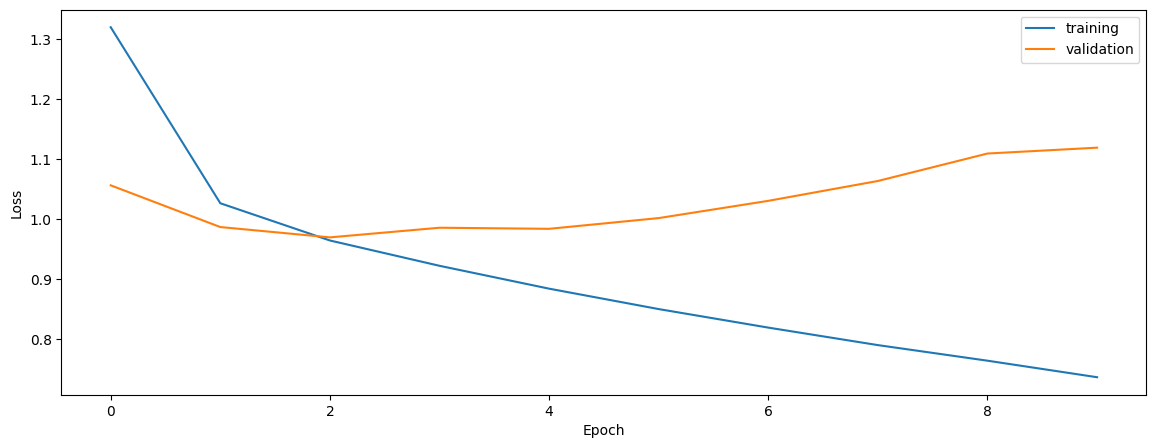

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train


0.6366212014658257
0.6117214185330078
0.6208760874056454


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5913878586901805
0.6002985943762661
0.5619018009815461


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.594330329453829
0.5972887575170727
0.5737341772151898


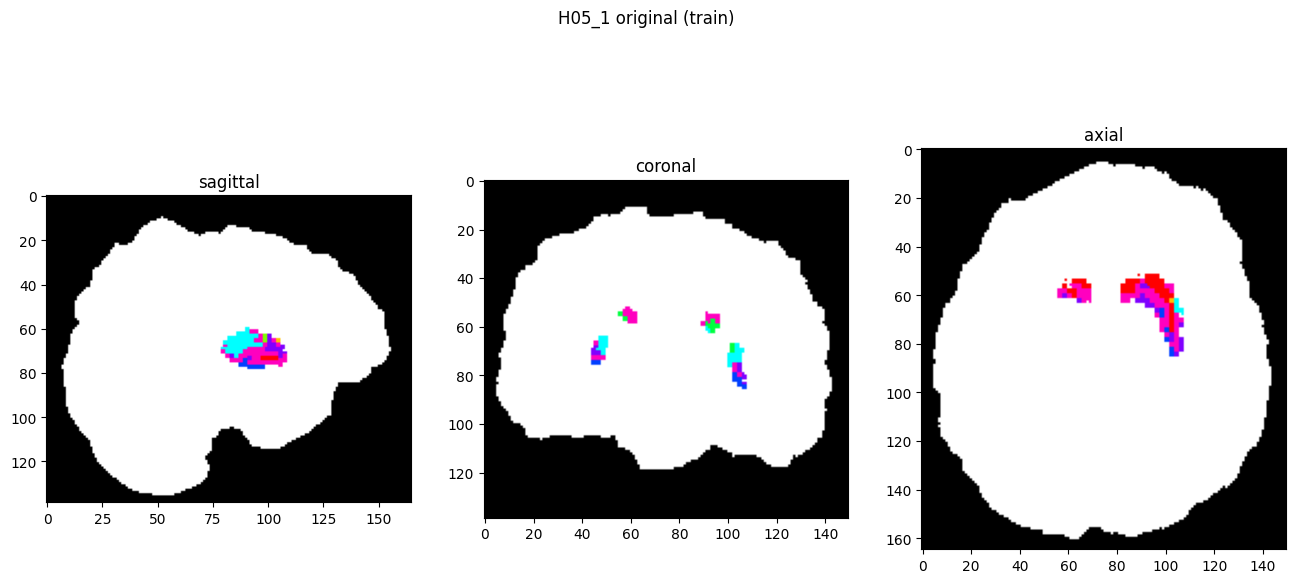

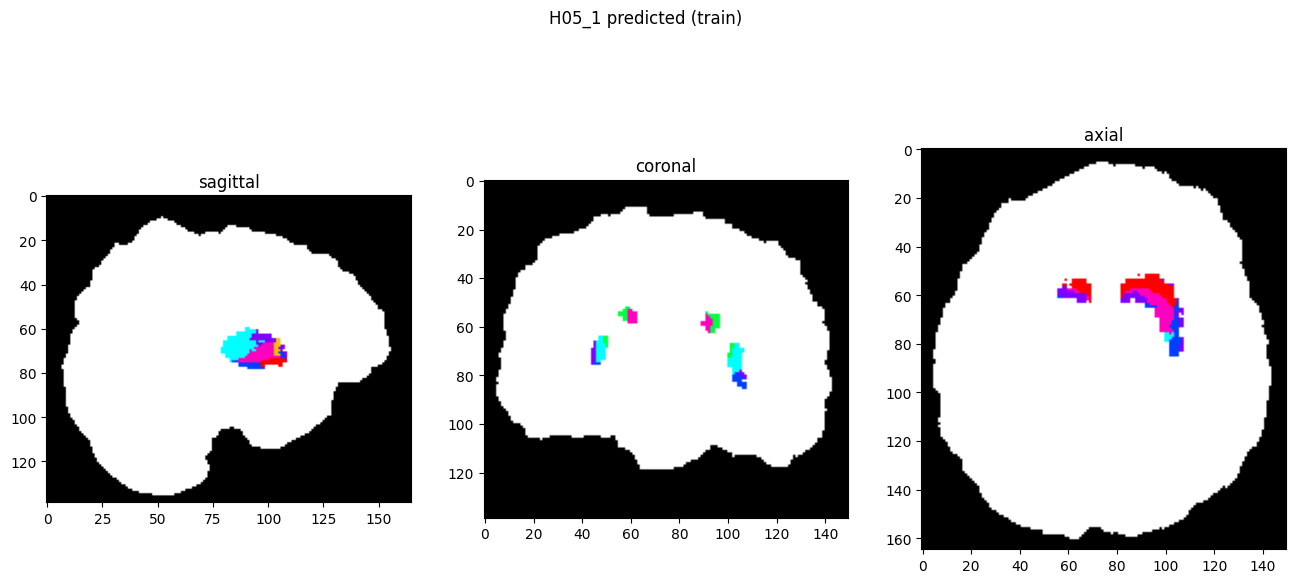

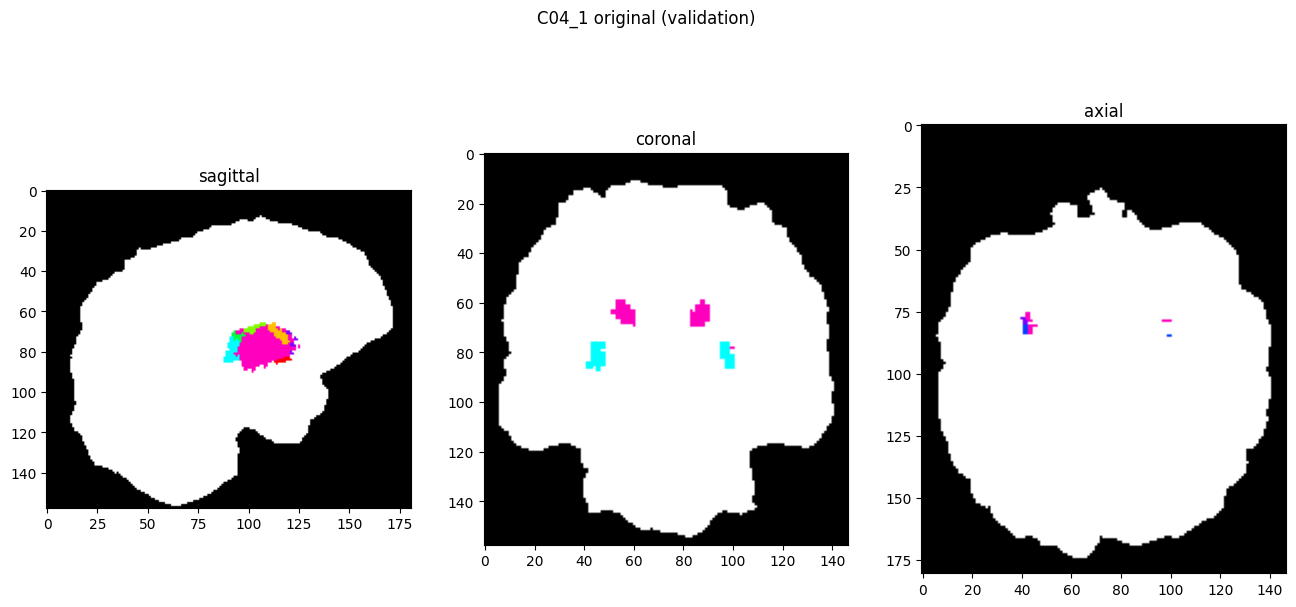

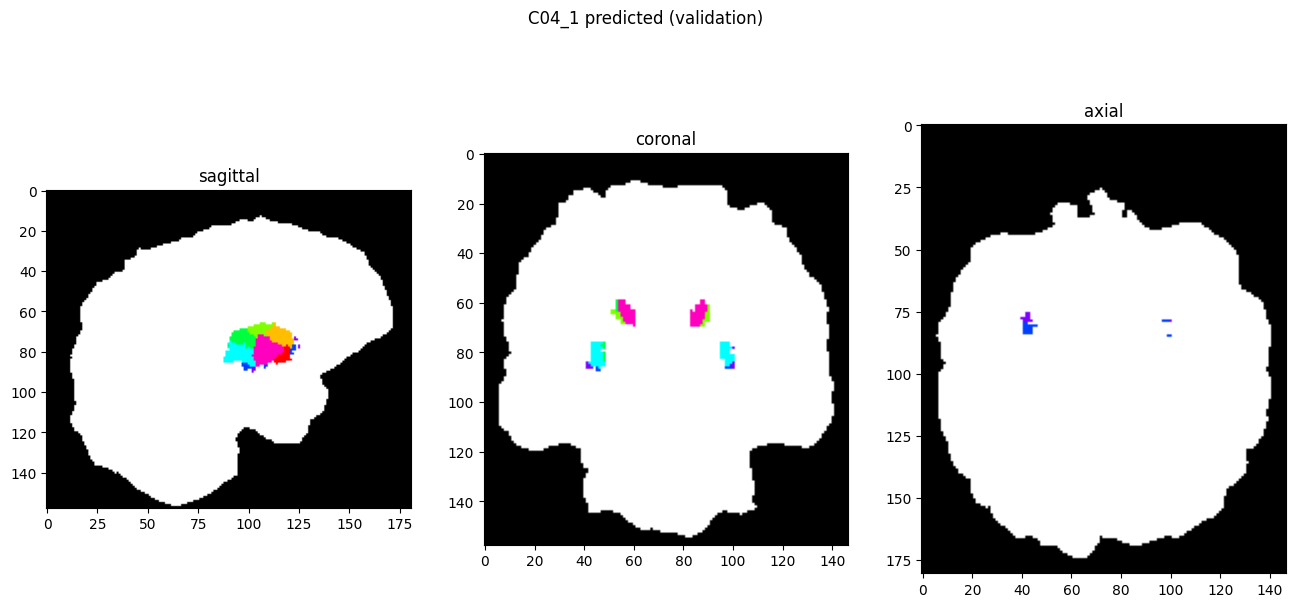

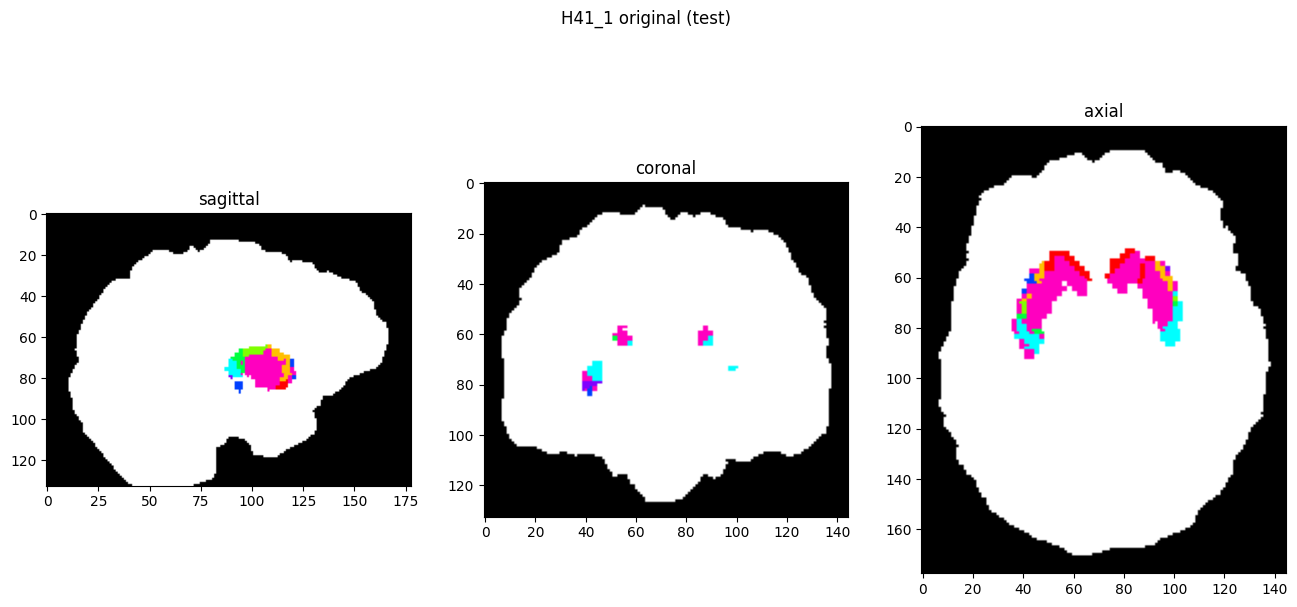

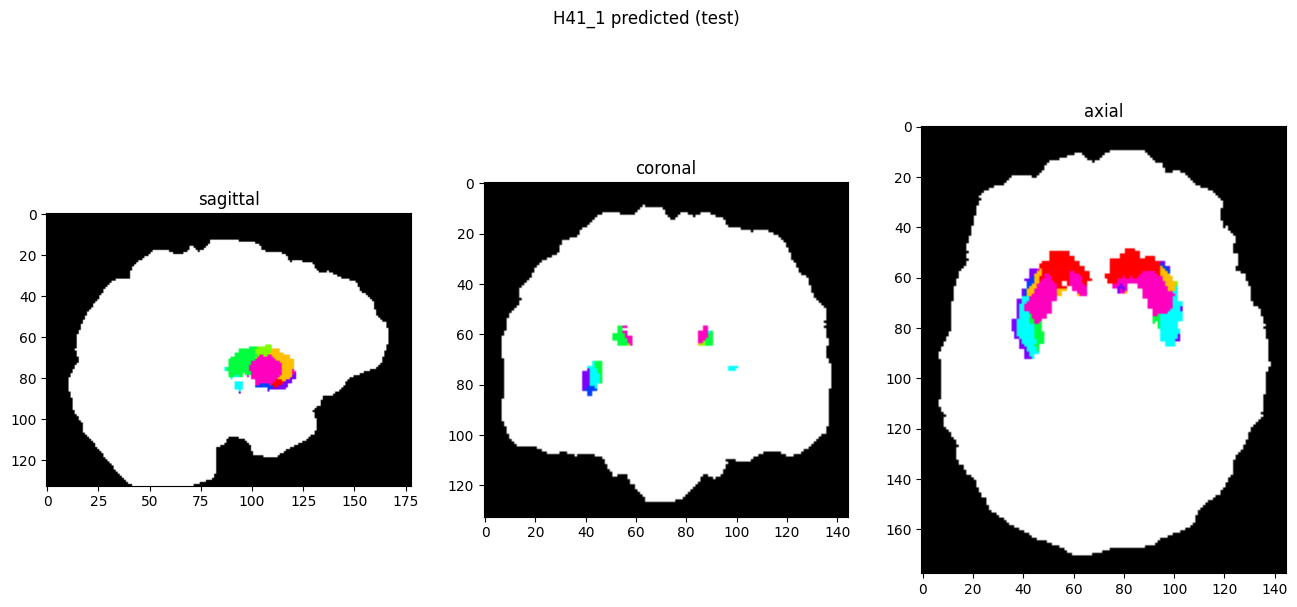

In [10]:
showResults(model, gen, threshold=0)